In [1]:
%pylab inline
%matplotlib inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Imports


In [2]:
import os
import sys
import copy
import pickle
import numpy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.pyplot import figure, subplots, imshow, xticks, yticks, title
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from statistics import mean
from scipy.stats import entropy
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from statistics import mean
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import time
import copy
import scipy.stats
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr
from sklearn.metrics import mutual_info_score
import matplotlib.colors as mcolors
from scipy.stats import ks_2samp


# Models


## Attention Layer


In [3]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim**0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

## RNN


In [4]:
class NetRNN(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.rnnLayer(x, self.h0)
        out = torch.tanh(out)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                out, h0 = self.rnnLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())
            out = torch.tanh(out)
            out = torch.tanh(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)


## RNN With Attention then Expansion


In [5]:
class NetRNNWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True, nonlinearity='tanh')
        
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)
        print(attn_out.shape)
        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        print(expanded_attn_out.shape)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # RNN processing
        h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        rnn_out, _ = self.rnnLayer(expanded_attn_out, h0)
        rnn_out = torch.tanh(rnn_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(rnn_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # RNN processing
                out, h0 = self.rnnLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)


In [198]:
model = NetRNNWithAttention()
print(model)
I = torch.Tensor(np.random.random((1,30,3)))
print(model(I))
print(model.attention(I))

NetRNNWithAttention(
  (attention): SelfAttention(
    (query): Linear(in_features=3, out_features=3, bias=True)
    (key): Linear(in_features=3, out_features=3, bias=True)
    (value): Linear(in_features=3, out_features=3, bias=True)
    (softmax): Softmax(dim=2)
  )
  (expand_layer): Linear(in_features=3, out_features=12, bias=True)
  (rnnLayer): RNN(12, 12, batch_first=True)
  (outputLayer): Linear(in_features=12, out_features=3, bias=True)
)
torch.Size([1, 30, 3])
torch.Size([1, 30, 12])
tensor([ 0.0328, -0.3013, -0.0574], grad_fn=<SqueezeBackward0>)
tensor([[[-0.2207, -0.1249, -0.3528],
         [-0.2188, -0.1251, -0.3514],
         [-0.2205, -0.1252, -0.3516],
         [-0.2202, -0.1249, -0.3526],
         [-0.2202, -0.1253, -0.3511],
         [-0.2217, -0.1247, -0.3541],
         [-0.2195, -0.1248, -0.3527],
         [-0.2197, -0.1245, -0.3541],
         [-0.2221, -0.1244, -0.3552],
         [-0.2188, -0.1250, -0.3518],
         [-0.2198, -0.1250, -0.3523],
         [-0.2196, -0

## RNN Expansion first then Attention


In [199]:
class NetRNNWithAttentionExpFirst(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttentionExpFirst, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # Attention layer applied after expansion
        self.attention = SelfAttention(self.hidden_dim)  # Assuming SelfAttention is defined elsewhere

        # RNN layer
        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True, nonlinearity='tanh')

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        expanded_x = self.expand_layer(x)
        expanded_x = torch.tanh(expanded_x)

        # Apply attention
        attn_out = self.attention(expanded_x)

        # RNN processing
        h0 = torch.zeros(1, attn_out.shape[0], self.hidden_dim)
        rnn_out, _ = self.rnnLayer(attn_out, h0)
        rnn_out = torch.tanh(rnn_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(rnn_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer with tanh activation
                expanded_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                expanded_input = torch.tanh(expanded_input)

                # Applying attention to each timestep
                attn_out = self.attention(expanded_input)

                # RNN processing
                out, h0 = self.rnnLayer(attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetRNNWithAttention(hidden_dim=12)


## LSTM


In [6]:
class NetLSTM(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), 1, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim/2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        # Initialize hidden and cell states
        self.h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
                   torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))

        # LSTM processing
        out, self.h0 = self.lstmLayer(x, self.h0)
        out = torch.tanh(out)  # Apply tanh to the LSTM output if needed

        # Concatenate hidden and cell states
        hh = numpy.concatenate((self.h0[0].detach().numpy(), self.h0[1].detach().numpy()), 2)
        self.hidden.append(hh)

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                out, h0 = self.lstmLayer(step_input, h0)
                hh = numpy.concatenate((h0[0].detach().numpy().flatten(), h0[1].detach().numpy().flatten()))
                H.append(hh.flatten())

            out = torch.tanh(out)  # Apply tanh to the LSTM output if needed
            out = torch.tanh(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)
    
model = NetLSTM(hidden_dim=12)


## LSTM with Attention then Expansion


In [7]:
class NetLSTMWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim/2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)

        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # LSTM processing
        h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
              torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))
        lstm_out, _ = self.lstmLayer(expanded_attn_out, h0)
        lstm_out = torch.tanh(lstm_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(lstm_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # LSTM processing
                out, h0 = self.lstmLayer(expanded_attn_out, h0)
                H.append(torch.cat((h0[0].detach(), h0[1].detach()), 2).numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    
model = NetLSTMWithAttention(hidden_dim=12)


## LSTM Expansion first then Attention


In [202]:
class NetLSTMWithAttentionExpFirst(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTMWithAttentionExpFirst, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer first
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # Attention layer applied after expansion
        self.attention = SelfAttention(self.hidden_dim)  # Assuming SelfAttention is defined elsewhere

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim / 2), batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim / 2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        expanded_x = self.expand_layer(x)
        expanded_x = torch.tanh(expanded_x)

        # Apply attention
        attn_out = self.attention(expanded_x)

        # LSTM processing
        h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim / 2)),
              torch.zeros(1, x.shape[0], int(self.hidden_dim / 2)))
        lstm_out, _ = self.lstmLayer(attn_out, h0)
        lstm_out = torch.tanh(lstm_out)

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(lstm_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim / 2)),
                  torch.zeros(1, 1, int(self.hidden_dim / 2)))
            for i in range(x.shape[1]):
                # Apply the expansion layer with tanh activation
                expanded_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                expanded_input = torch.tanh(expanded_input)

                # Applying attention to each timestep
                attn_out = self.attention(expanded_input)

                # LSTM processing
                out, h0 = self.lstmLayer(attn_out, h0)
                H.append(torch.cat((h0[0].detach(), h0[1].detach()), 2).numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetLSTMWithAttention(hidden_dim=12)


## GRU


In [8]:
class NetGRU(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(x, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                # GRU processing
                out, h0 = self.gruLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    
model = NetGRU(hidden_dim=12)


## GRU with Attention then Expansion


In [9]:
class NetGRUMWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRUMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)

        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(expanded_attn_out, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # GRU processing
                out, h0 = self.gruLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetGRUMWithAttention(hidden_dim=12)


## GRU Expansion first then Attention


In [205]:
class NetGRUMWithAttentionExpFirst(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRUMWithAttentionExpFirst, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer first
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # Attention layer applied after expansion
        self.attention = SelfAttention(self.hidden_dim)  # Assuming SelfAttention is defined elsewhere

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        expanded_x = self.expand_layer(x)
        expanded_x = torch.tanh(expanded_x)

        # Apply attention
        attn_out = self.attention(expanded_x)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(attn_out, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer with tanh activation
                expanded_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                expanded_input = torch.tanh(expanded_input)

                # Applying attention to each timestep
                attn_out = self.attention(expanded_input)

                # GRU processing
                out, h0 = self.gruLayer(attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetGRUMWithAttention(hidden_dim=12)


# Data Generation


In [10]:
def generateTrainData(num_samples, min_max):
    s = []  # Sequences
    t = []  # Labels
    params = {
    "min_length": min_max[0],
    "max_length": min_max[1],
    "fill": 0,
    "value_1": -1,
    "value_2": 1,
}
    for _ in range(num_samples):
        common_length = np.random.randint(params["min_length"], params["max_length"] + 1)

        array_A = np.full(common_length, params["fill"])
        array_B = np.full(common_length, params["fill"])
        array_C = np.full(common_length, params["fill"])

        # Exclude the last two indices
        possible_indices = np.arange(common_length - 2)

        index_A = np.random.choice(possible_indices)
        value_A = np.random.choice([params["value_1"], params["value_2"]])
        array_A[index_A] = value_A

        # Update possible indices for array B to also exclude index_A
        possible_indices_B = np.delete(possible_indices, np.where(possible_indices == index_A))
        index_B = np.random.choice(possible_indices_B)
        value_B = np.random.choice([params["value_1"], params["value_2"]])
        array_B[index_B] = value_B

        value_C = np.random.choice([params["value_1"], params["value_2"]])
        array_C[-1] = value_C
        array_C[-2] = value_C

        mapped_value_A = 1 if value_A == params["value_2"] else 0
        mapped_value_B = 1 if value_B == params["value_2"] else 0
        #value_1 = -1
        #value_2 = 1
        if value_C == params["value_1"]: # XOR
            result = int(mapped_value_A != mapped_value_B) 
        else : # XNOR
            result =  int(mapped_value_A == mapped_value_B)

        # Mapping back to original value_1 and value_2 for the label
        label_value_A = params["value_2"] if mapped_value_A == 1 else params["value_1"]
        label_value_B = params["value_2"] if mapped_value_B == 1 else params["value_1"]
        results_XORNOR= params["value_2"] if result == 1 else params["value_1"]

        #label_arr = [mapped_value_A, mapped_value_B, result]  # Label array with value_A, value_B, and result
        label_arr = [label_value_A, label_value_B, results_XORNOR]  # Label array with value_A, value_B, and result

        combined_array = np.vstack([array_A, array_B, array_C]).T
        s.append(combined_array)
        t.append(label_arr)

    return s, np.array(t)


In [ ]:
num_seq = 1
# Example dictionary with parameters
sequences, labels = generateTrainData(num_seq, [5,5])
print(sequences)
print(labels)

In [ ]:

sequences, labels = generateTrainData(1, [10,10])
model = NetRNN()
output=model(torch.Tensor(sequences))
print(torch.Tensor(sequences))
print(output.shape)
print(model)

In [ ]:
sequences, labels = generateTrainData(5, [10,15])

def plot_sequences(sequences, labels):
    num_samples = len(sequences)  # Number of samples to display

    # Plotting
    plt.figure(figsize=(3 * num_samples, 15))

    for i, (seq, label) in enumerate(zip(sequences, labels)):
        reshaped_sequence = seq  # Use the sequence as it is

        ax = plt.subplot(1, num_samples, i + 1)
        img = ax.imshow(
            reshaped_sequence, cmap="gray", vmin=-1.0, vmax=1.0
        )  # Adjusted vmin and vmax
        operation_title = "XOR" if seq[-1][2] == -1 else "XNOR"
        ax.set_title(f"Operation: {operation_title}, {label}")

        ax.set_xlabel("Arrays (A, B, C)")
        ax.set_ylabel("Time Points")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["A", "B", "C"])
        ax.set_yticks(range(reshaped_sequence.shape[0]))
        ax.set_yticklabels([f"{j+1}" for j in range(reshaped_sequence.shape[0])])

    # Adjusted positioning of colorbar
    cbar_ax = plt.gcf().add_axes([0.93, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(img, cax=cbar_ax)
    cbar.set_ticks([-1, 0, 1])
    cbar.set_ticklabels(["-1", "0", "1"])

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()


# Example usage
# Assuming sequences and labels are already generated using generateTrainData
plot_sequences(sequences, labels)

In [51]:
parameters_list = []

# min_lengths = [5, 10, 10, 20, 20, 40, 40, 70,100]
# max_lengths = [5, 10, 15, 20, 25, 40, 45,75,140]
min_lengths = [50]
max_lengths = [50]

# Training


In [ ]:
collectorA = dict()
num_samples = 100
for rep in range(3):  # Number of repetitions
    for min_len, max_len in zip(min_lengths, max_lengths):
        # Select the model based on 'kind'
        #for kind in ["RNN", "RNNA","LSTM", "LSTMA", "GRU", "GRUA"]:
        for kind in ["RNN"]:
        # Select the model based on 'kind'
            if kind == "RNN":
                model = NetRNN(hidden_dim=12, inp=3)
            elif kind == "RNNA":
                model = NetRNNWithAttention(hidden_dim=12, inp=3)
            elif kind == "RNNE":
                model = NetRNNWithAttentionExpFirst(hidden_dim=12, inp=3)
            elif kind == "LSTM":
                model = NetLSTM(hidden_dim=12, inp=3)
            elif kind == "LSTMA":
                model = NetLSTMWithAttention(hidden_dim=12, inp=3)
            elif kind == "LSTME":
                model = NetLSTMWithAttentionExpFirst(hidden_dim=12, inp=3)
            elif kind == "GRU":
                model = NetGRU(hidden_dim=12, inp=3)
            elif kind == "GRUA":
                model = NetGRUMWithAttention(hidden_dim=12, inp=3)
            elif kind == "GRUE":
                model = NetGRUMWithAttentionExpFirst(hidden_dim=12, inp=3)

            optimizer = optim.Adam(model.parameters())
            criterion = nn.MSELoss()
            acc = 0.0
            W = []
            AC = []
            start_time = time.time()  # Start time of the epoch

            while True:
                sequences, targets = generateTrainData(num_samples, [min_len,max_len])
                total_loss = 0
                total_acc = 0
                count = 0

                for seq, target in zip(sequences, targets):
                    optimizer.zero_grad()
                    seq_tensor = torch.Tensor([seq])  # Add an extra dimension for batch
                    target_tensor = torch.Tensor([target])

                    output = model(seq_tensor)
                    loss = criterion(output, target_tensor)
                    total_loss += loss.item()

                    loss.backward()
                    optimizer.step()

                    # Calculate accuracy
                    A = 1.0 * (target_tensor.detach() > 0.0)
                    B = 1.0 * (output.detach() > 0.0)
                    acc = (1.0 * (A.flatten() == B.flatten())).mean()
                    total_acc += acc
                    count += 1

                avg_loss = total_loss / count
                avg_acc = total_acc / count
                W.append(avg_loss)
                AC.append(avg_acc)
                print(f"{kind}, rep: {rep}, epoch: {len(AC)}, acc: {avg_acc}, Loss {avg_loss}")

                # Check for stopping condition
                if avg_acc >= 0.97 or len(W)>2000:
                    break

            end_time = time.time()  # End time of the epoch
            epoch_duration = end_time - start_time  # Calculate duration
            collectorA[f"{kind}_rep_{rep}_min_{min_len} max_{max_len}"] = AC
            torch.save(model, f'model_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.model')
            print(f"{kind:<20} Rep: {rep:<3} Epoch: {len(A):<5} Acc: {avg_acc:.4f} " f"_min_{min_len}_max_{max_len} Time: {epoch_duration:.2f} sec")
            df=pd.DataFrame()
            df["accuracy"]=AC
            df["loss"]=W
            df.to_csv(f'score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv')

In [ ]:
print(collectorA.keys())

# Accuracy plots


In [11]:
def tensor_str_to_float(tensor_str):
    # Convert a string like 'tensor(0.4533)' to a float
    return float(tensor_str.strip('tensor()'))

def pad_data(data, target_length):
    # Truncate or extend the data to the target length
    if len(data) > target_length:
        return data[:target_length]
    else:
        pad_value = data[-1] if data else 0  # Use last value or 0 if data is empty
        x = data + [pad_value] * (target_length - len(data))
        return x[:target_length]
    
    
    
def read_and_process_csv(filename, target_epoch, process_func, skip_condition=None):
    try:
        data = pd.read_csv(filename)
        data['accuracy'] = data['accuracy'].apply(process_func)

        if skip_condition and skip_condition(data):
            return None, True

        padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
        return padded_data, False
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return None, False

def skip_condition(data):
    return len(data) >= 2000 and data['accuracy'].max() < 0.97


# Function to find the first epoch where accuracy reaches 80%
def find_epoch_at_80_percent(accuracy_list):  
    for i, acc in enumerate(accuracy_list):
        if acc >= 0.80:
            return i
    return None

In [56]:
# Your parameters
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000
accuracy_threshold = 0.97


# Finding models that meet criteria
models_below_threshold = []

for kind in kinds:
    for min_len, max_len in zip(min_lengths, max_lengths):
        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            
            try:
                data = pd.read_csv(filename)
                epochs = len(data)
                accuracy = data['accuracy'].apply(tensor_str_to_float)

                if epochs >= target_epoch and accuracy.max() < accuracy_threshold:
                    models_below_threshold.append({
                        'Kind': kind,
                        'Min_Length': min_len,
                        'Max_Length': max_len,
                        'Replicate': rep,
                        'Max_Accuracy': accuracy.max(),
                        'Epochs': epochs
                    })
            except FileNotFoundError:
                print(f"File not found: {filename}")

# Displaying models that meet criteria
for model in models_below_threshold:
    print(model)


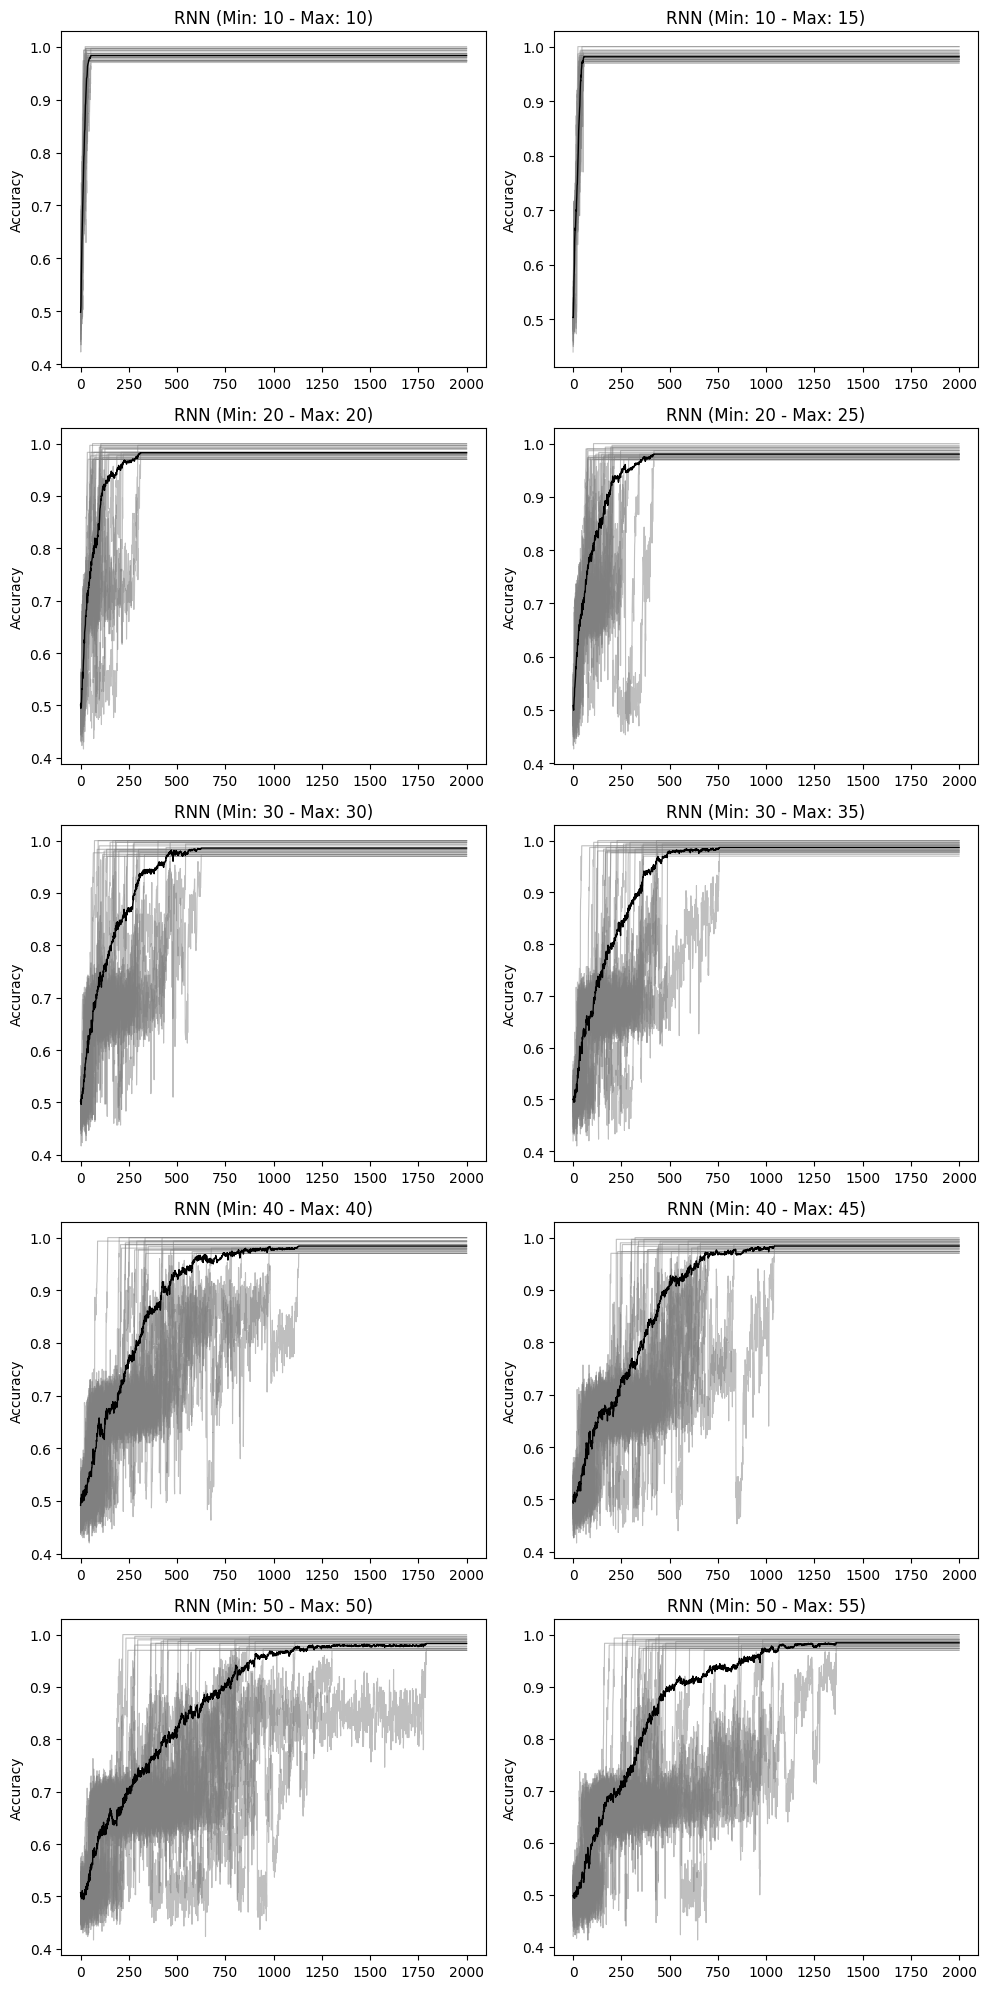

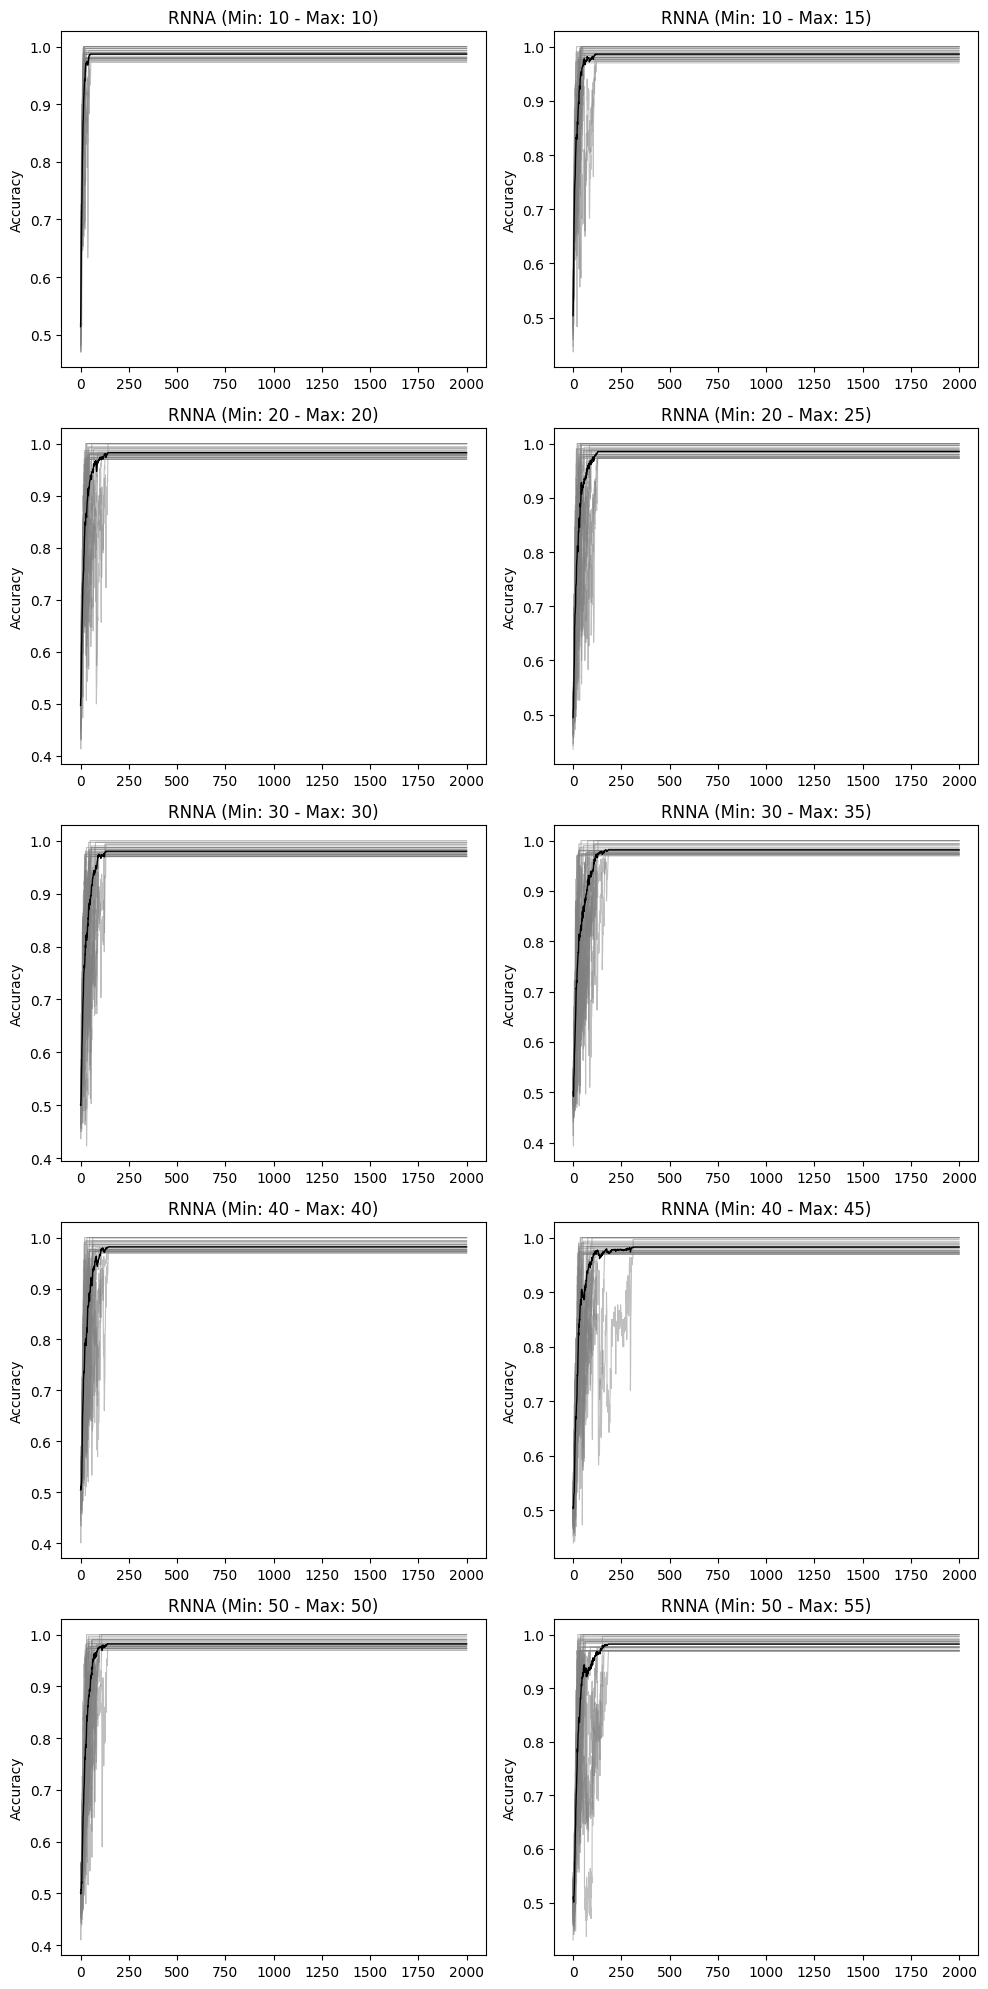

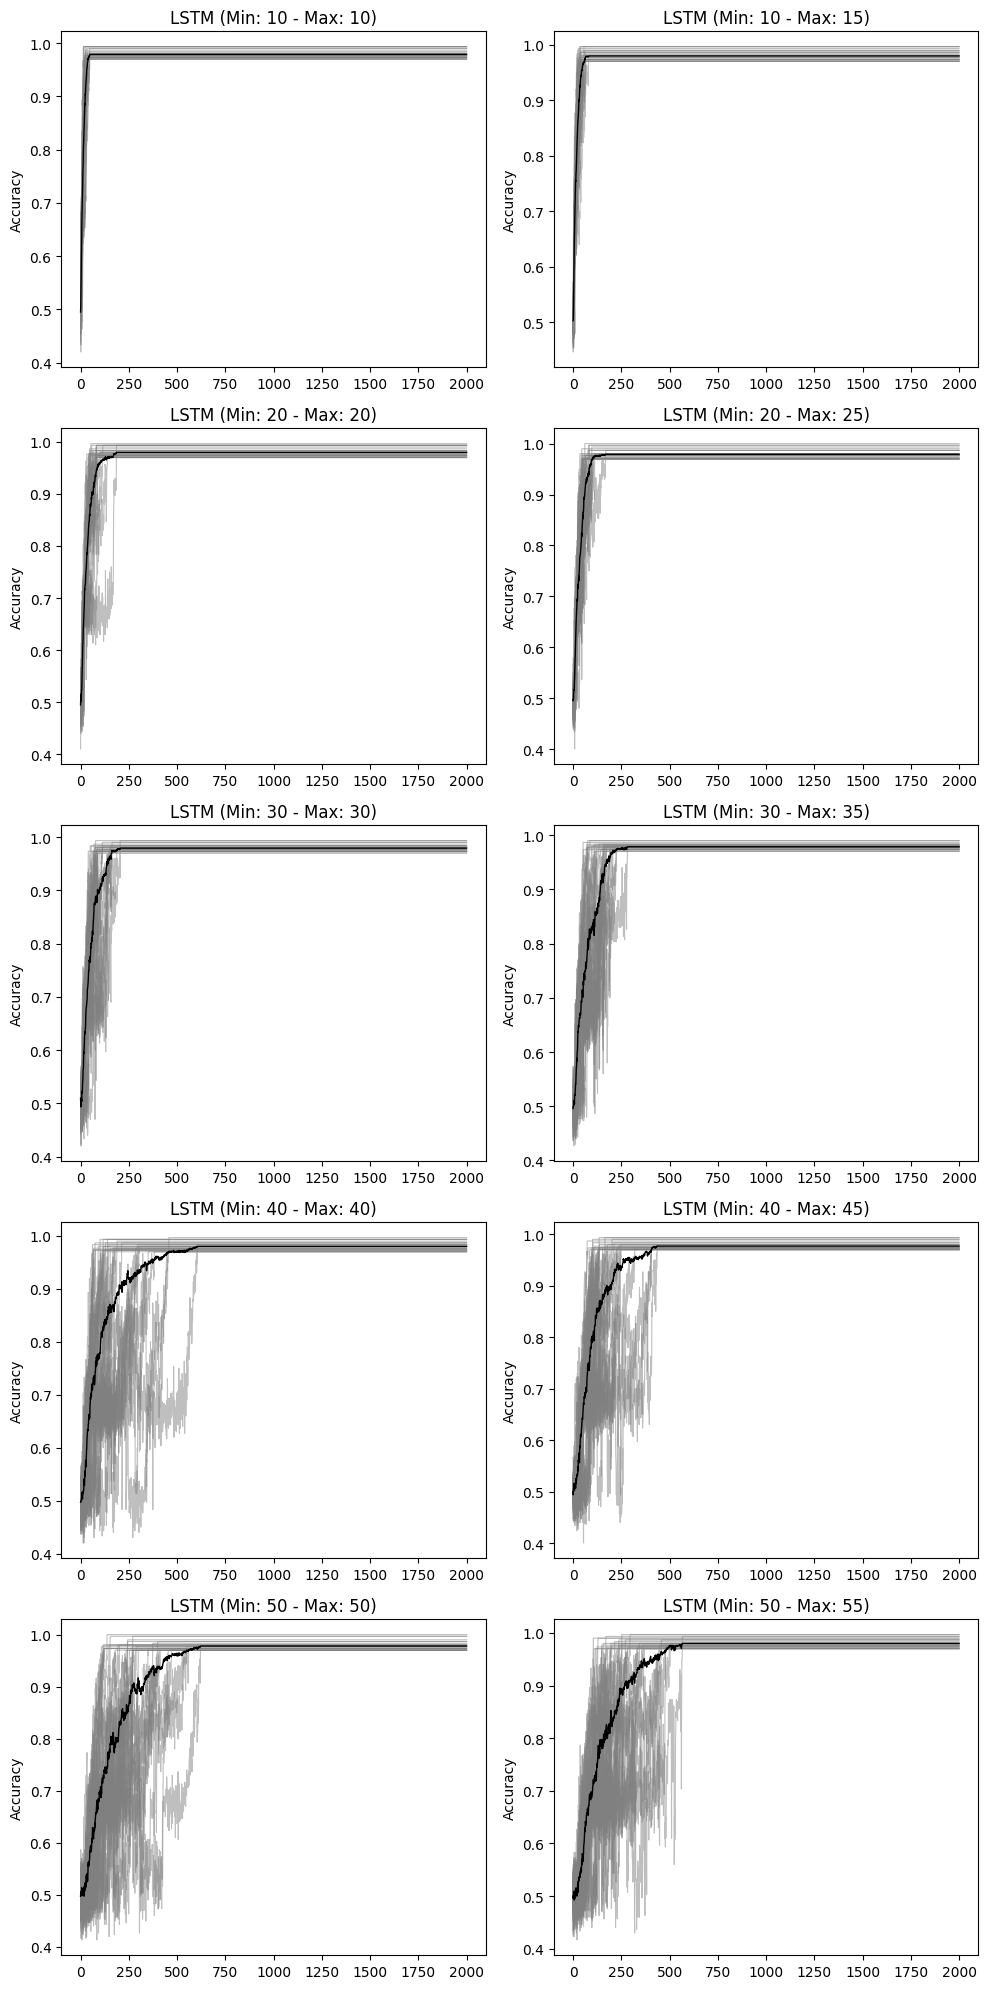

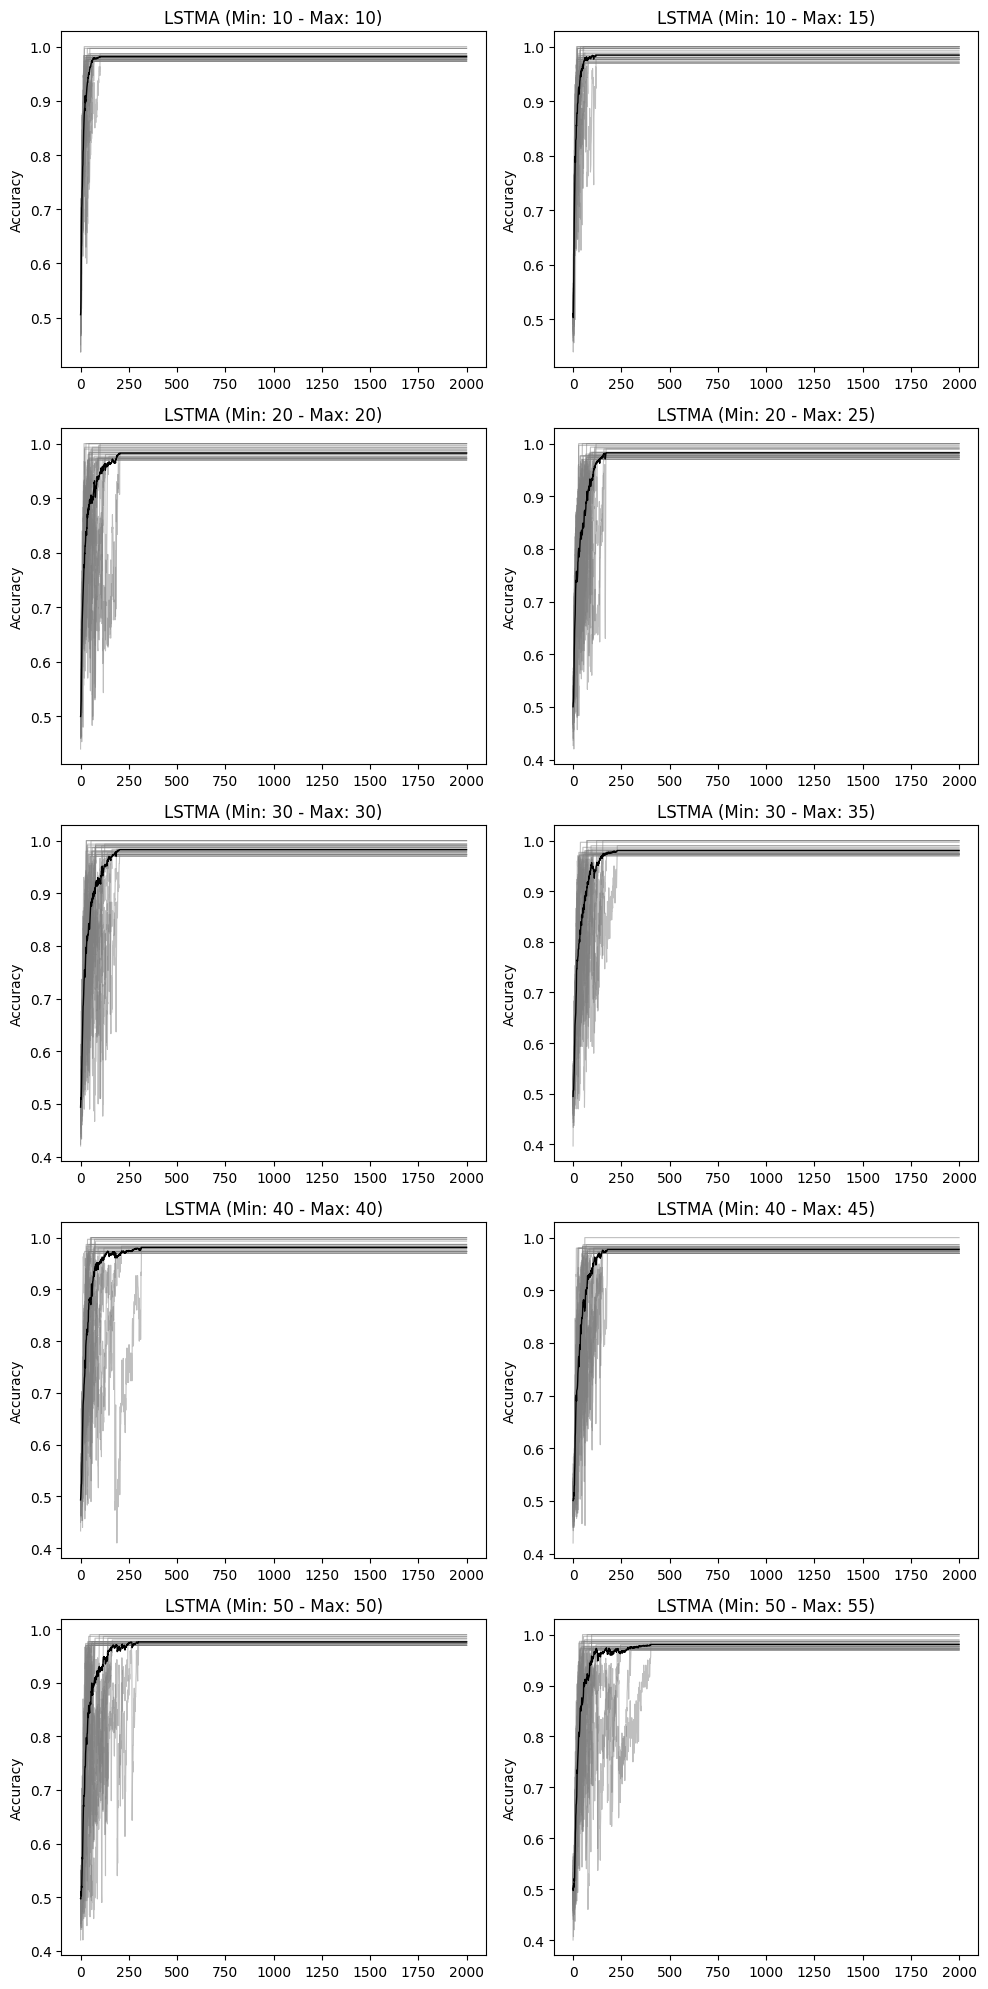

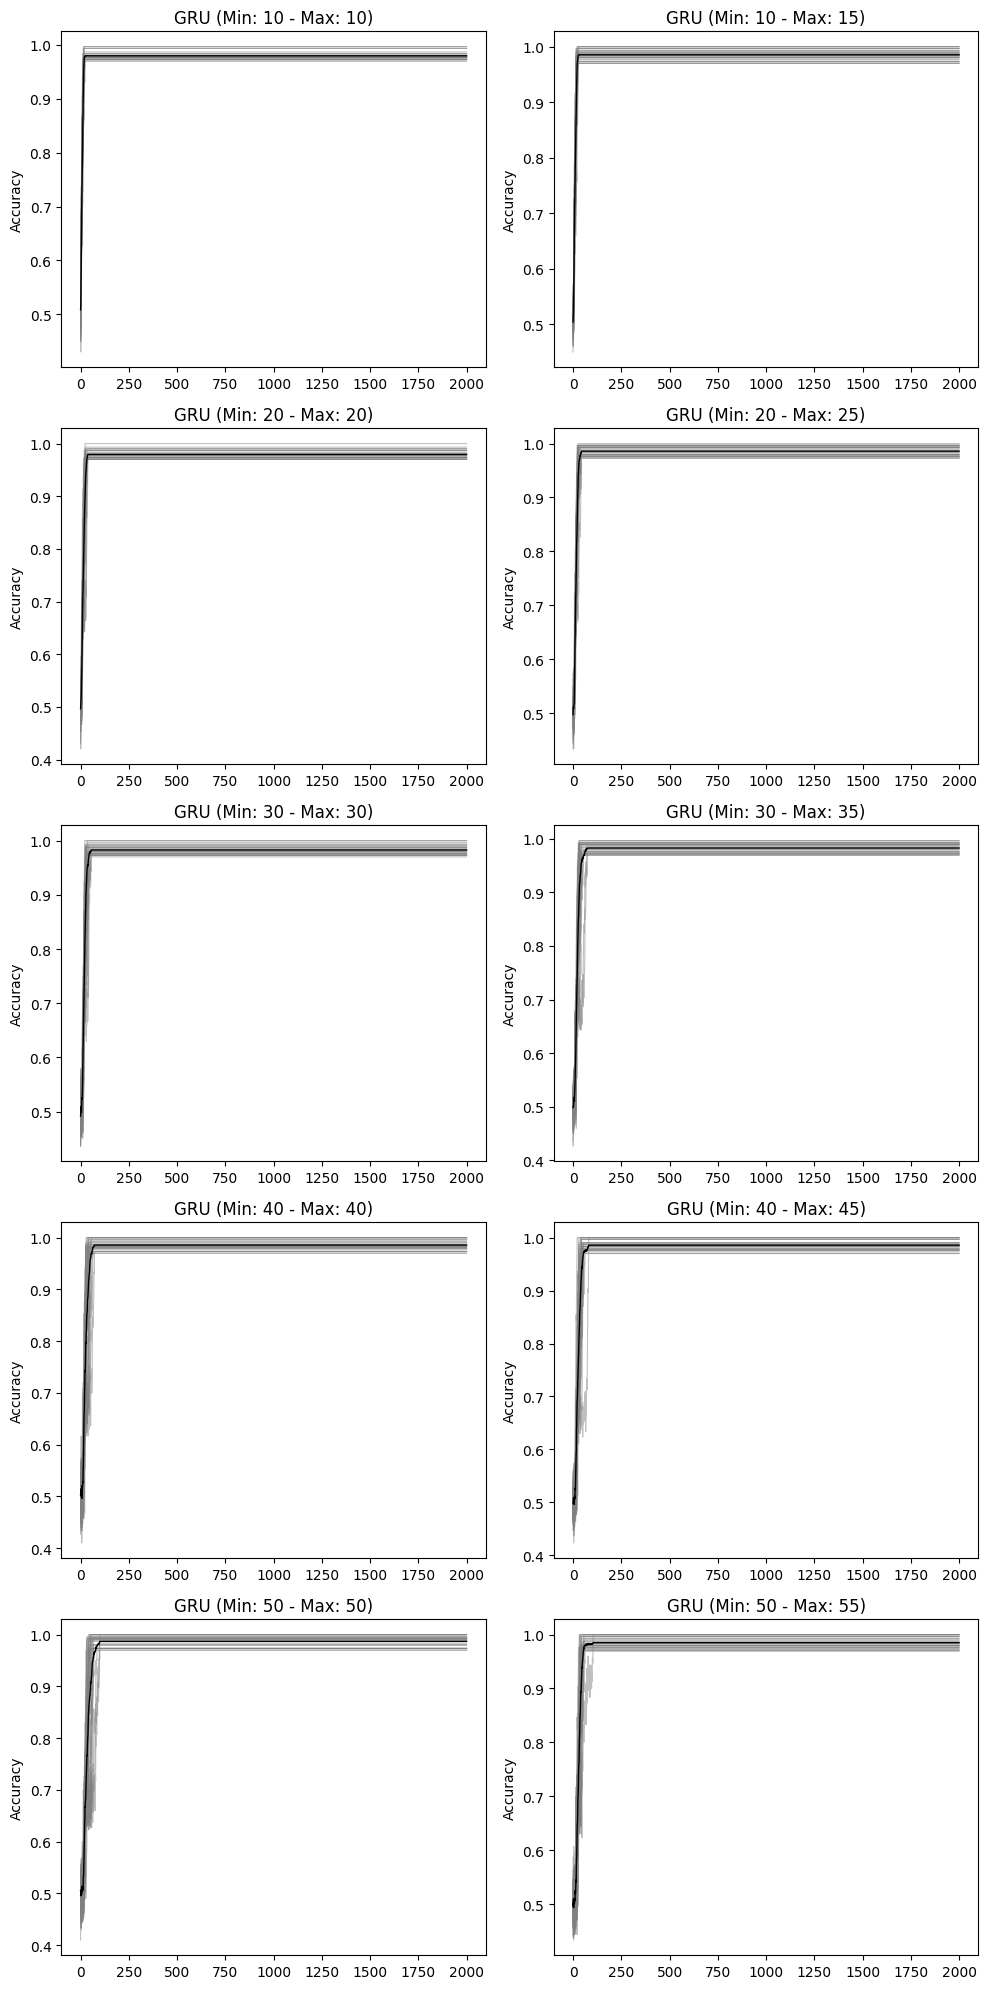

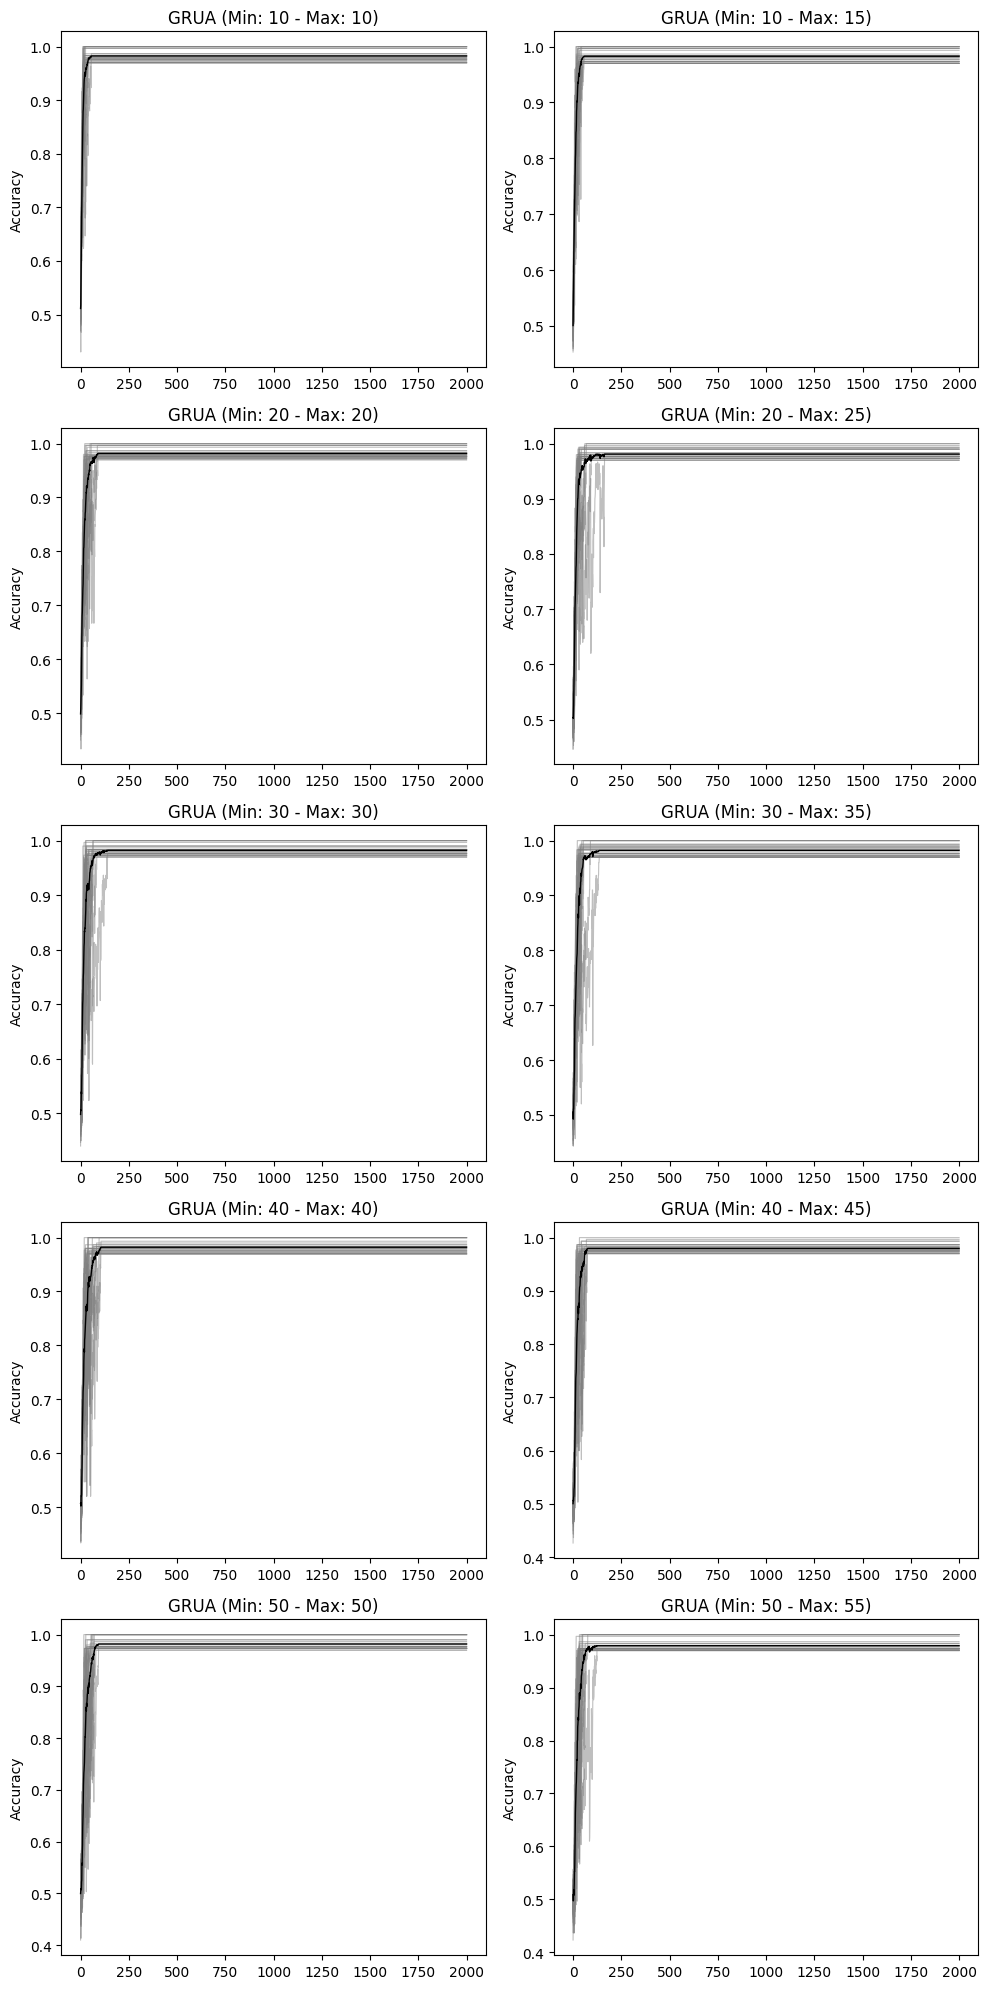

Skipped Models: []


In [57]:
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000

skipped_models = []

# Plotting for each kind
for kind in kinds:
    plt.figure(figsize=(10, 20))  # Adjust the figure size for 2x5 layout

    for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
        ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid
        rep_data = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                if should_skip:
                    skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                    continue
                if padded_data is not None:
                    rep_data.append(padded_data)
                    ax.plot(padded_data, label=f"Rep {rep+1}", alpha=0.5, linewidth=0.8, color='gray')
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if not rep_data:
            continue

        avg_data = np.mean(np.array(rep_data), axis=0)
        ax.plot(avg_data, label="Average", linewidth=1, color='black')

        ax.set_title(f"{kind} (Min: {min_len} - Max: {max_len})")
        ax.set_ylabel("Accuracy")

    plt.tight_layout()
    plt.show()

# Print the skipped models
print("Skipped Models:", skipped_models)

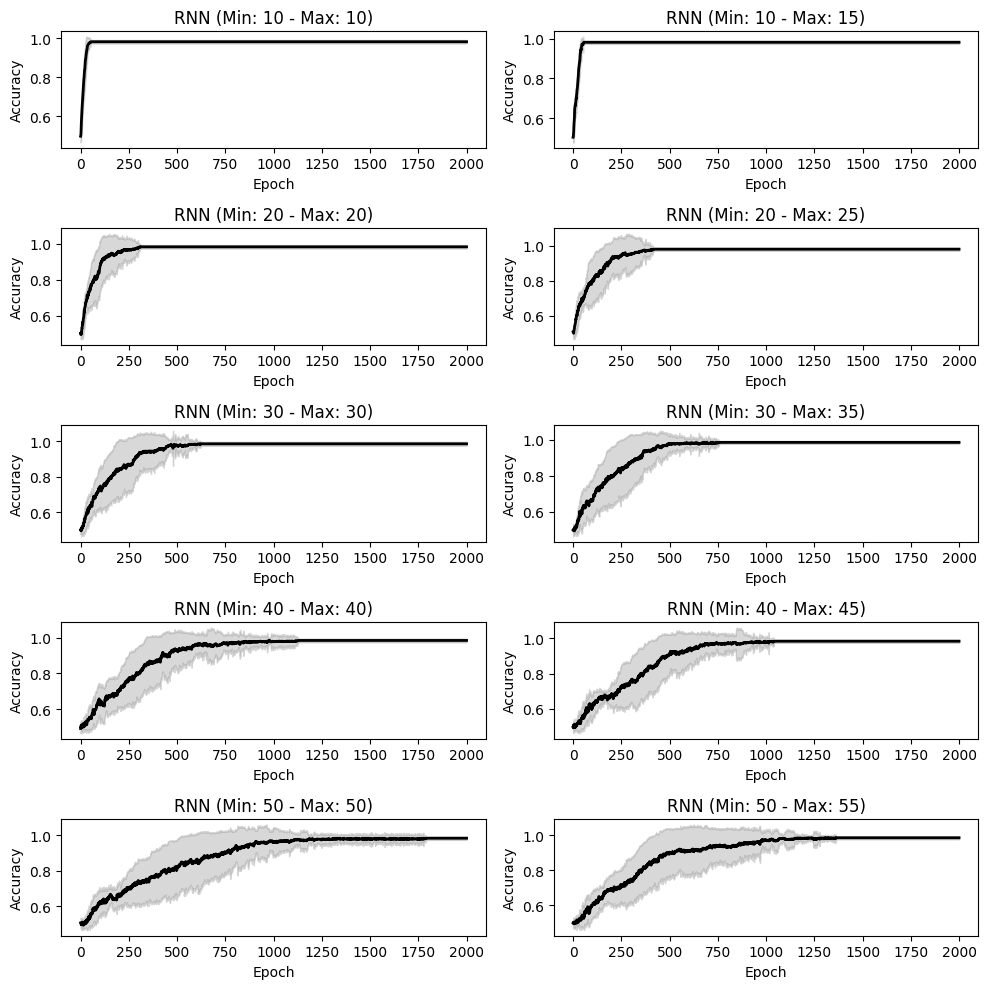

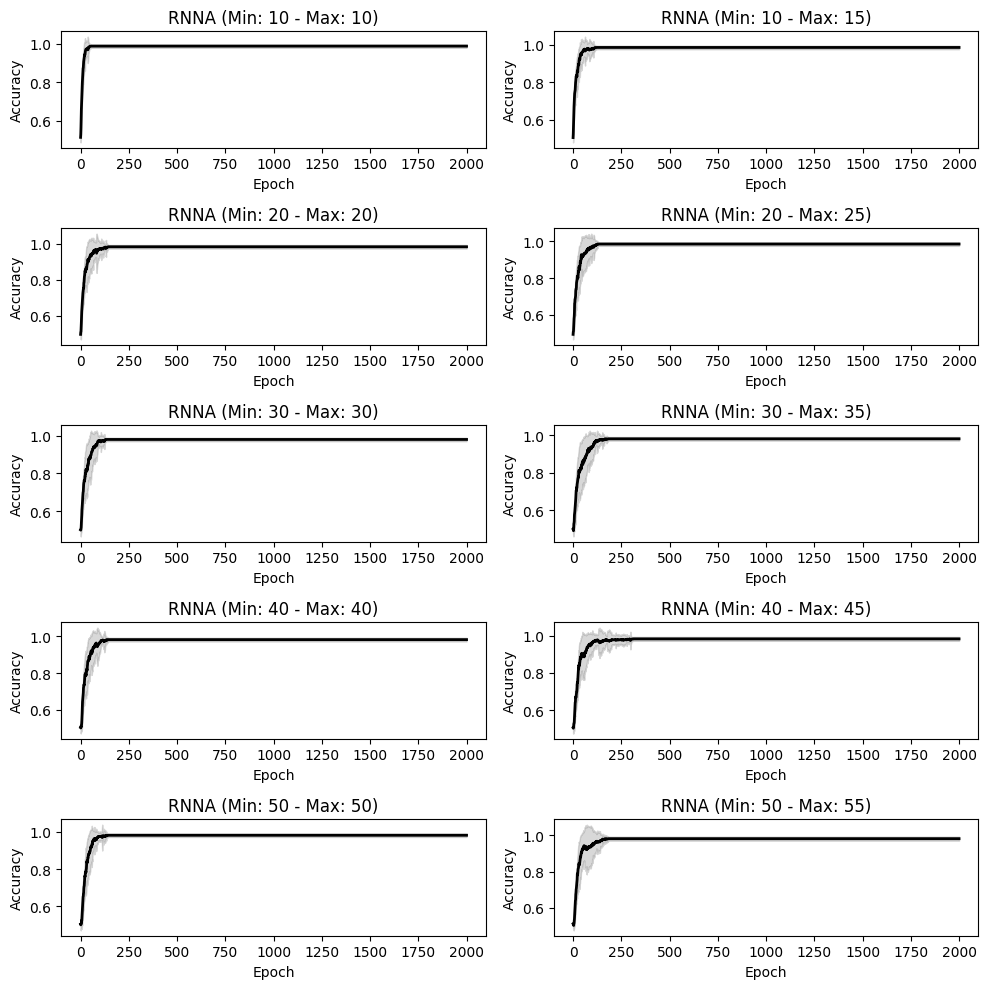

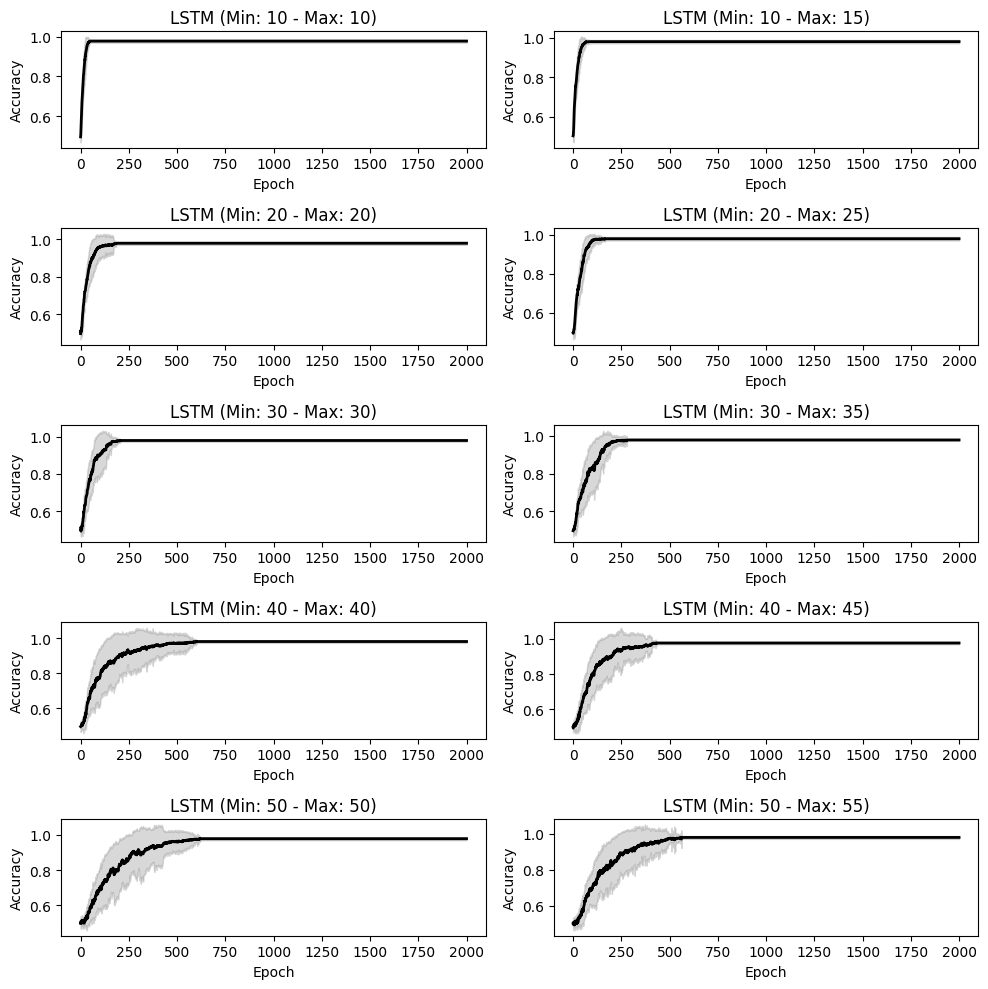

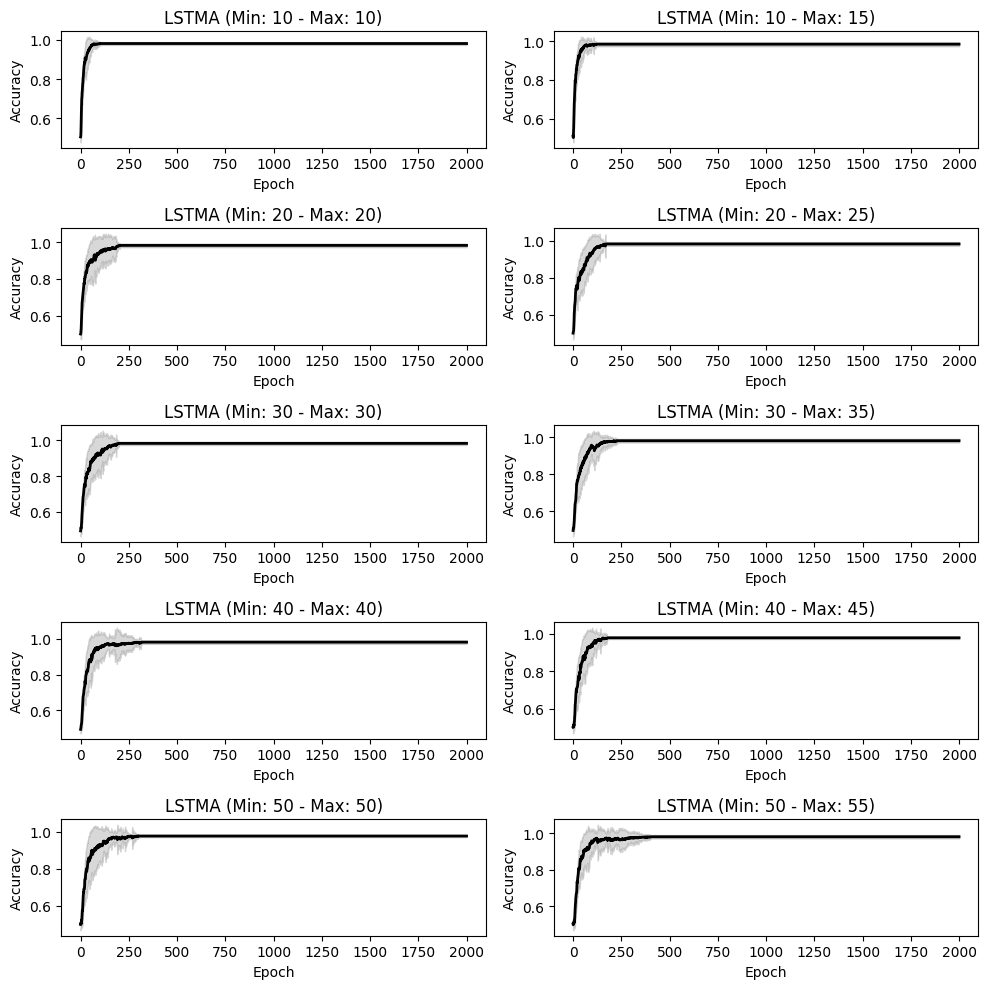

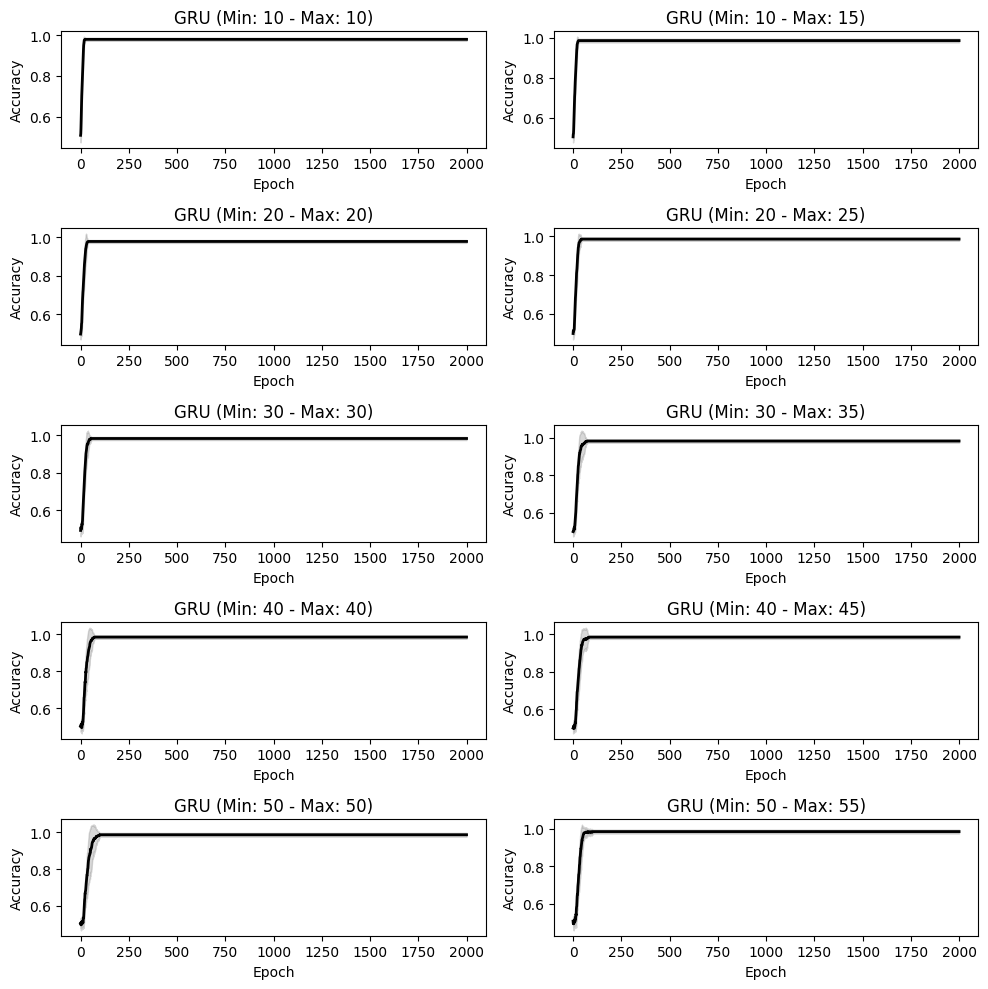

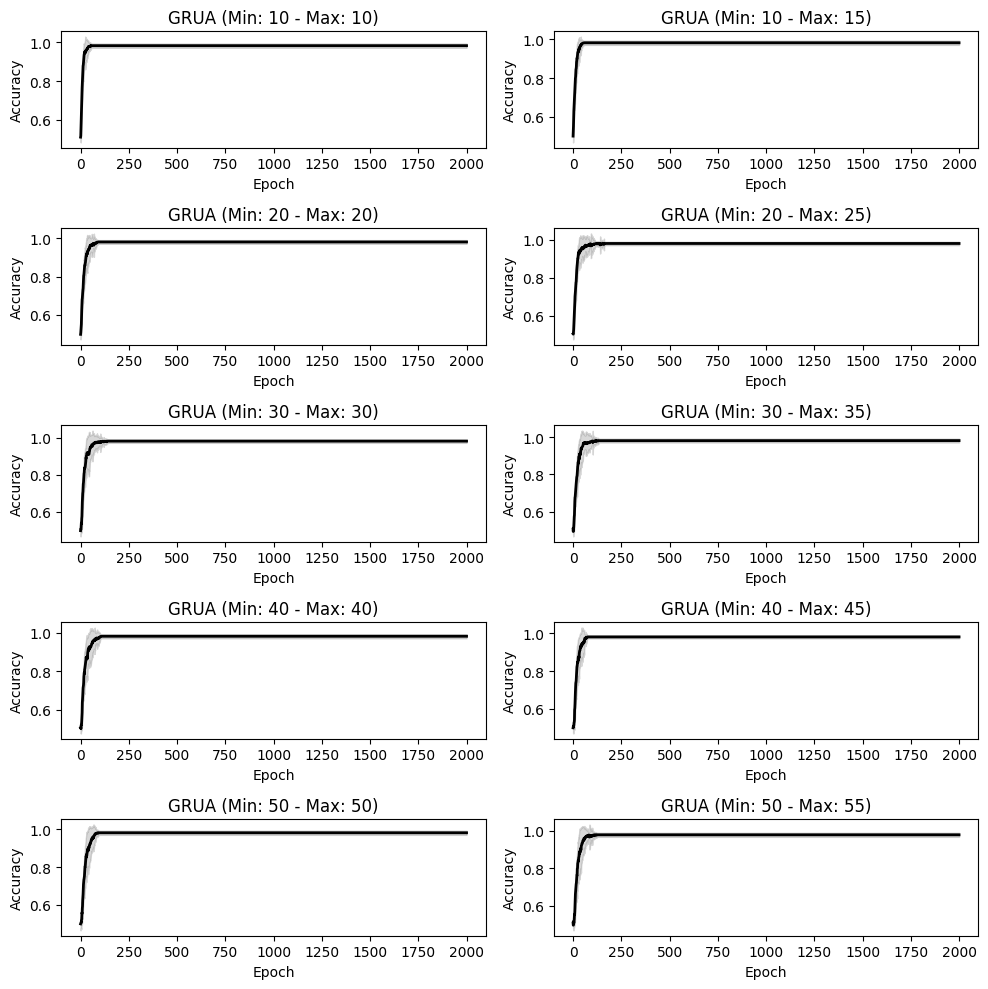

In [58]:
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000
skipped_models = []

# Adjusting the plot to grayscale and using fill_between for replicates
def plot_with_grayscale_fill_between(kind, min_lengths, max_lengths, num_reps, target_epoch):
    plt.figure(figsize=(10, 10))  # Adjust the figure size for layout

    for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
        ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

        rep_data = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                if should_skip:
                    skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                    continue
                if padded_data is not None:
                    rep_data.append(padded_data)
            except FileNotFoundError:
                continue

        if not rep_data:
            continue

        avg_data = np.mean(rep_data, axis=0)
        std_dev = np.std(rep_data, axis=0)

        # Plot replicates as fill_between
        ax.fill_between(range(target_epoch), avg_data - std_dev, avg_data + std_dev, color='gray', alpha=0.3)
        
        # Plot average as a black line
        ax.plot(avg_data, label="Average", linewidth=2, color='black')

        ax.set_title(f"{kind} (Min: {min_len} - Max: {max_len})")
        ax.set_ylabel("Accuracy")
        ax.set_xlabel("Epoch")

    plt.tight_layout()
    plt.show()

# Plotting for each kind
for kind in kinds:
    plot_with_grayscale_fill_between(kind, min_lengths, max_lengths, num_reps, target_epoch)


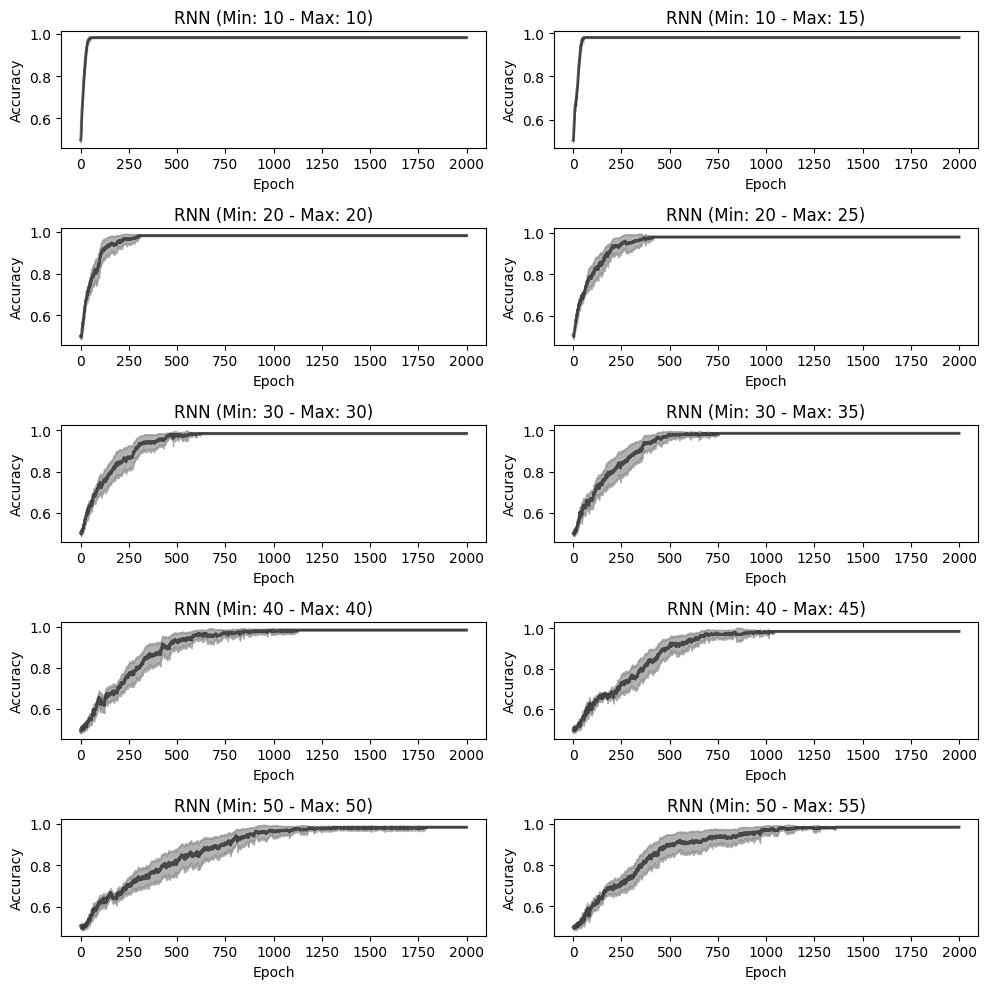

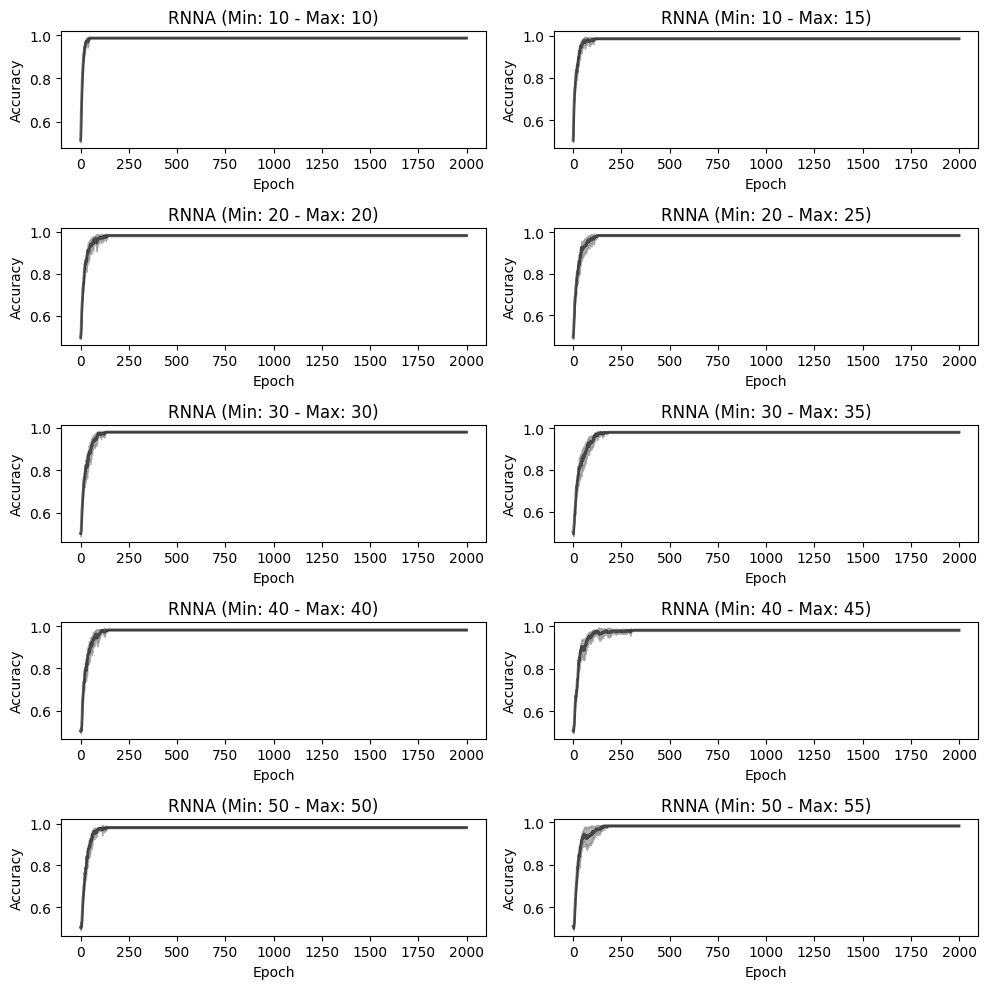

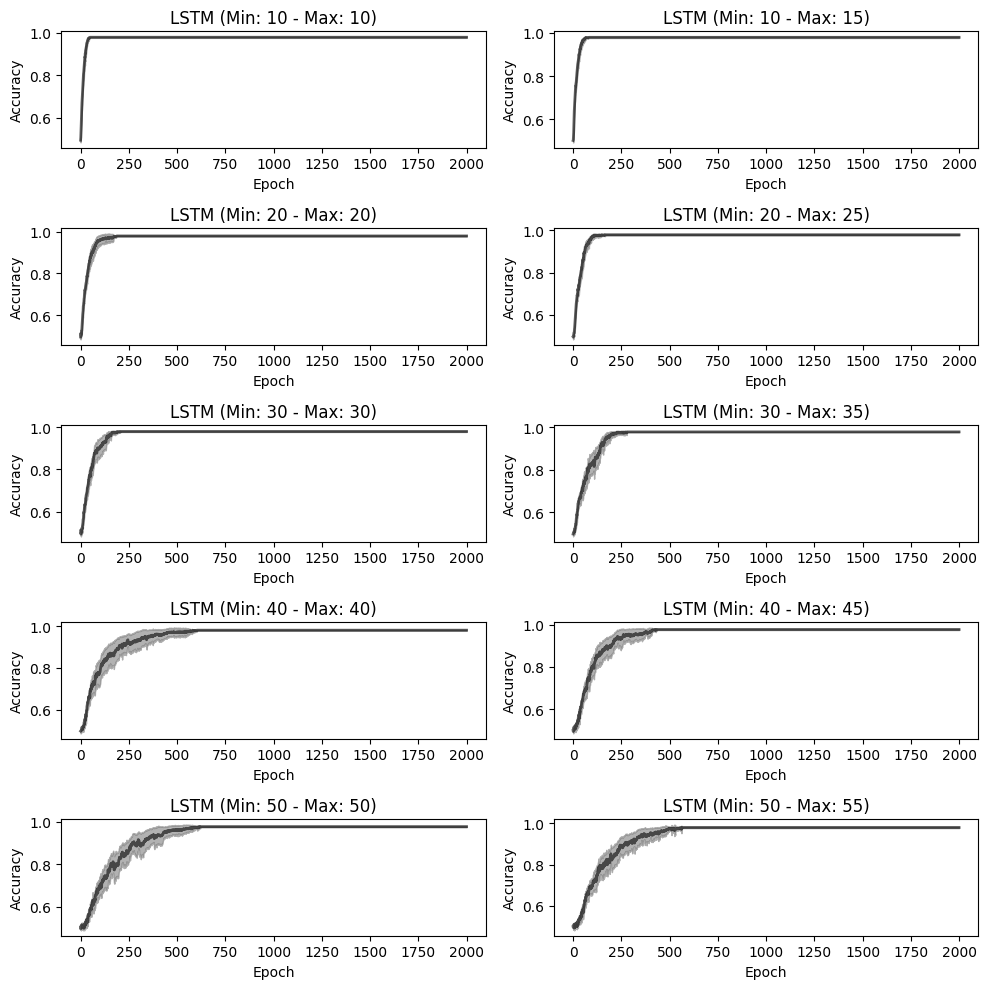

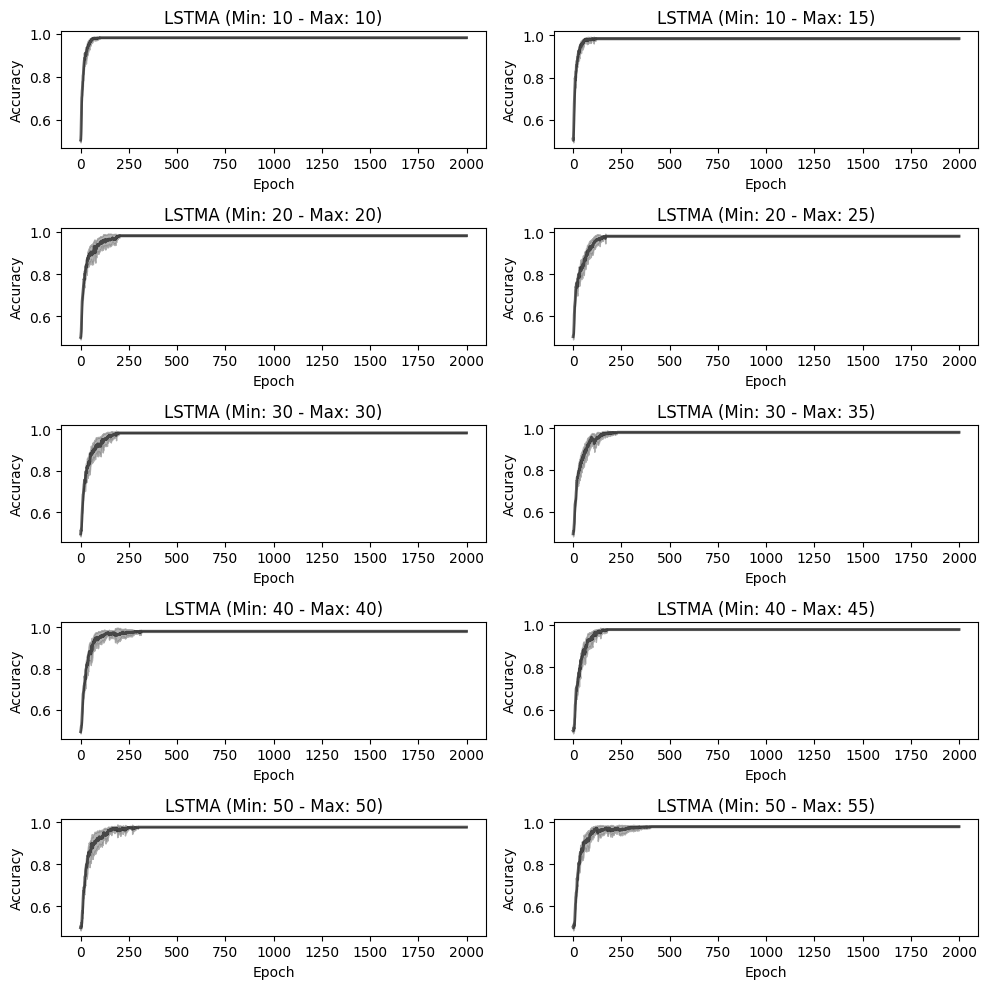

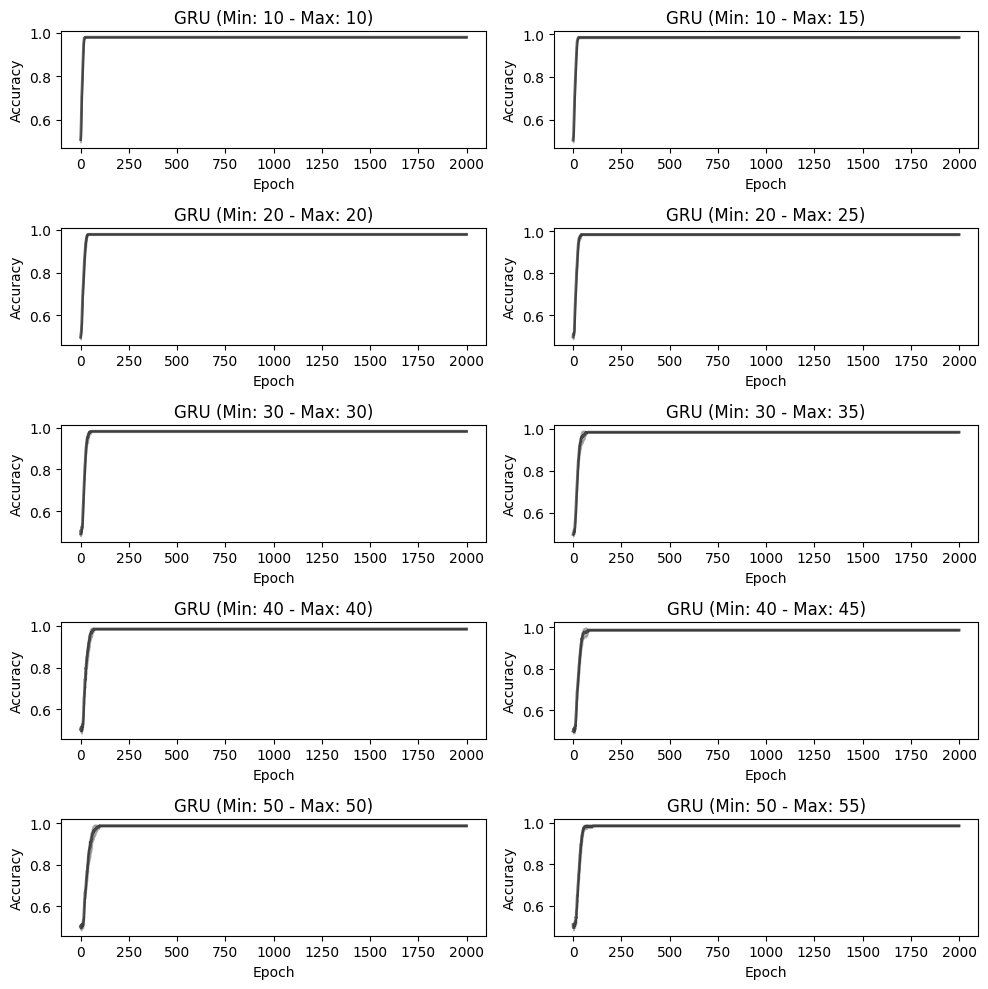

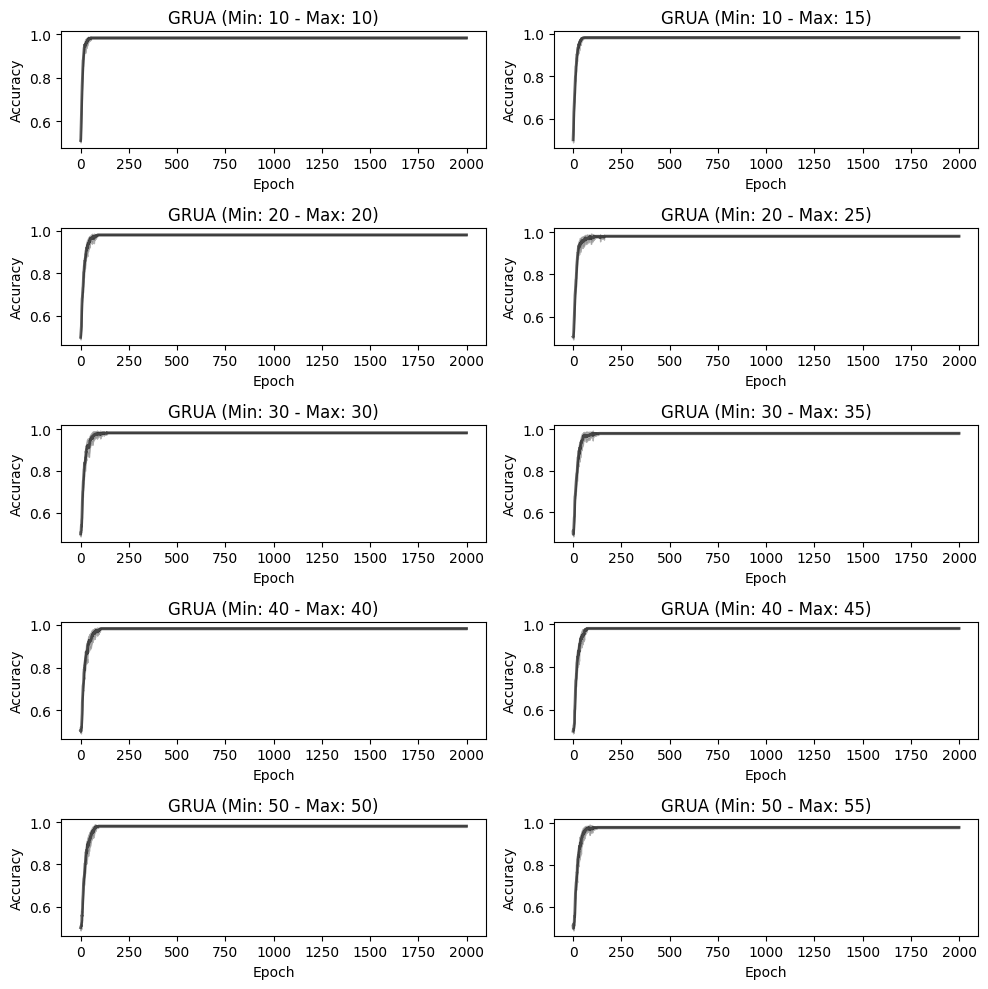

In [59]:
def mean_confidence_interval(data, confidence=0.95):
    data = np.array(data)
    n = len(data)
    m = np.mean(data, axis=0)
    se = scipy.stats.sem(data, axis=0)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def plot_with_grayscale_fill_between(kind, min_lengths, max_lengths, num_reps, target_epoch):
    plt.figure(figsize=(10, 10))  # Adjust the figure size for layout

    for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
        ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

        rep_data = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                if should_skip:
                    skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                    continue
                if padded_data is not None:
                    rep_data.append(padded_data)
            except FileNotFoundError:
                continue

        if not rep_data:
            continue

        # Calculate the mean and confidence intervals for each epoch
        avg_data, lower_bound, upper_bound = mean_confidence_interval(rep_data, confidence=0.95)

        # Plot confidence interval as fill_between
        ax.fill_between(range(target_epoch), lower_bound, upper_bound, color='gray', alpha=0.6)

        # Plot average as a black line
        ax.plot(avg_data, label="Average", linewidth=2, color='black', alpha=0.6)

        ax.set_title(f"{kind} (Min: {min_len} - Max: {max_len})")
        ax.set_ylabel("Accuracy")
        ax.set_xlabel("Epoch")

    plt.tight_layout()
    plt.show()

# Plotting for each kind
for kind in kinds:
    plot_with_grayscale_fill_between(kind, min_lengths, max_lengths, num_reps, target_epoch)


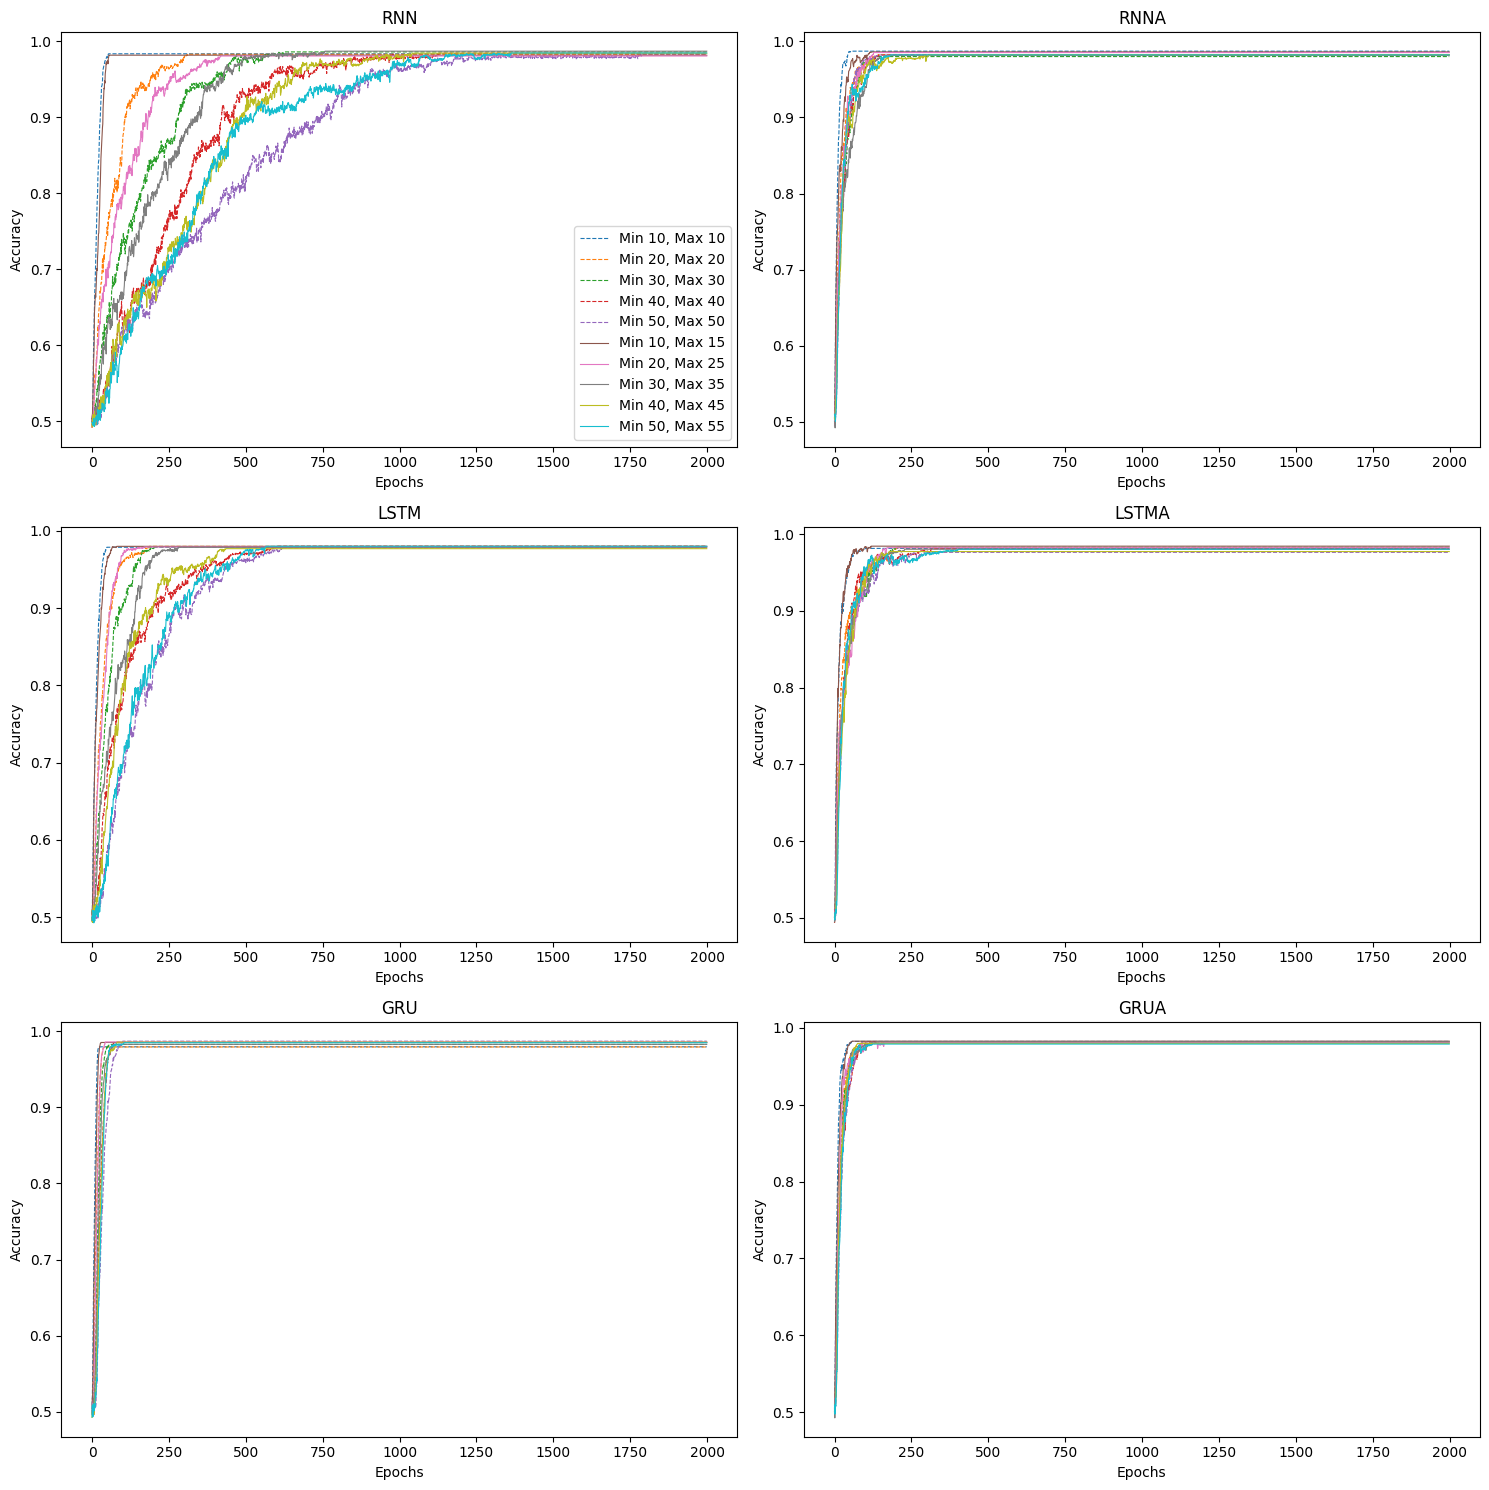

In [60]:
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 20, 30, 40, 50, 10, 20, 30, 40, 50]
max_lengths = [10, 20, 30, 40, 50, 15, 25, 35, 45, 55]
num_reps = 31
target_epoch = 2000
skipped_models = []

# Create a single figure for the plots
plt.figure(figsize=(15, 15))

for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)  # Create subplots in a 3x2 grid

    for j, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
        combination_avg_data = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                if should_skip:
                    skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                    continue
                if padded_data is not None:
                    combination_avg_data.append(padded_data)
            except FileNotFoundError:
                continue

        if combination_avg_data:
            avg_data = np.mean(np.array(combination_avg_data), axis=0)
            line_style = '--' if min_len == max_len else '-'
            ax.plot(avg_data, label=f"Min {min_len}, Max {max_len}", linewidth=0.8, linestyle=line_style)

    ax.set_title(f"{kind}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    if i == 0:  # Add legend only to the first subplot
        ax.legend()

plt.tight_layout()
plt.show()


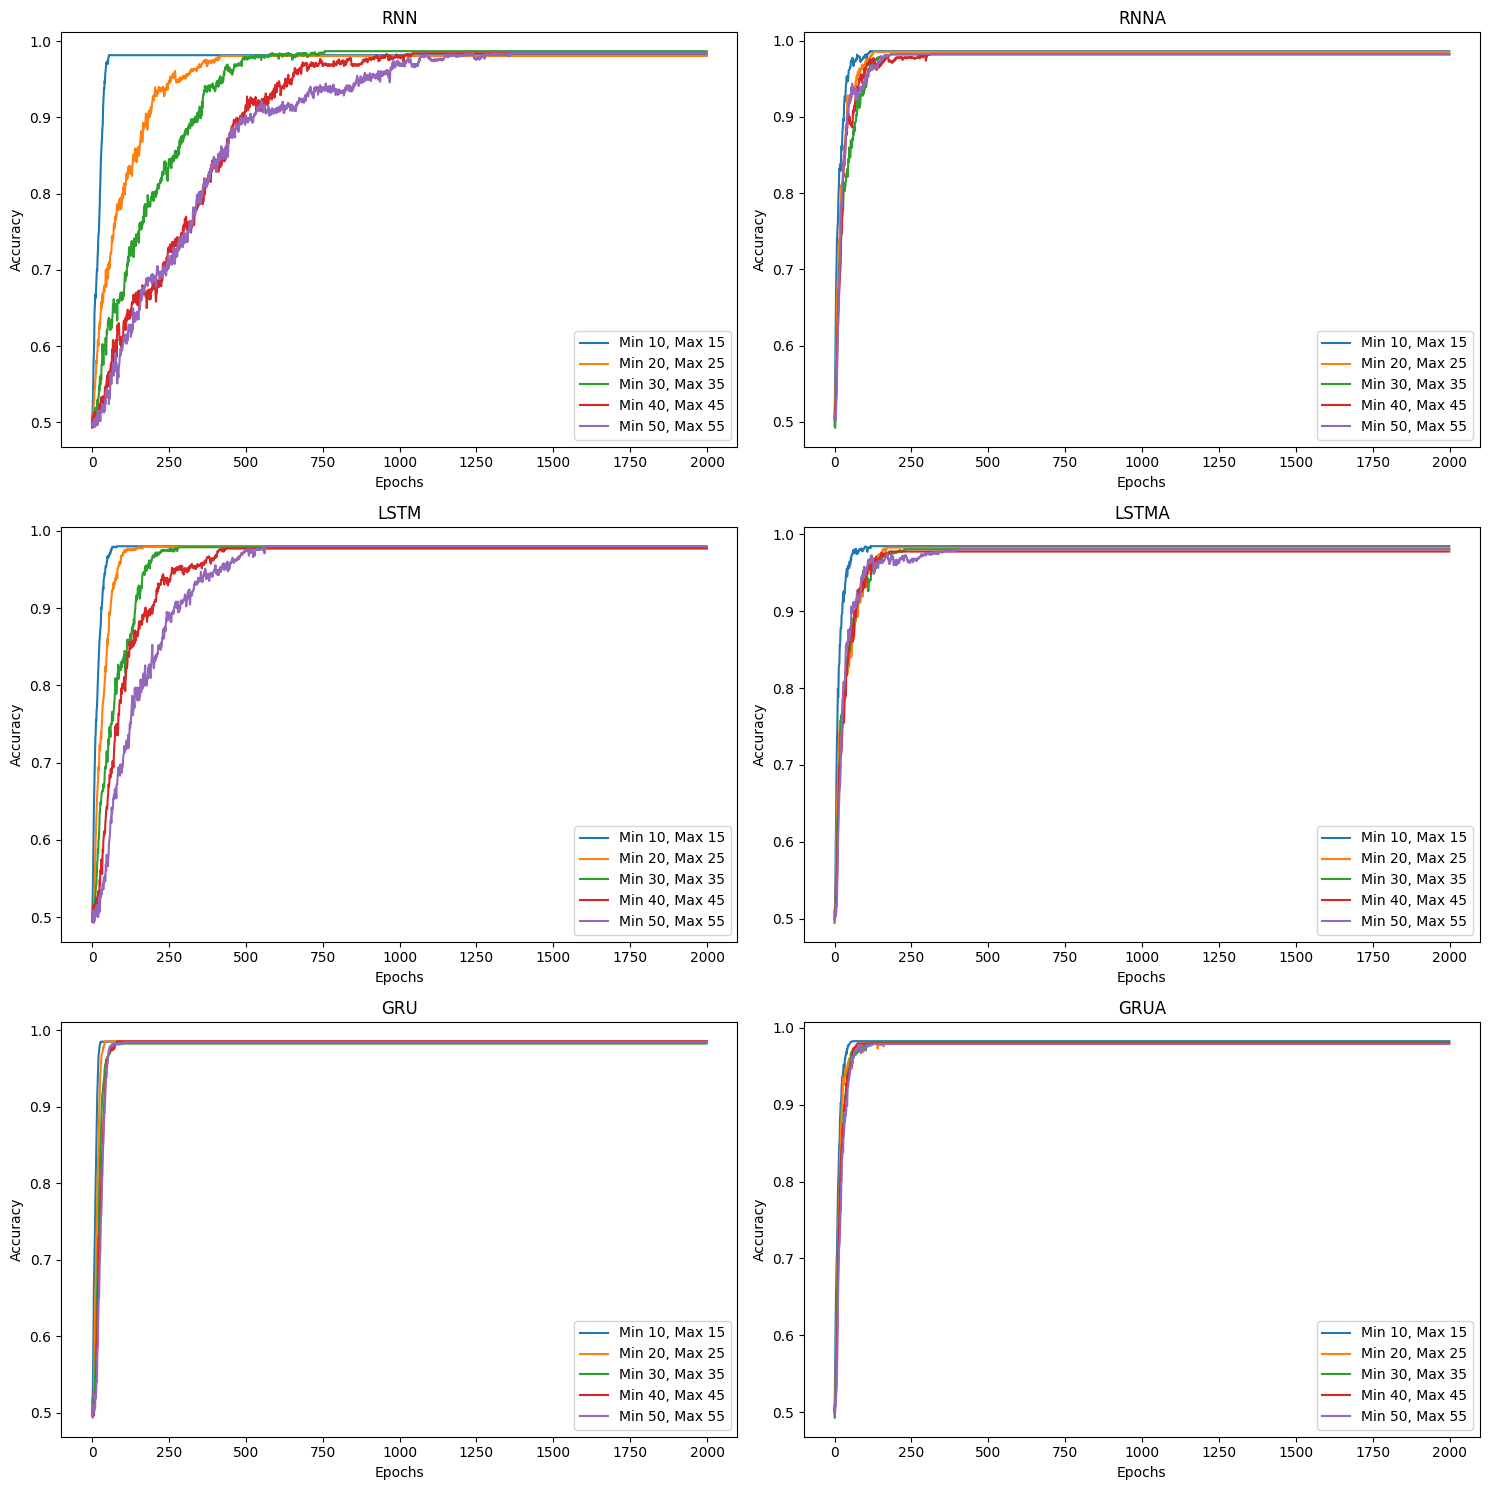

In [166]:
#kinds = ["RNN", "RNNA", "RNNE", "LSTM", "LSTMA", "LSTME", "GRU", "GRUA", "GRUE"]
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 20, 30, 40, 50]  # Adjusted values
max_lengths = [15, 25, 35, 45, 55]  # Adjusted values
num_reps = 31  # Number of repetitions
target_epoch = 2000  # Target number of epochs
skipped_models = []

# Create a single figure for the 3x3 grid
plt.figure(figsize=(15, 15))

for i, kind in enumerate(kinds):
    ax = plt.subplot(3,2, i + 1)  # Create subplots in a 3x3 grid

    for min_len, max_len in zip(min_lengths, max_lengths):
        combination_avg_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                if should_skip:
                    skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                    continue
                if padded_data is not None:
                    combination_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if combination_avg_data:
            # Calculate the average for this min/max length combination
            avg_data = np.mean(np.array(combination_avg_data), axis=0)
            ax.plot(avg_data, label=f"Min {min_len}, Max {max_len}")

    ax.set_title(f"{kind}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()




C:\Users\ahmad\AppData\Local\Temp\ipykernel_4376\2324519471.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blue_cmap = plt.cm.get_cmap('Blues')
C:\Users\ahmad\AppData\Local\Temp\ipykernel_4376\2324519471.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  red_cmap = plt.cm.get_cmap('Reds')


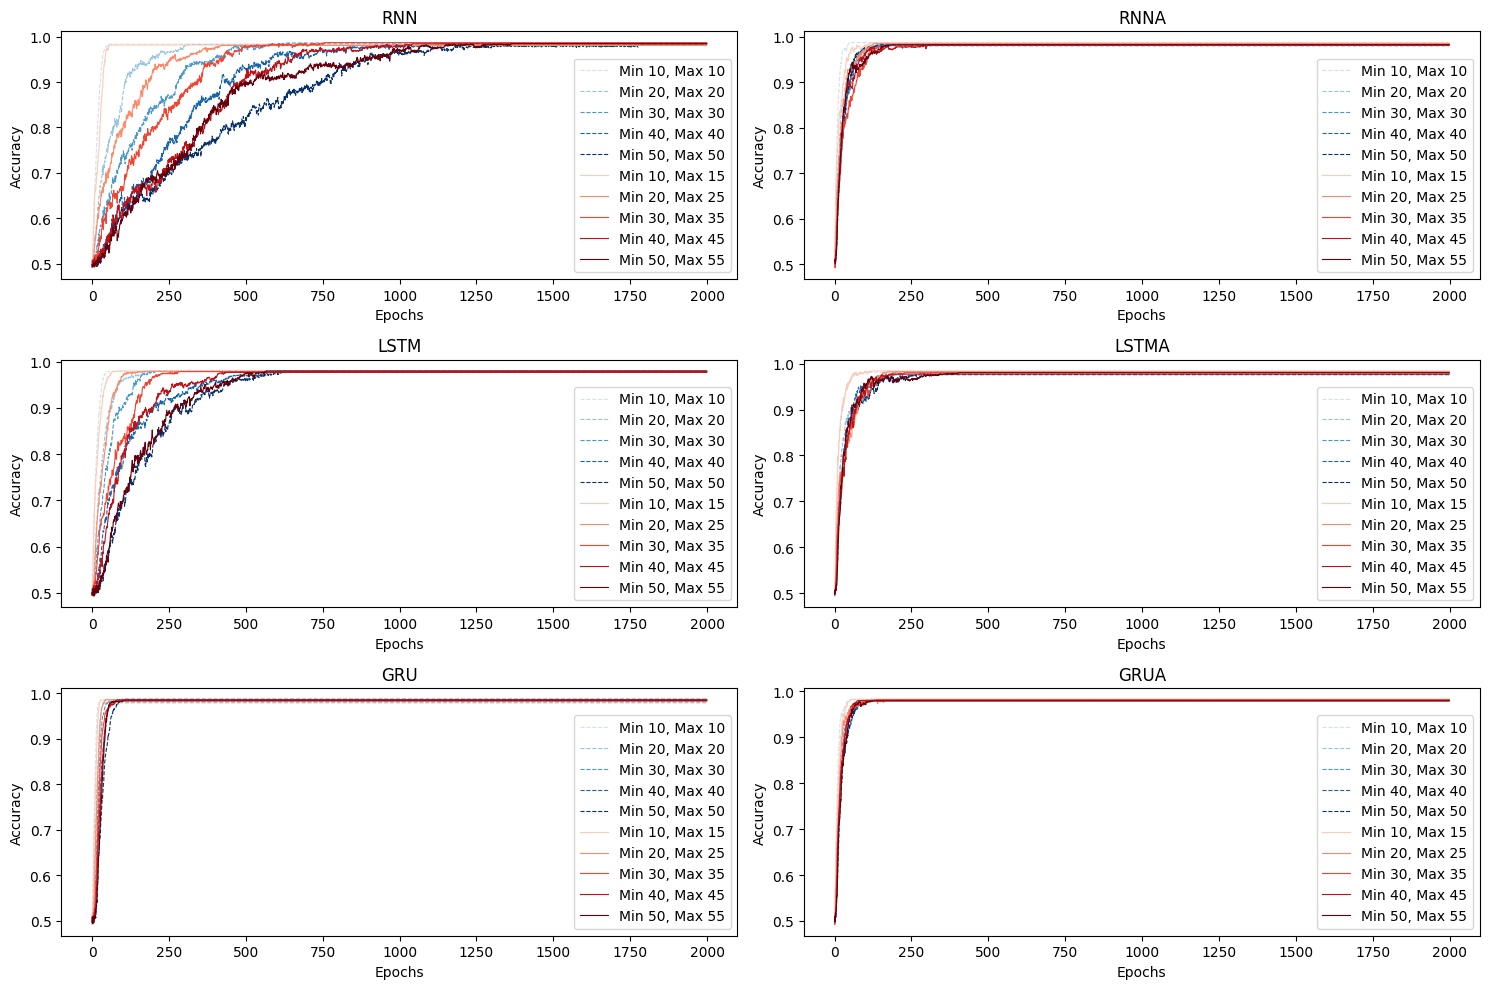

In [61]:
# Kinds, lengths, repetitions, and other parameters as provided
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 20, 30, 40, 50, 10, 20, 30, 40, 50]
max_lengths = [10, 20, 30, 40, 50, 15, 25, 35, 45, 55]
num_reps = 31
target_epoch = 2000
skipped_models = []

# Create a single figure for the 3x3 grid (adjusted to 3x2 as per the kinds list)
plt.figure(figsize=(15, 10))

# Define color maps for blue and red spectrums
blue_cmap = plt.cm.get_cmap('Blues')
red_cmap = plt.cm.get_cmap('Reds')

for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)  # Create subplots in a 3x2 grid

    for min_len, max_len in zip(min_lengths, max_lengths):
        combination_avg_data = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                if should_skip:
                    skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                    continue
                if padded_data is not None:
                    combination_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if combination_avg_data:
            avg_data = np.mean(np.array(combination_avg_data), axis=0)
            if min_len == max_len:
                # Dashed line - Spectrum of blue
                color = blue_cmap(min_len / 50)  # Normalize to get a color from the blue spectrum
                line_style = '--'
            else:
                # Solid line - Spectrum of red
                color = red_cmap(min_len / 50)  # Normalize to get a color from the red spectrum
                line_style = '-'
            
            ax.plot(avg_data, label=f"Min {min_len}, Max {max_len}", linewidth=0.8, linestyle=line_style, color=color)

    ax.set_title(f"{kind}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()

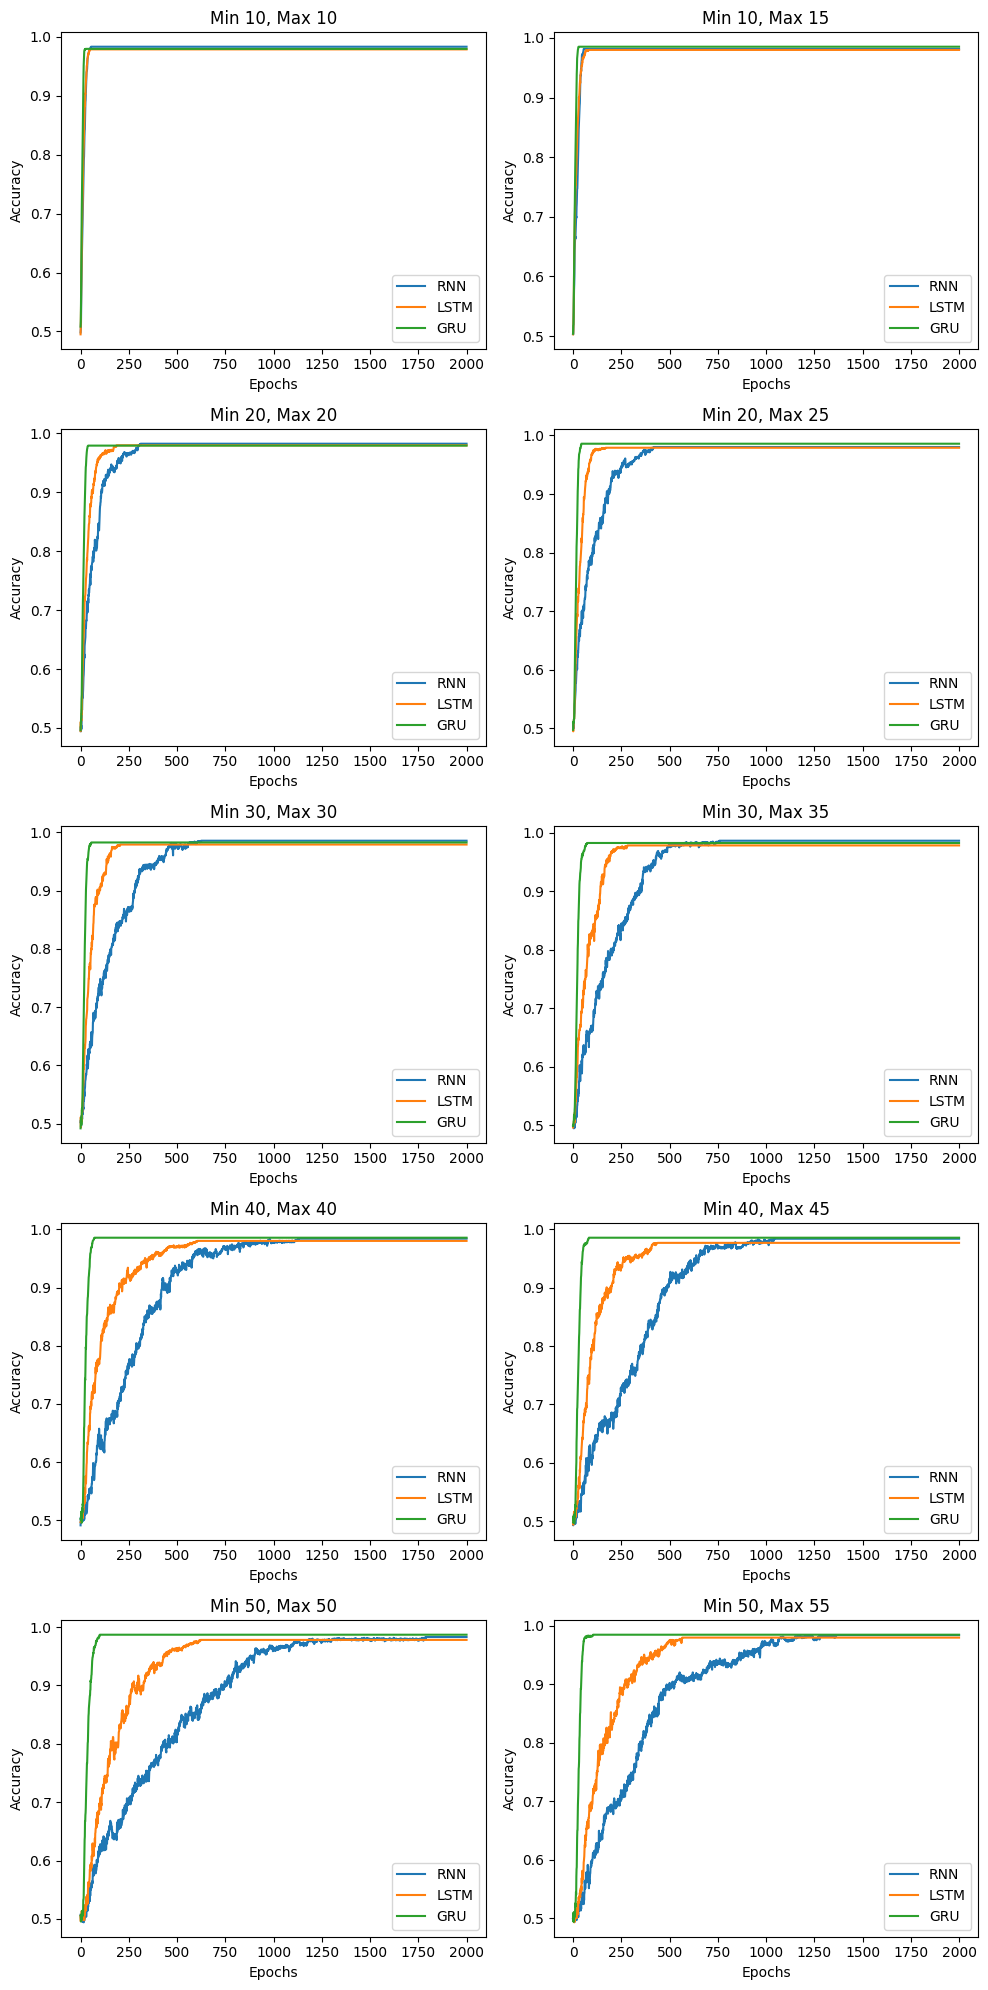

In [62]:
kinds = ["RNN", "LSTM","GRU"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000
skipped_models = []

# Create a single figure for the 2x5 grid
plt.figure(figsize=(10, 20))

for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

    for kind in kinds:
        model_avg_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                if should_skip:
                    skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                    continue
                if padded_data is not None:
                    model_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if model_avg_data:
            # Calculate the average for this model kind
            avg_data = np.mean(np.array(model_avg_data), axis=0)
            ax.plot(avg_data, label=f"{kind}")

    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


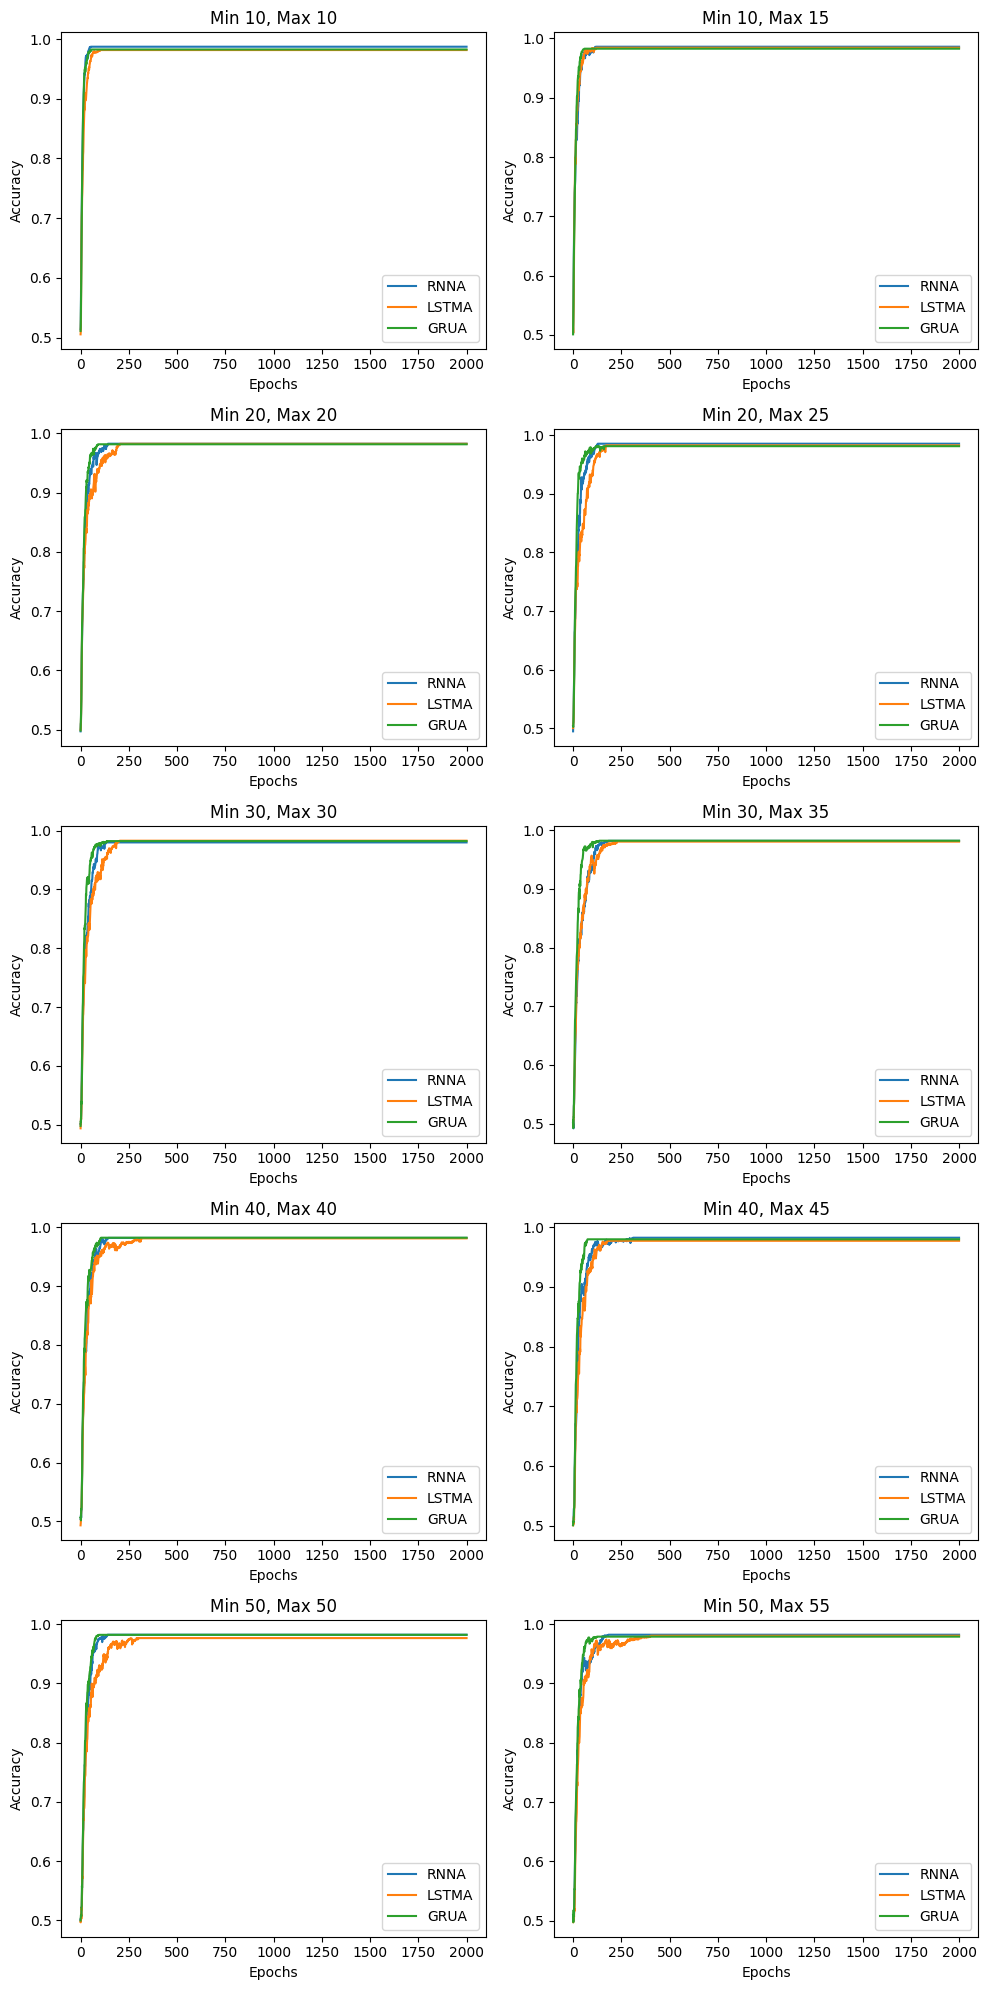

In [64]:
kinds = ["RNNA", "LSTMA",  "GRUA"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000
skipped_models = []

# Create a single figure for the 2x5 grid
plt.figure(figsize=(10, 20))

for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

    for kind in kinds:
        model_avg_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                if should_skip:
                    skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                    continue
                if padded_data is not None:
                    model_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if model_avg_data:
            # Calculate the average for this model kind
            avg_data = np.mean(np.array(model_avg_data), axis=0)
            ax.plot(avg_data, label=f"{kind}")

    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
kinds = ["RNNE", "LSTME", "GRUE"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000
skipped_models = []

# Create a single figure for the 2x5 grid
plt.figure(figsize=(10, 20))

for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

    for kind in kinds:
        model_avg_data = []

        for rep in range(num_reps):
            filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                if should_skip:
                    skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                    continue
                if padded_data is not None:
                    model_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if model_avg_data:
            # Calculate the average for this model kind
            avg_data = np.mean(np.array(model_avg_data), axis=0)
            ax.plot(avg_data, label=f"{kind}")

    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


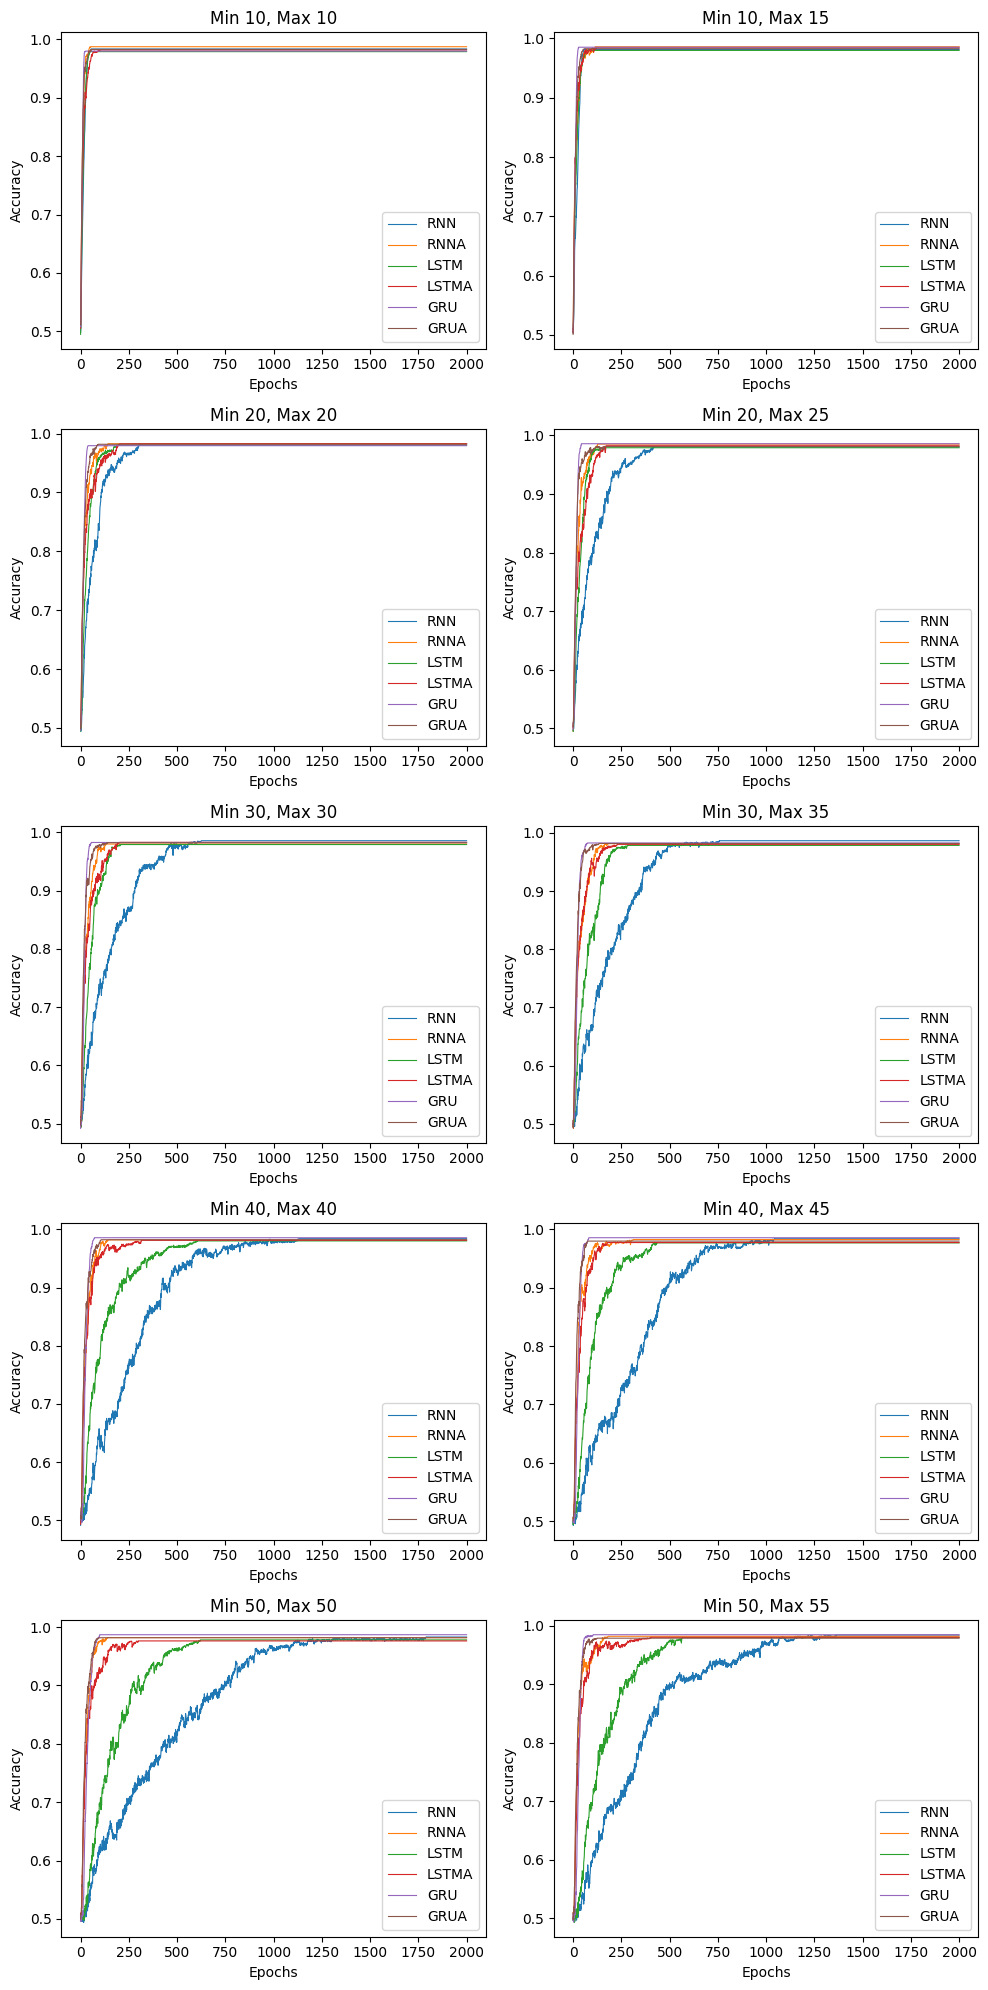

In [66]:
#kinds = ["RNN", "RNNA", "RNNE", "LSTM", "LSTMA", "LSTME", "GRU", "GRUA", "GRUE"]
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000
skipped_models = []

# Create a single figure for the 2x5 grid
plt.figure(figsize=(10, 20))

for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

    for kind in kinds:
        model_avg_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                if should_skip:
                    skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                    continue
                if padded_data is not None:
                    model_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if model_avg_data:
            # Calculate the average for this model kind
            avg_data = np.mean(np.array(model_avg_data), axis=0)
            ax.plot(avg_data, label=f"{kind}", linewidth= 0.8)

    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


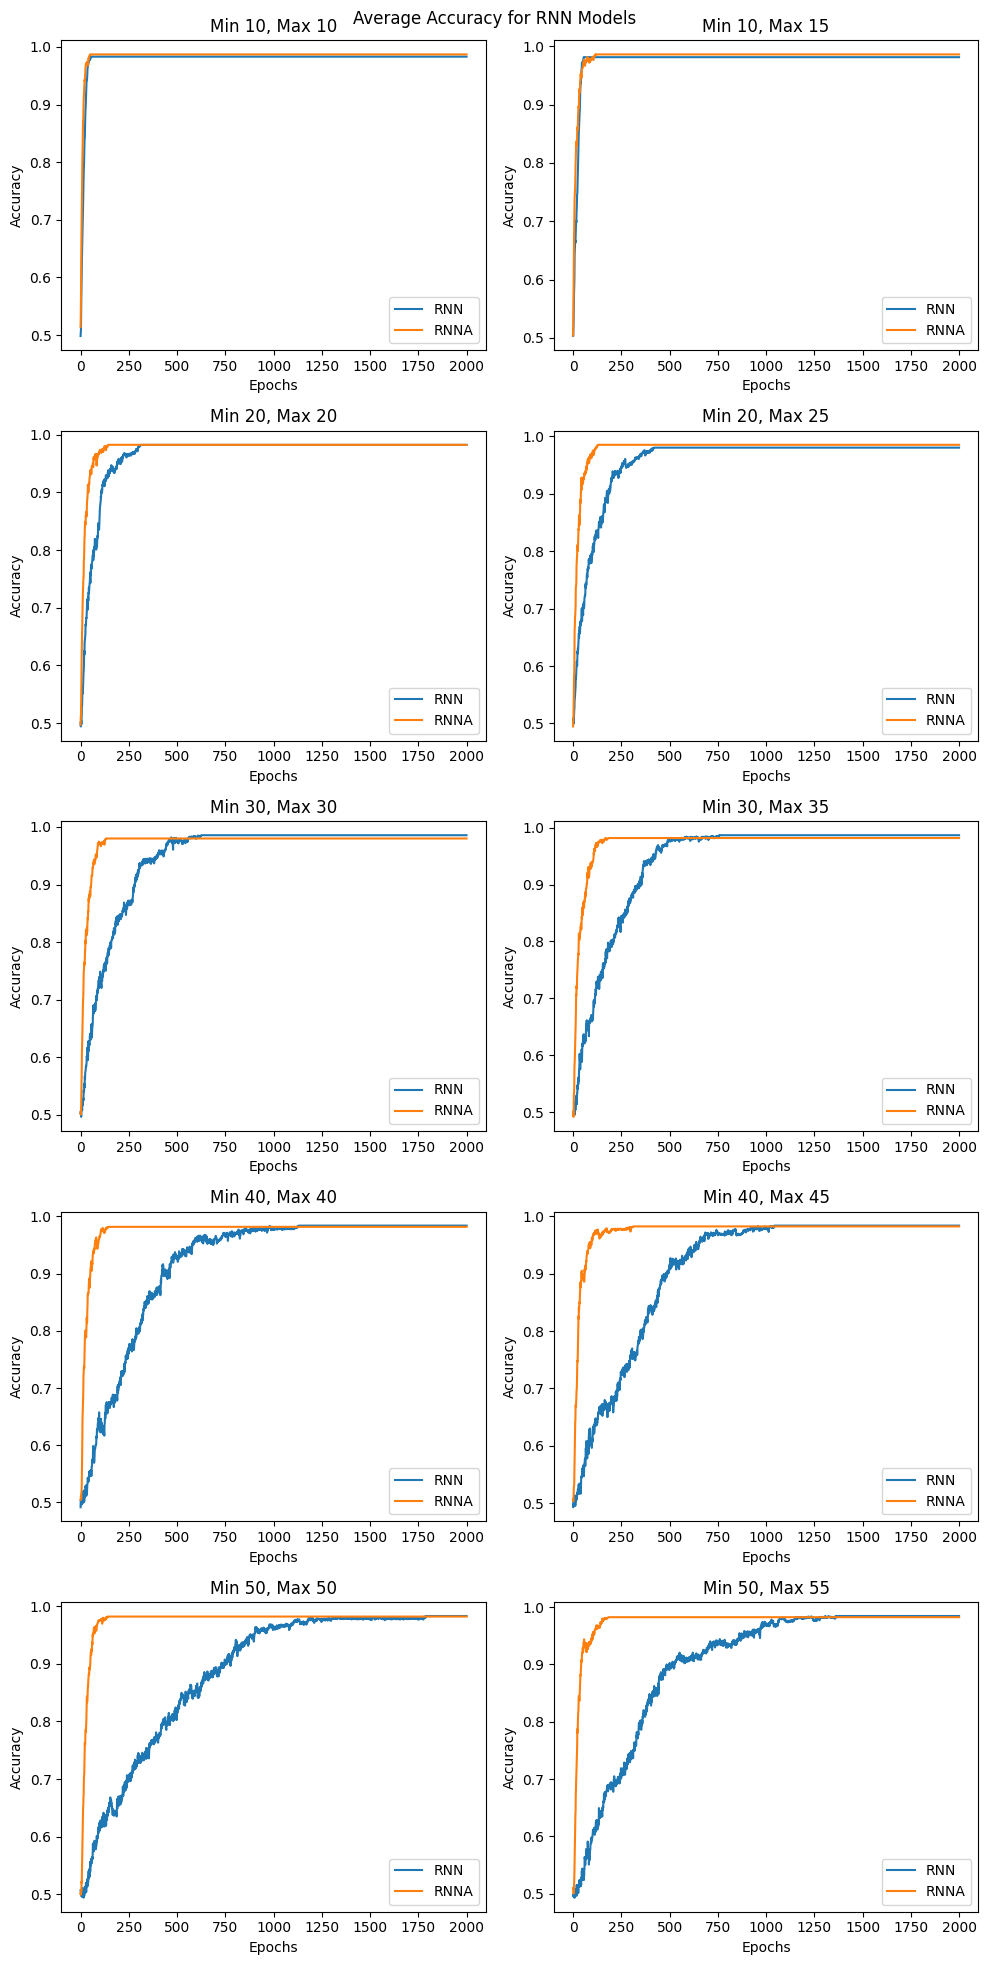

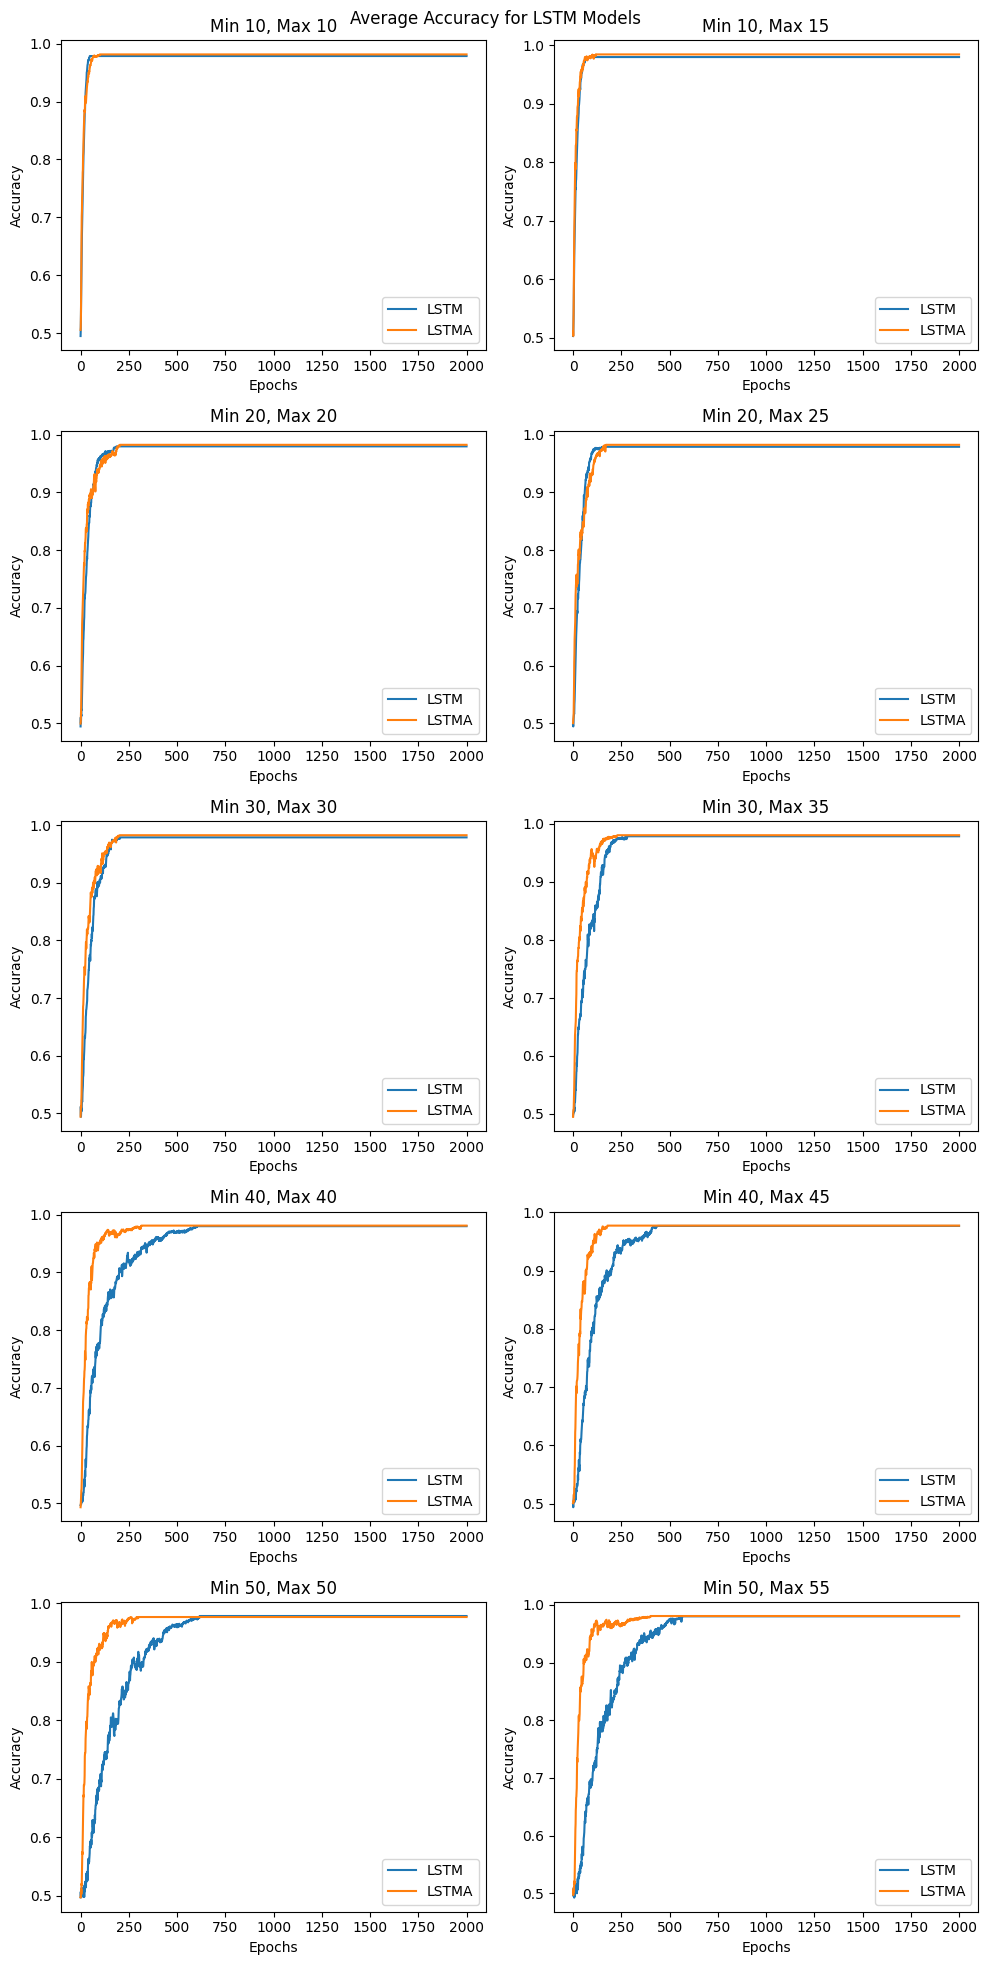

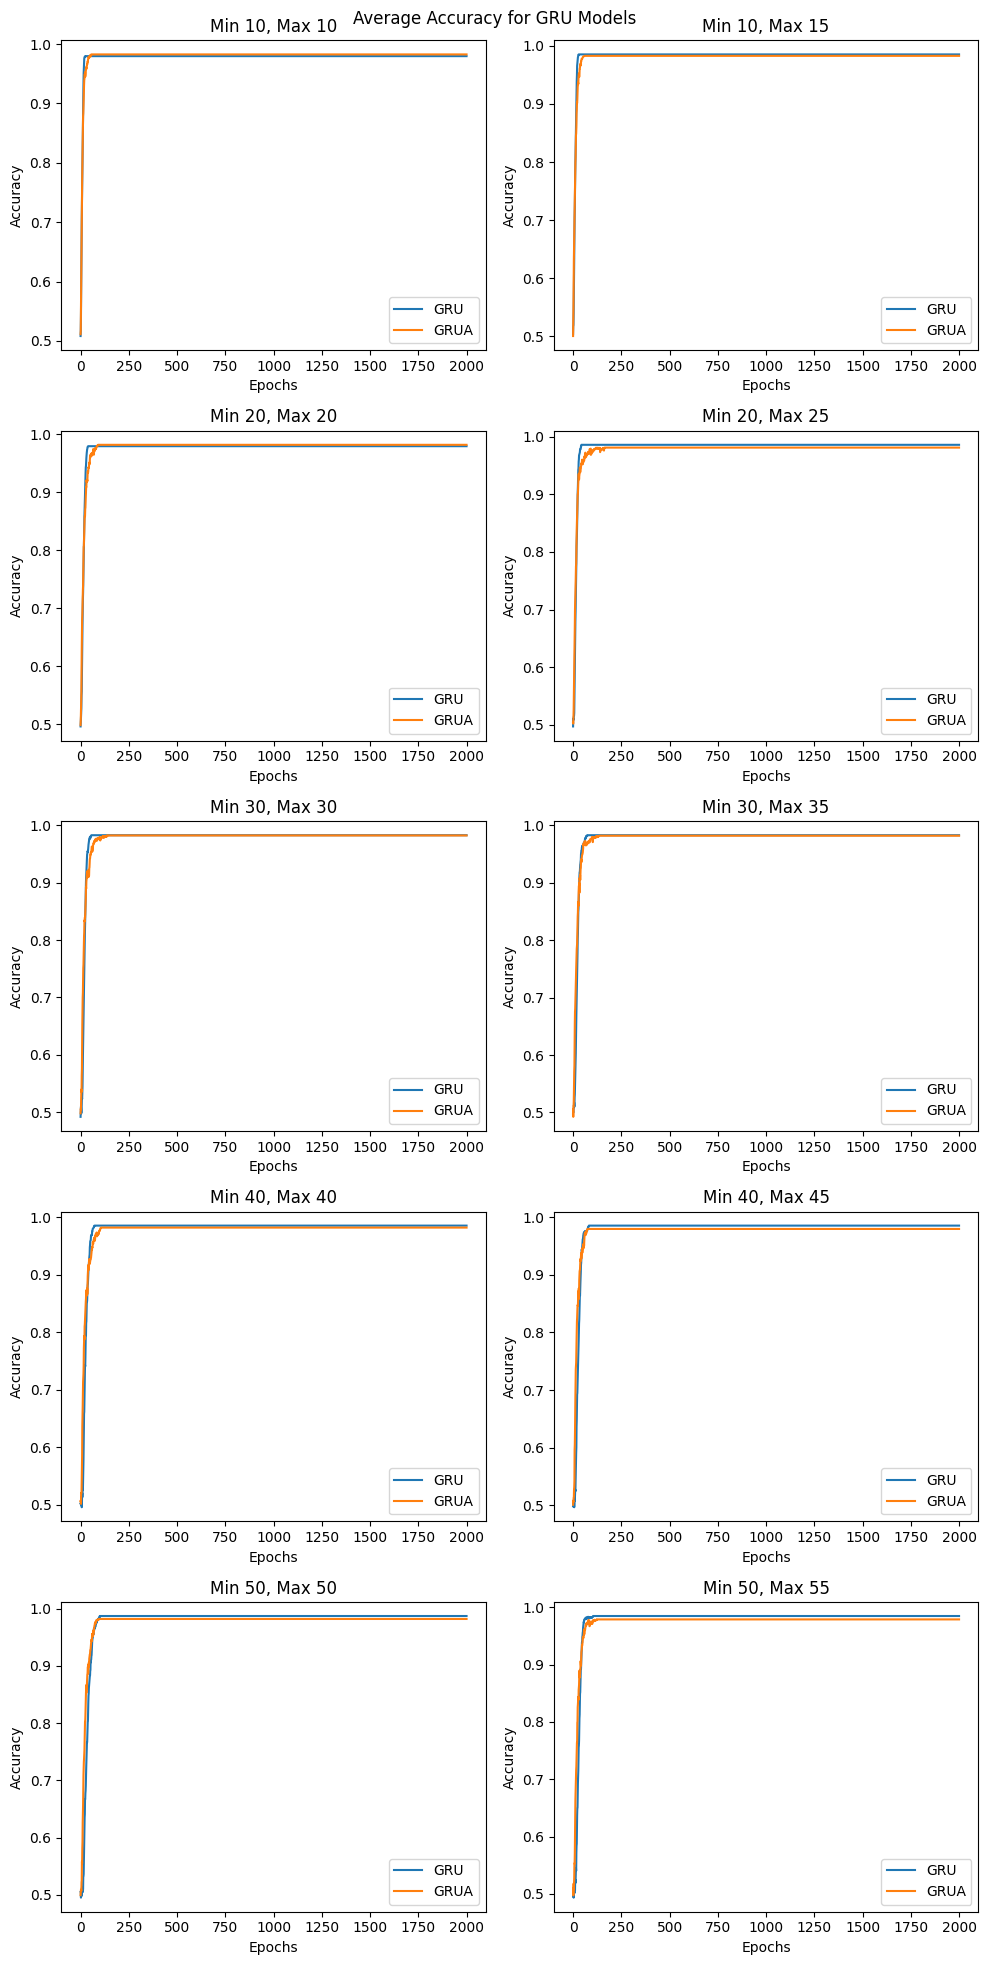

In [67]:
#model_groups = {
#    "RNN": ["RNN", "RNNA", "RNNE"],
#    "LSTM": ["LSTM", "LSTMA", "LSTME"],
#    "GRU": ["GRU", "GRUA", "GRUE"]
#}

model_groups = {
    "RNN": ["RNN", "RNNA"],
    "LSTM": ["LSTM", "LSTMA"],
    "GRU": ["GRU", "GRUA"]
}

min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000
skipped_models = []

# Plotting for each model group
for group_name, kinds in model_groups.items():
    plt.figure(figsize=(10, 20))  # Create a single figure for the 2x5 grid

    for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
        ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

        for kind in kinds:
            kind_avg_data = []

            for rep in range(num_reps):
                #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
                filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
                try:
                    padded_data, should_skip = read_and_process_csv(filename, target_epoch, tensor_str_to_float, skip_condition)
                    if should_skip:
                        skipped_models.append(f'{kind}_min_{min_len}_max_{max_len}_rep_{rep}')
                        continue
                    if padded_data is not None:
                        kind_avg_data.append(padded_data)
                except FileNotFoundError:
                    print(f"File not found: {filename}")
                    continue

            if kind_avg_data:
                # Calculate the average for this kind and length combination
                avg_data = np.mean(np.array(kind_avg_data), axis=0)
                ax.plot(avg_data, label=f"{kind}")

        ax.set_title(f"Min {min_len}, Max {max_len}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Accuracy")
        ax.legend()

    plt.suptitle(f"Average Accuracy for {group_name} Models")
    plt.tight_layout()
    plt.show()


# Bar plots


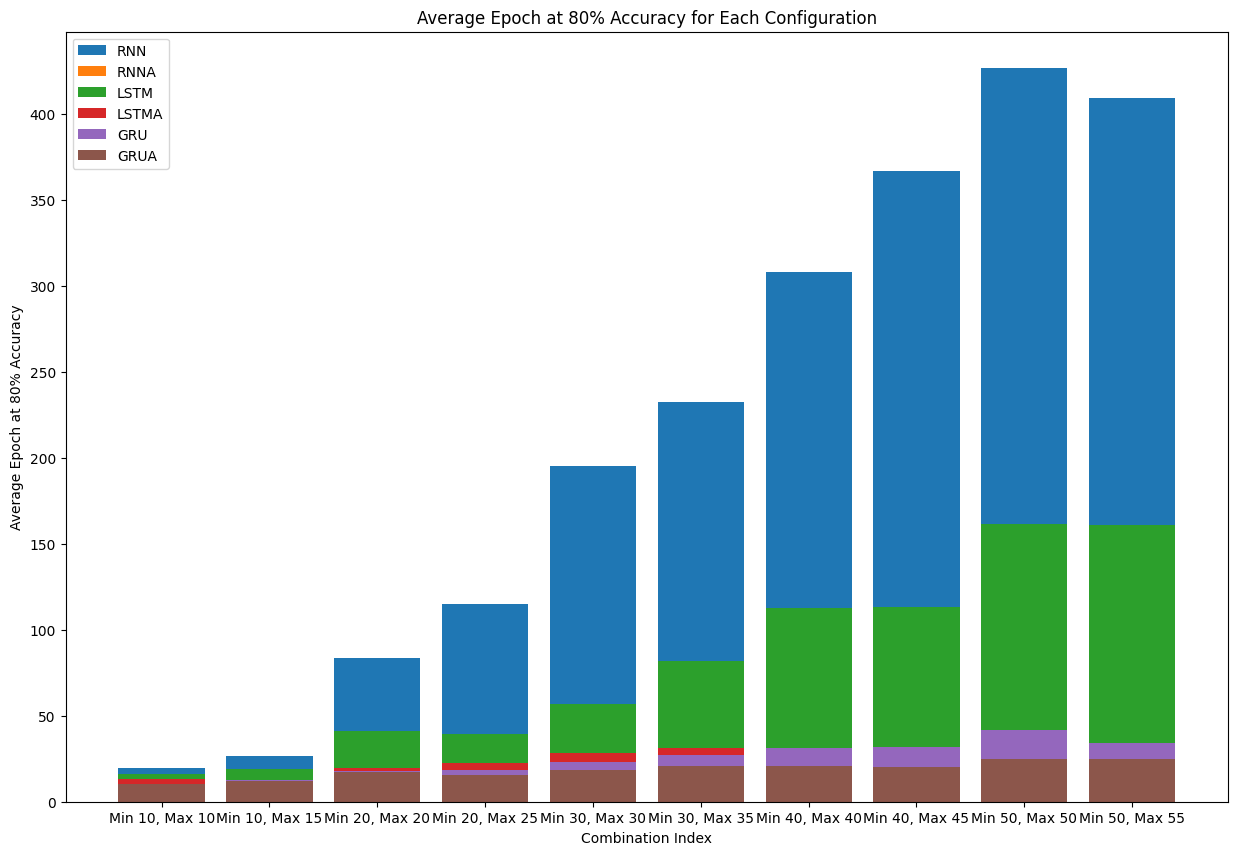

In [68]:
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]

# Placeholder for the results
results = []
labels = []

for kind in kinds:
    for min_len, max_len in zip(min_lengths, max_lengths):
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                if skip_condition(data):
                    continue
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            results.append((kind, min_len, max_len, avg_epoch))
            labels.append(f"Min {min_len}, Max {max_len}")


# Preparing data for bar plot
df = pd.DataFrame(results, columns=["Kind", "Min_Length", "Max_Length", "Avg_Epoch"])

# Plotting
plt.figure(figsize=(15, 10))

for i, kind in enumerate(kinds):
    subset = df[df['Kind'] == kind]
    x = range(len(subset))
    plt.bar(x, subset['Avg_Epoch'], tick_label=labels[len(x)*i:len(x)*(i+1)],label=f"{kind}")

plt.xlabel("Combination Index")
plt.ylabel("Average Epoch at 80% Accuracy")
plt.title("Average Epoch at 80% Accuracy for Each Configuration")
plt.legend()
plt.show()

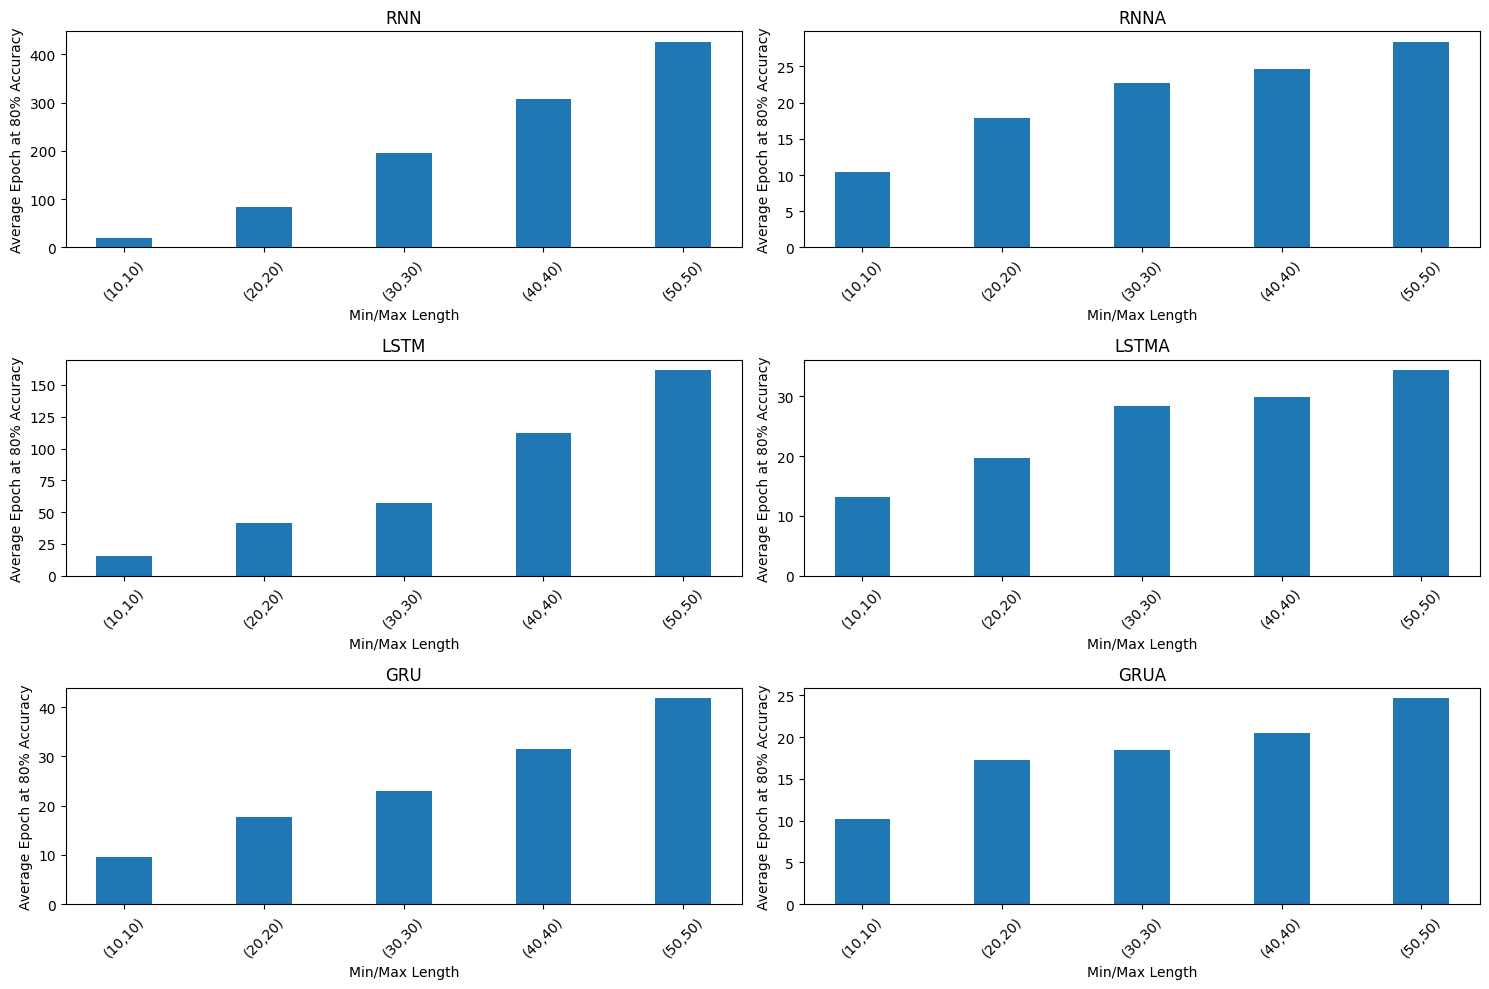

In [69]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10 ,20, 30, 40, 50]
max_lengths = [10 ,20, 30, 40, 50]
num_reps = 31
skipped_models = []

# Placeholder for the results
results = []

# Gathering data for the bar plot
for kind in kinds:
    kind_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                if skip_condition(data):
                    continue
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            kind_results.append(avg_epoch)
        else:
            kind_results.append(None)

    results.append(kind_results)

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Create a subplot for each model kind
for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)  # 3x2 grid for 6 kinds
    bar_positions = np.arange(len(min_lengths))  # One bar for each min/max length combination

    # Plot the bars
    ax.bar(bar_positions, results[i], width=0.4)

    # Set up the plot
    ax.set_title(kind)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")

plt.tight_layout()
plt.show()

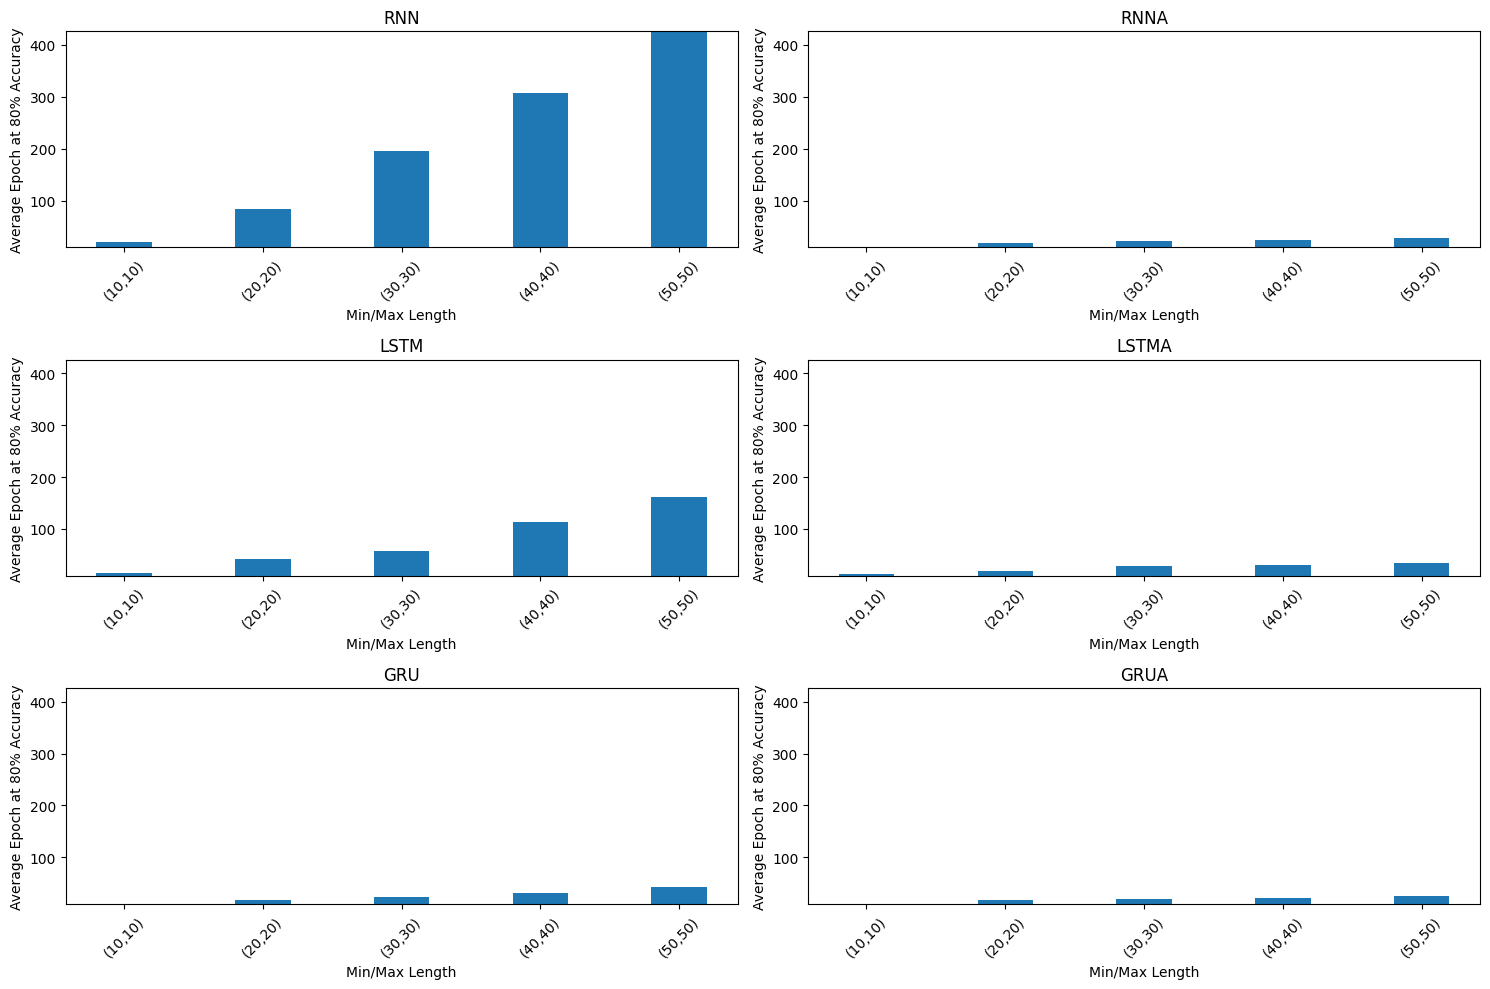

In [70]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 20, 30, 40, 50]
max_lengths = [10, 20, 30, 40, 50]
num_reps = 31
skipped_models = []

# Placeholder for the results
results = []

# Gathering data for the bar plot
for kind in kinds:
    kind_results = []
    for min_len, max_len in zip(min_lengths, max_lengths):
        epochs_to_80_percent = []
        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            padded_data, skipped = read_and_process_csv(filename, 1000, tensor_str_to_float, skip_condition)
            if padded_data is not None:
                epoch = find_epoch_at_80_percent(padded_data)
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            if skipped:
                skipped_models.append((kind, min_len, max_len, rep))
        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            kind_results.append(avg_epoch)
        else:
            kind_results.append(None)
    results.append(kind_results)

# Find global min and max for the y-axis scale
all_epochs = [epoch for kind_result in results for epoch in kind_result if epoch is not None]
global_min = min(all_epochs)
global_max = max(all_epochs)

# Creating the bar plot with a consistent y-axis scale
plt.figure(figsize=(15, 10))

for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)
    bar_positions = np.arange(len(min_lengths))
    ax.bar(bar_positions, results[i], width=0.4)
    ax.set_title(kind)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.set_ylim(global_min, global_max)  # Apply consistent scale

plt.tight_layout()
plt.show()

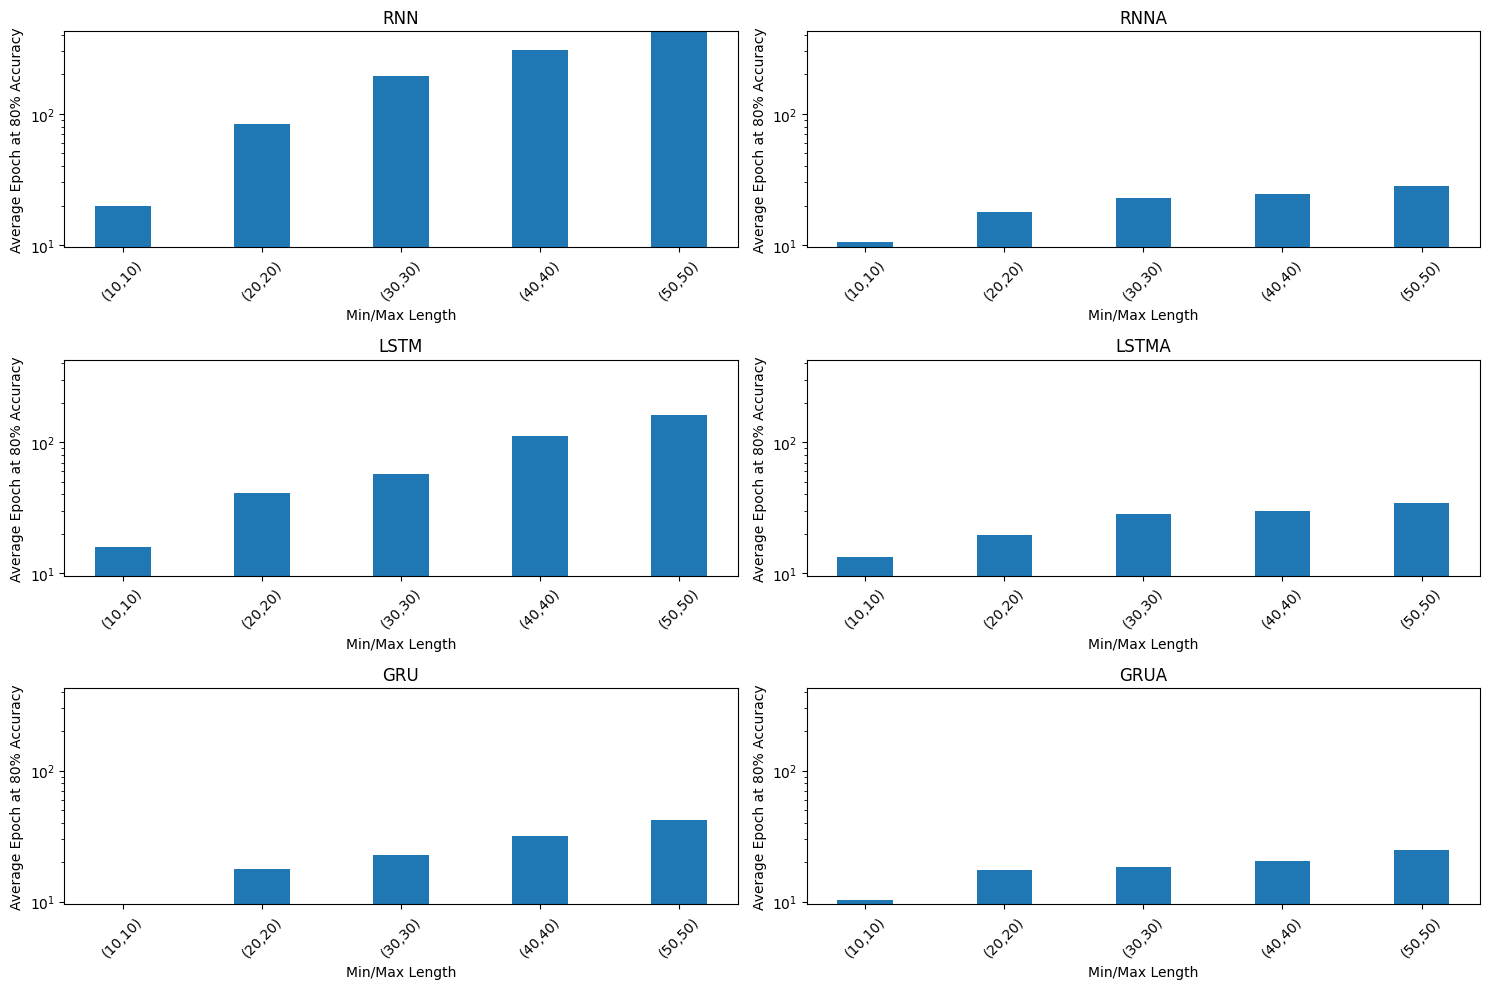

In [71]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 20, 30, 40, 50]
max_lengths = [10, 20, 30, 40, 50]
num_reps = 31
skipped_models = []
# Placeholder for the results
results = []

# Gathering data for the bar plot
for kind in kinds:
    kind_results = []
    for min_len, max_len in zip(min_lengths, max_lengths):
        epochs_to_80_percent = []
        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            padded_data, skipped = read_and_process_csv(filename, 1000, tensor_str_to_float, skip_condition)
            if padded_data is not None:
                epoch = find_epoch_at_80_percent(padded_data)
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            if skipped:
                skipped_models.append((kind, min_len, max_len, rep))
        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            kind_results.append(avg_epoch)
        else:
            kind_results.append(None)
    results.append(kind_results)
# Find global min and max for the logarithmic y-axis scale
all_epochs = [epoch for kind_result in results for epoch in kind_result if epoch is not None]
global_min = min(all_epochs)
global_max = max(all_epochs)

# Creating the bar plot with consistent logarithmic y-axis
plt.figure(figsize=(15, 10))

for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)
    bar_positions = np.arange(len(min_lengths))
    ax.bar(bar_positions, results[i], width=0.4)
    ax.set_title(kind)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")

    # Set the same logarithmic scale for each subplot
    ax.set_yscale('log')
    ax.set_ylim(global_min, global_max)

plt.tight_layout()
plt.show()

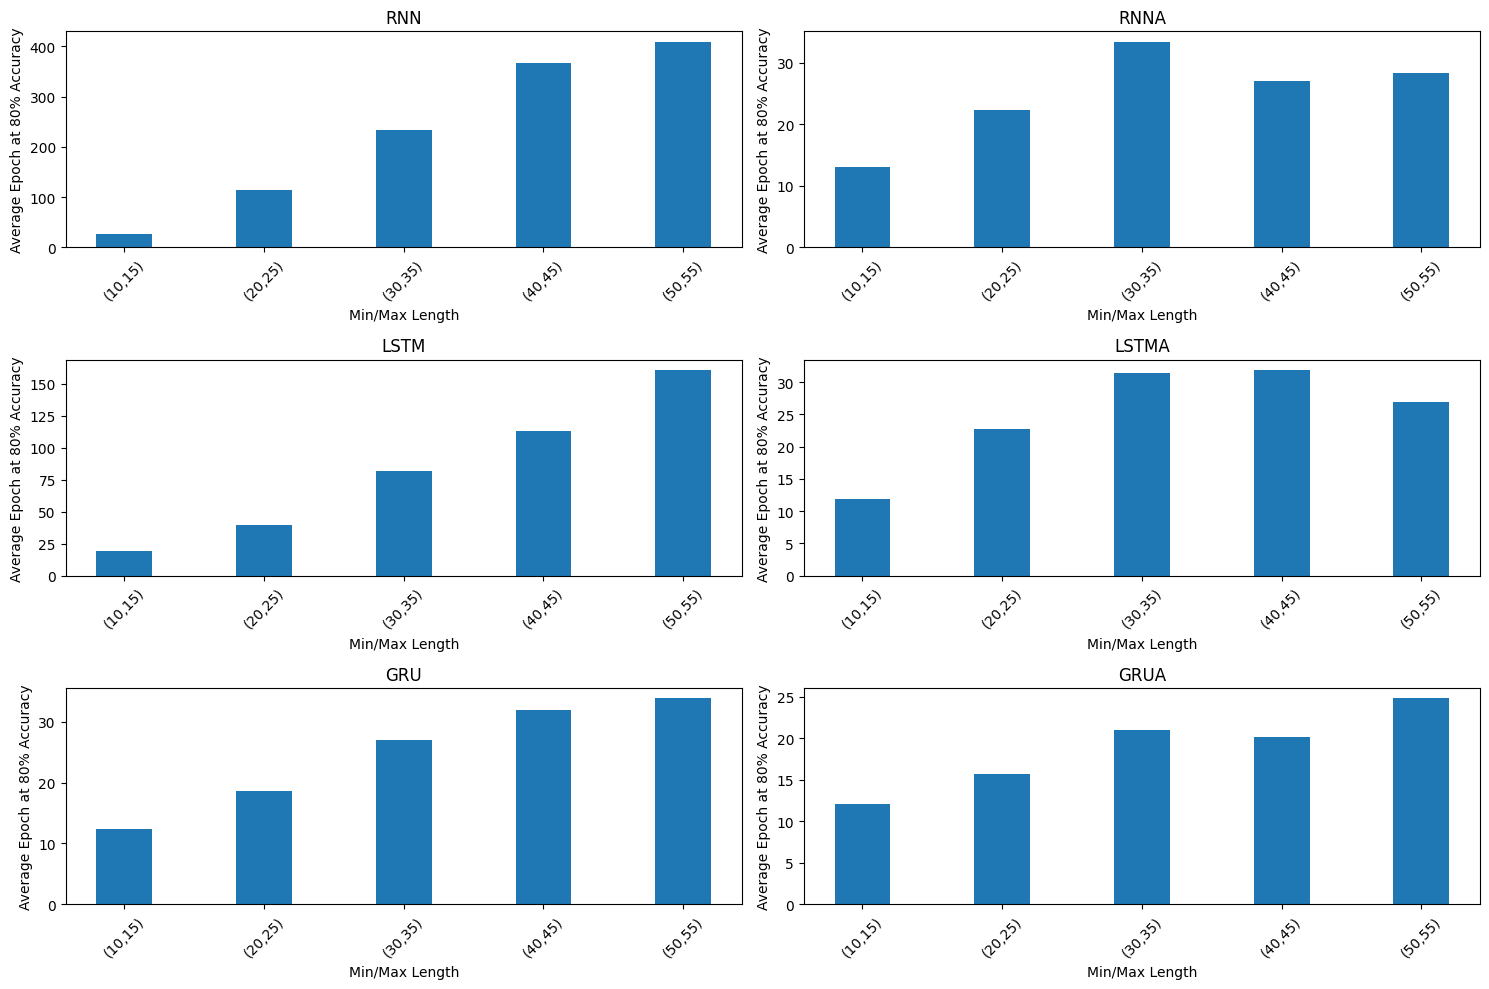

In [72]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10 ,20, 30, 40, 50]
max_lengths = [15 ,25, 35, 45, 55]
num_reps = 31

# Placeholder for the results
results = []

# Gathering data for the bar plot
for kind in kinds:
    kind_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                if skip_condition(data):
                    continue
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            kind_results.append(avg_epoch)
        else:
            kind_results.append(None)

    results.append(kind_results)

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Create a subplot for each model kind
for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)  # 3x2 grid for 6 kinds
    bar_positions = np.arange(len(min_lengths))  # One bar for each min/max length combination

    # Plot the bars
    ax.bar(bar_positions, results[i], width=0.4)

    # Set up the plot
    ax.set_title(kind)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")

plt.tight_layout()
plt.show()

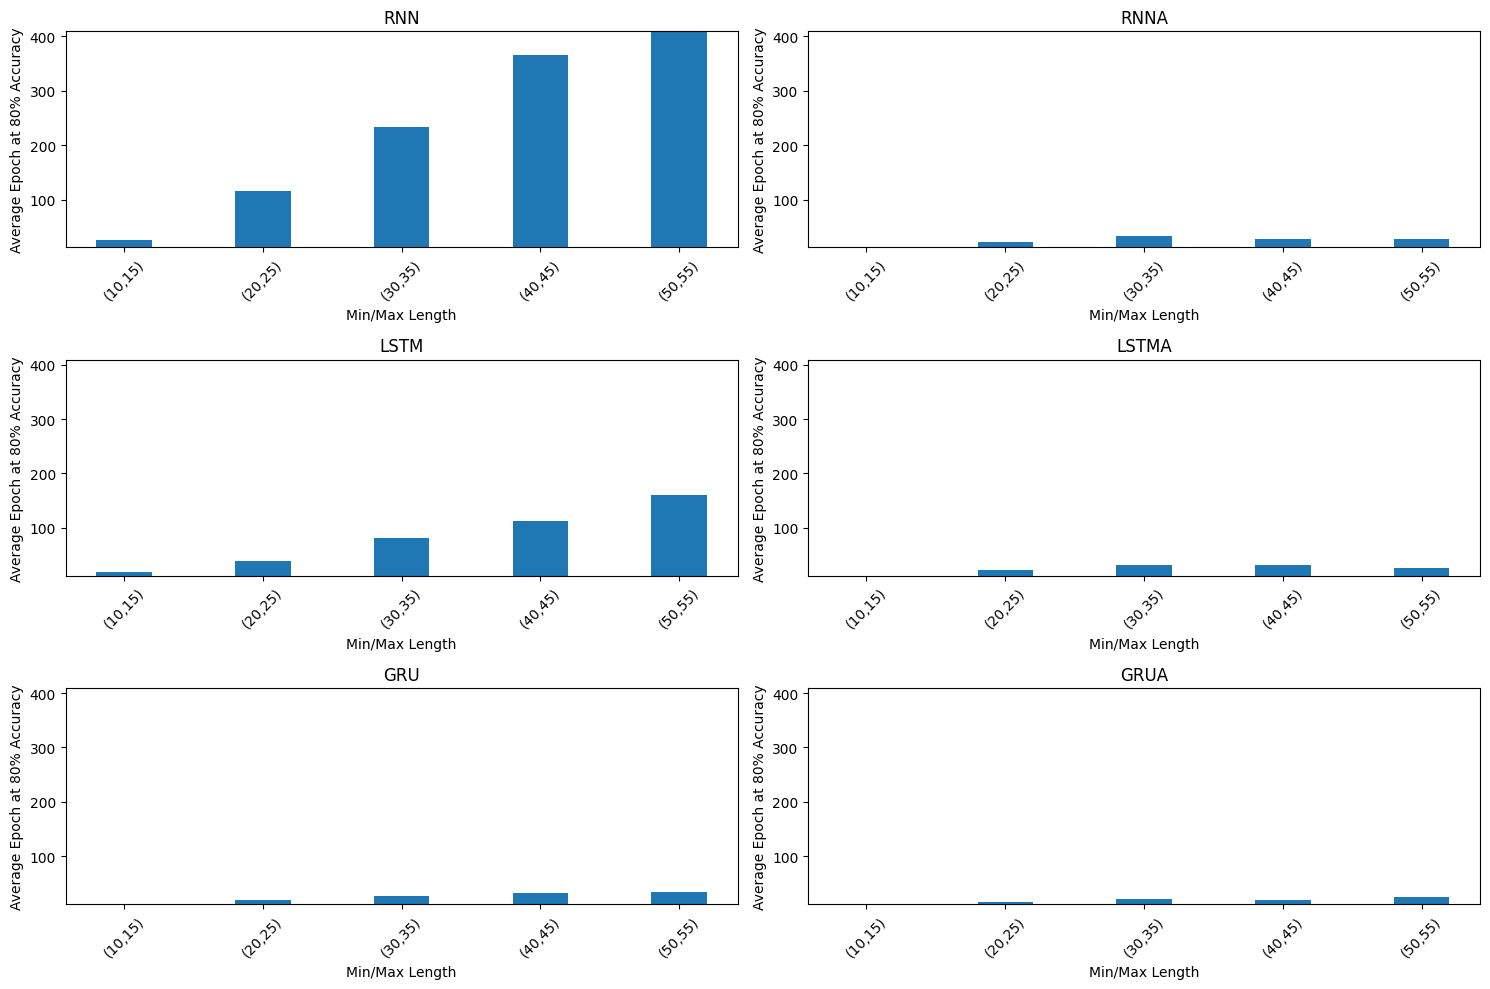

In [73]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10 ,20, 30, 40, 50]
max_lengths = [15 ,25, 35, 45, 55]
num_reps = 31

# Placeholder for the results
results = []

# Gathering data for the bar plot
for kind in kinds:
    kind_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                if skip_condition(data):
                    continue
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            kind_results.append(avg_epoch)
        else:
            kind_results.append(None)

    results.append(kind_results)
# Find global min and max for the y-axis scale
all_epochs = [epoch for kind_result in results for epoch in kind_result if epoch is not None]
global_min = min(all_epochs)
global_max = max(all_epochs)

# Creating the bar plot with a consistent y-axis scale
plt.figure(figsize=(15, 10))

for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)
    bar_positions = np.arange(len(min_lengths))
    ax.bar(bar_positions, results[i], width=0.4)
    ax.set_title(kind)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.set_ylim(global_min, global_max)  # Apply consistent scale

plt.tight_layout()
plt.show()

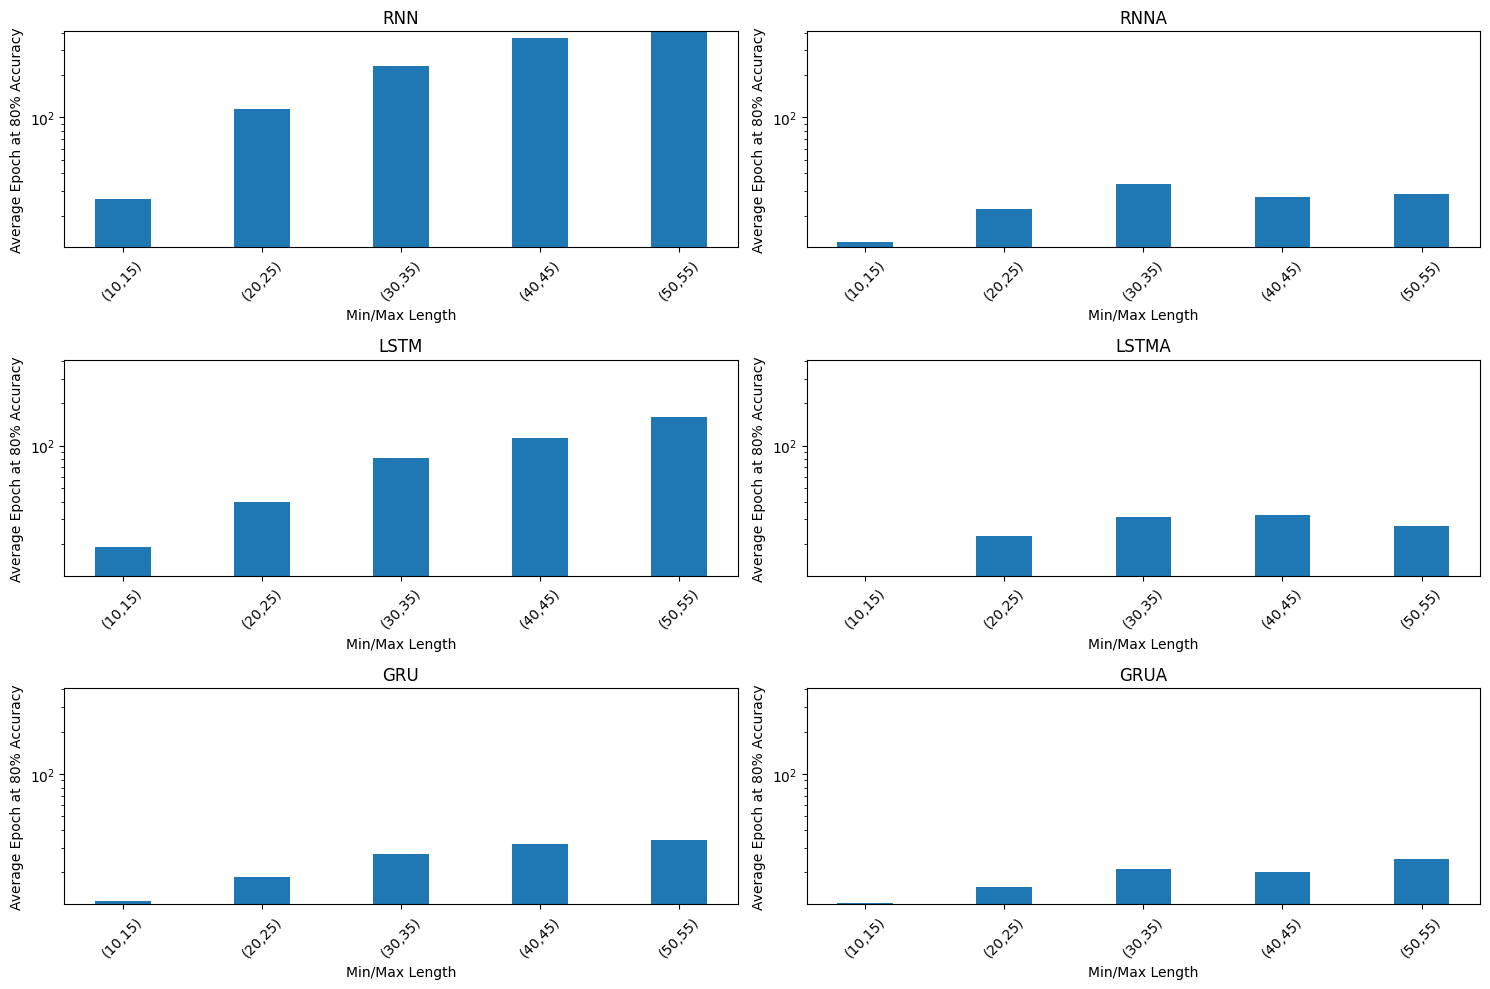

In [74]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10 ,20, 30, 40, 50]
max_lengths = [15 ,25, 35, 45, 55]
num_reps = 31

# Placeholder for the results
results = []

# Gathering data for the bar plot
for kind in kinds:
    kind_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                if skip_condition(data):
                    continue
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            kind_results.append(avg_epoch)
        else:
            kind_results.append(None)

    results.append(kind_results)
# Find global min and max for the logarithmic y-axis scale
all_epochs = [epoch for kind_result in results for epoch in kind_result if epoch is not None]
global_min = min(all_epochs)
global_max = max(all_epochs)

# Creating the bar plot with consistent logarithmic y-axis
plt.figure(figsize=(15, 10))

for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)
    bar_positions = np.arange(len(min_lengths))
    ax.bar(bar_positions, results[i], width=0.4)
    ax.set_title(kind)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")

    # Set the same logarithmic scale for each subplot
    ax.set_yscale('log')
    ax.set_ylim(global_min, global_max)

plt.tight_layout()
plt.show()

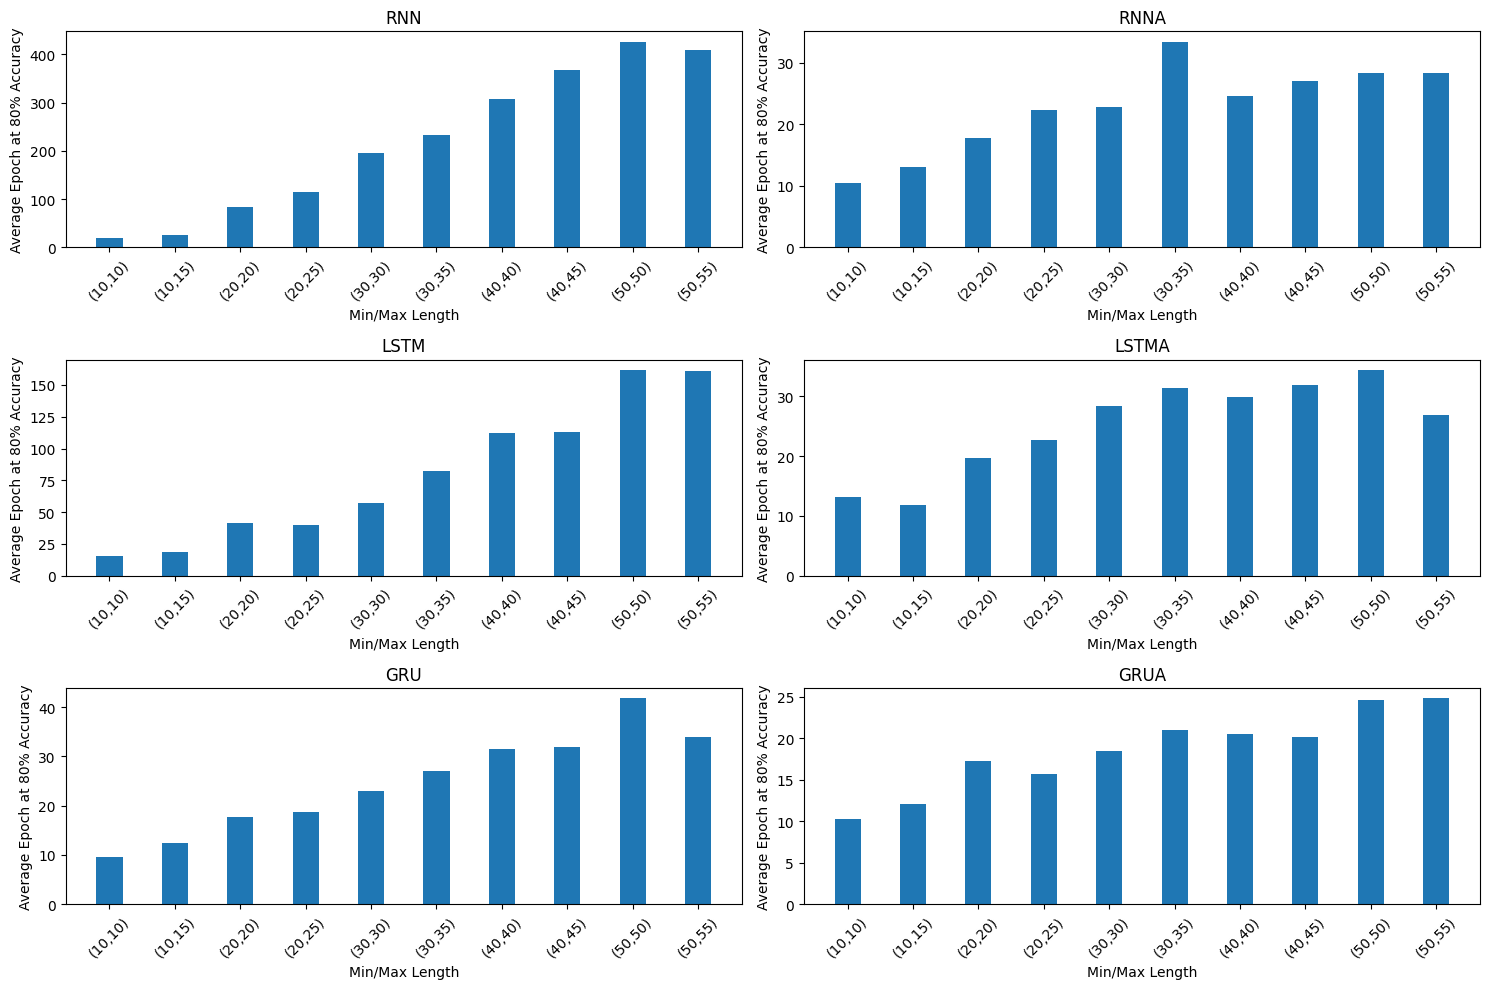

In [75]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = []

# Gathering data for the bar plot
for kind in kinds:
    kind_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                if skip_condition(data):
                    continue
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            kind_results.append(avg_epoch)
        else:
            kind_results.append(None)

    results.append(kind_results)

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Create a subplot for each model kind
for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)  # 3x2 grid for 6 kinds
    bar_positions = np.arange(len(min_lengths))  # One bar for each min/max length combination

    # Plot the bars
    ax.bar(bar_positions, results[i], width=0.4)

    # Set up the plot
    ax.set_title(kind)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")

plt.tight_layout()
plt.show()

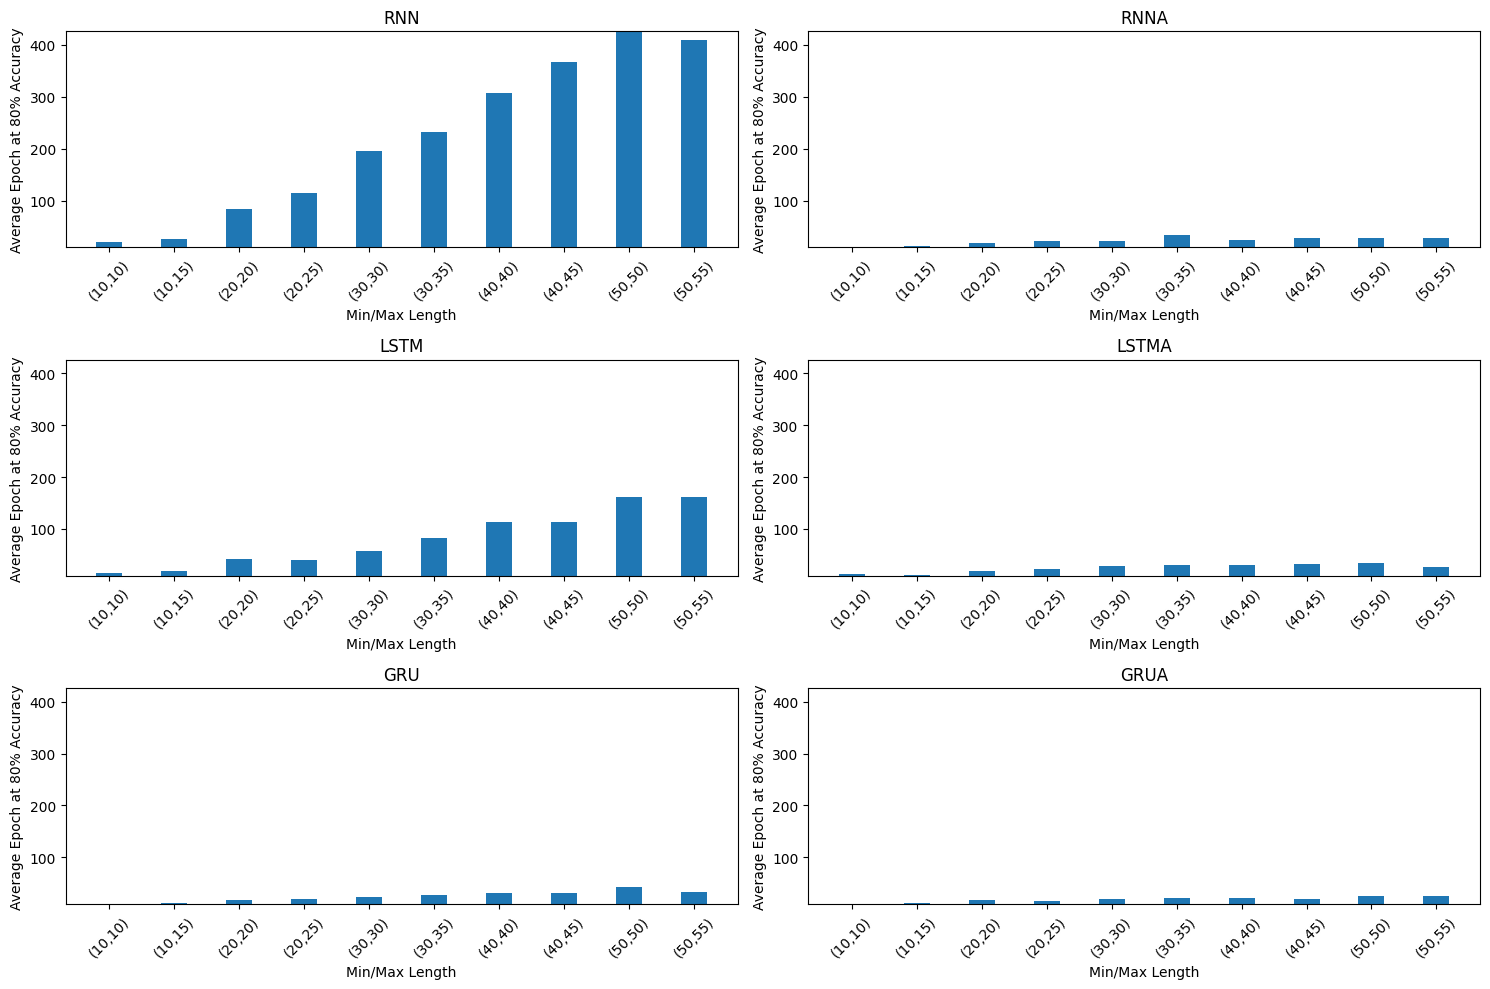

In [76]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = []

# Gathering data for the bar plot
for kind in kinds:
    kind_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                if skip_condition(data):
                    continue
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            kind_results.append(avg_epoch)
        else:
            kind_results.append(None)

    results.append(kind_results)

# Find global min and max for the y-axis scale
all_epochs = [epoch for kind_result in results for epoch in kind_result if epoch is not None]
global_min = min(all_epochs)
global_max = max(all_epochs)

# Creating the bar plot with a consistent y-axis scale
plt.figure(figsize=(15, 10))

for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)
    bar_positions = np.arange(len(min_lengths))
    ax.bar(bar_positions, results[i], width=0.4)
    ax.set_title(kind)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.set_ylim(global_min, global_max)  # Apply consistent scale

plt.tight_layout()
plt.show()

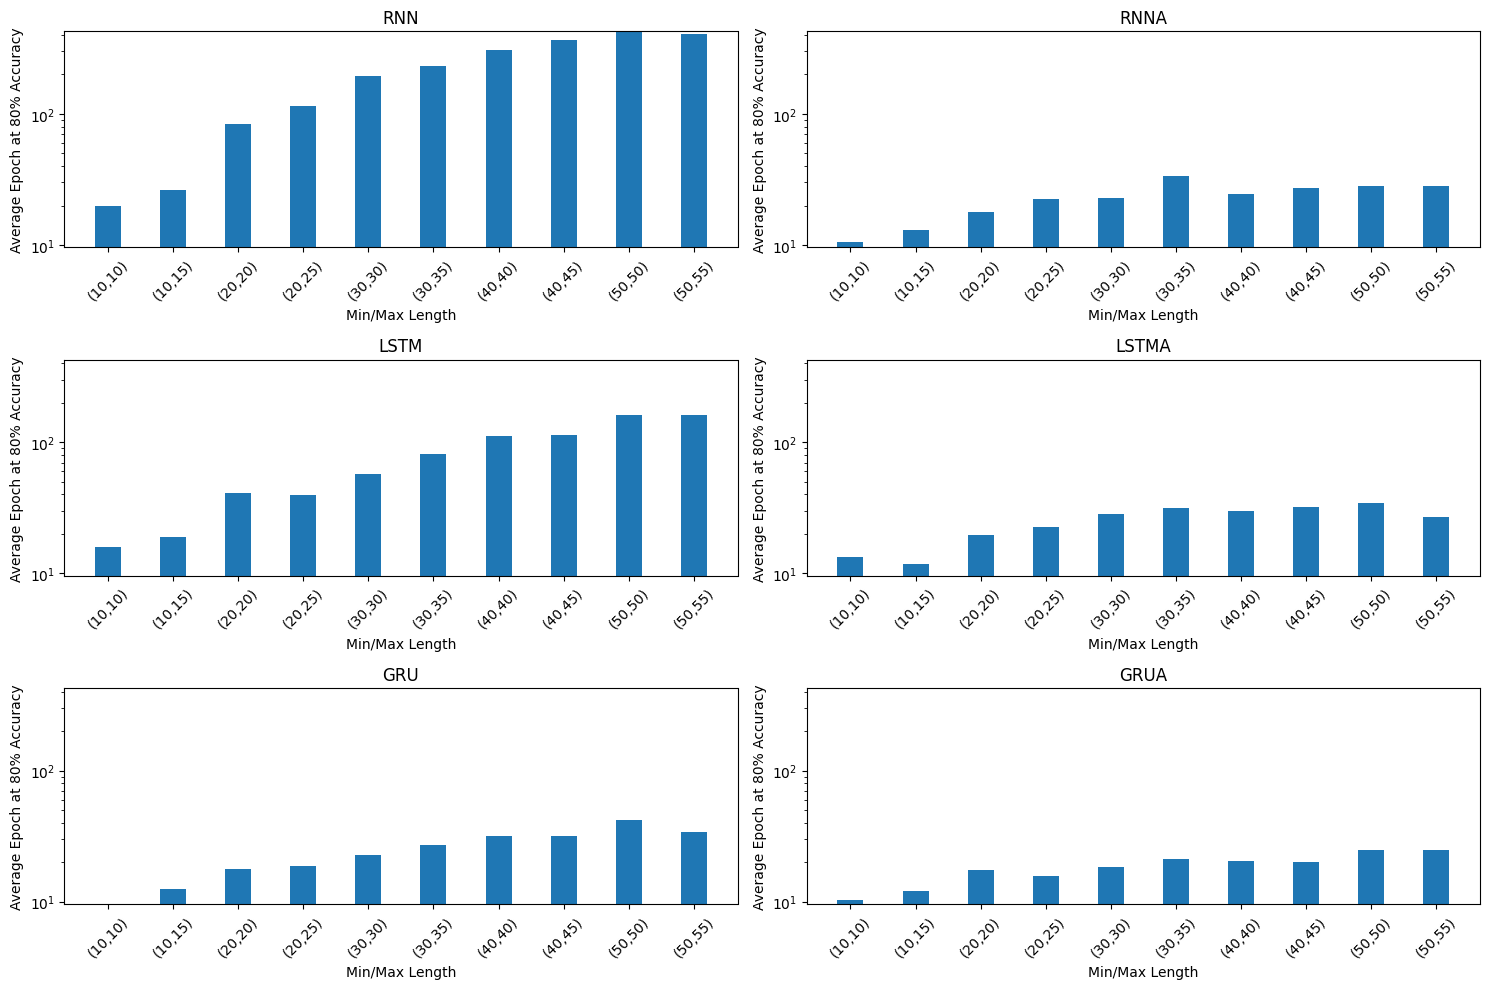

In [77]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = []

# Gathering data for the bar plot
for kind in kinds:
    kind_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                if skip_condition(data):
                    continue
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            kind_results.append(avg_epoch)
        else:
            kind_results.append(None)

    results.append(kind_results)

# Find global min and max for the logarithmic y-axis scale
all_epochs = [epoch for kind_result in results for epoch in kind_result if epoch is not None]
global_min = min(all_epochs)
global_max = max(all_epochs)

# Creating the bar plot with consistent logarithmic y-axis
plt.figure(figsize=(15, 10))

for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)
    bar_positions = np.arange(len(min_lengths))
    ax.bar(bar_positions, results[i], width=0.4)
    ax.set_title(kind)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")

    # Set the same logarithmic scale for each subplot
    ax.set_yscale('log')
    ax.set_ylim(global_min, global_max)

plt.tight_layout()
plt.show()

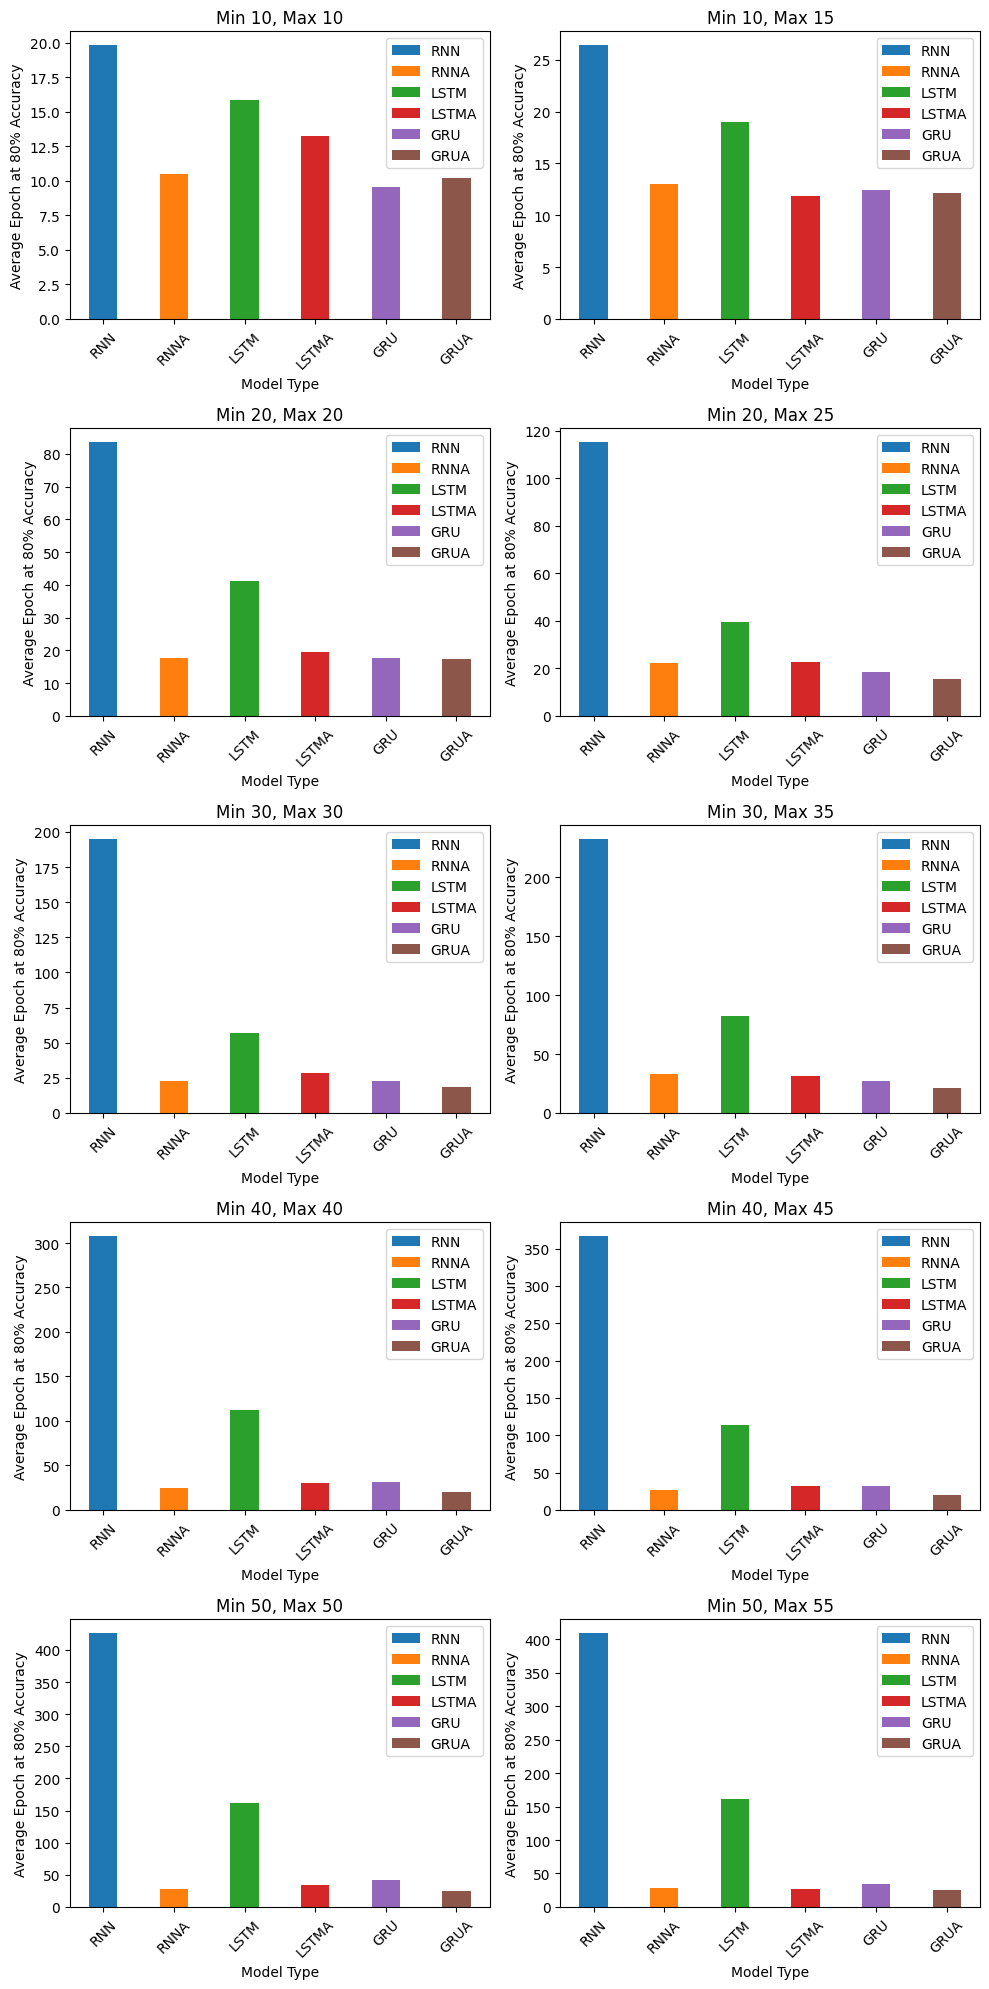

In [78]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = {kind: [] for kind in kinds}

# Gathering data for the bar plot
for min_len, max_len in zip(min_lengths, max_lengths):
    for kind in kinds:
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                if skip_condition(data):
                    continue
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            results[kind].append(avg_epoch)
        else:
            results[kind].append(None)

# Creating the bar plot
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed

# Create a subplot for each min/max length configuration
for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # 5x2 grid for 10 configurations
    bar_positions = np.arange(len(kinds))  # One bar for each model kind

    # Plot the bars
    for j, kind in enumerate(kinds):
        ax.bar(bar_positions[j], results[kind][i], width=0.4, label=kind)

    # Set up the plot
    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(kinds, rotation=45)
    ax.set_xlabel("Model Type")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


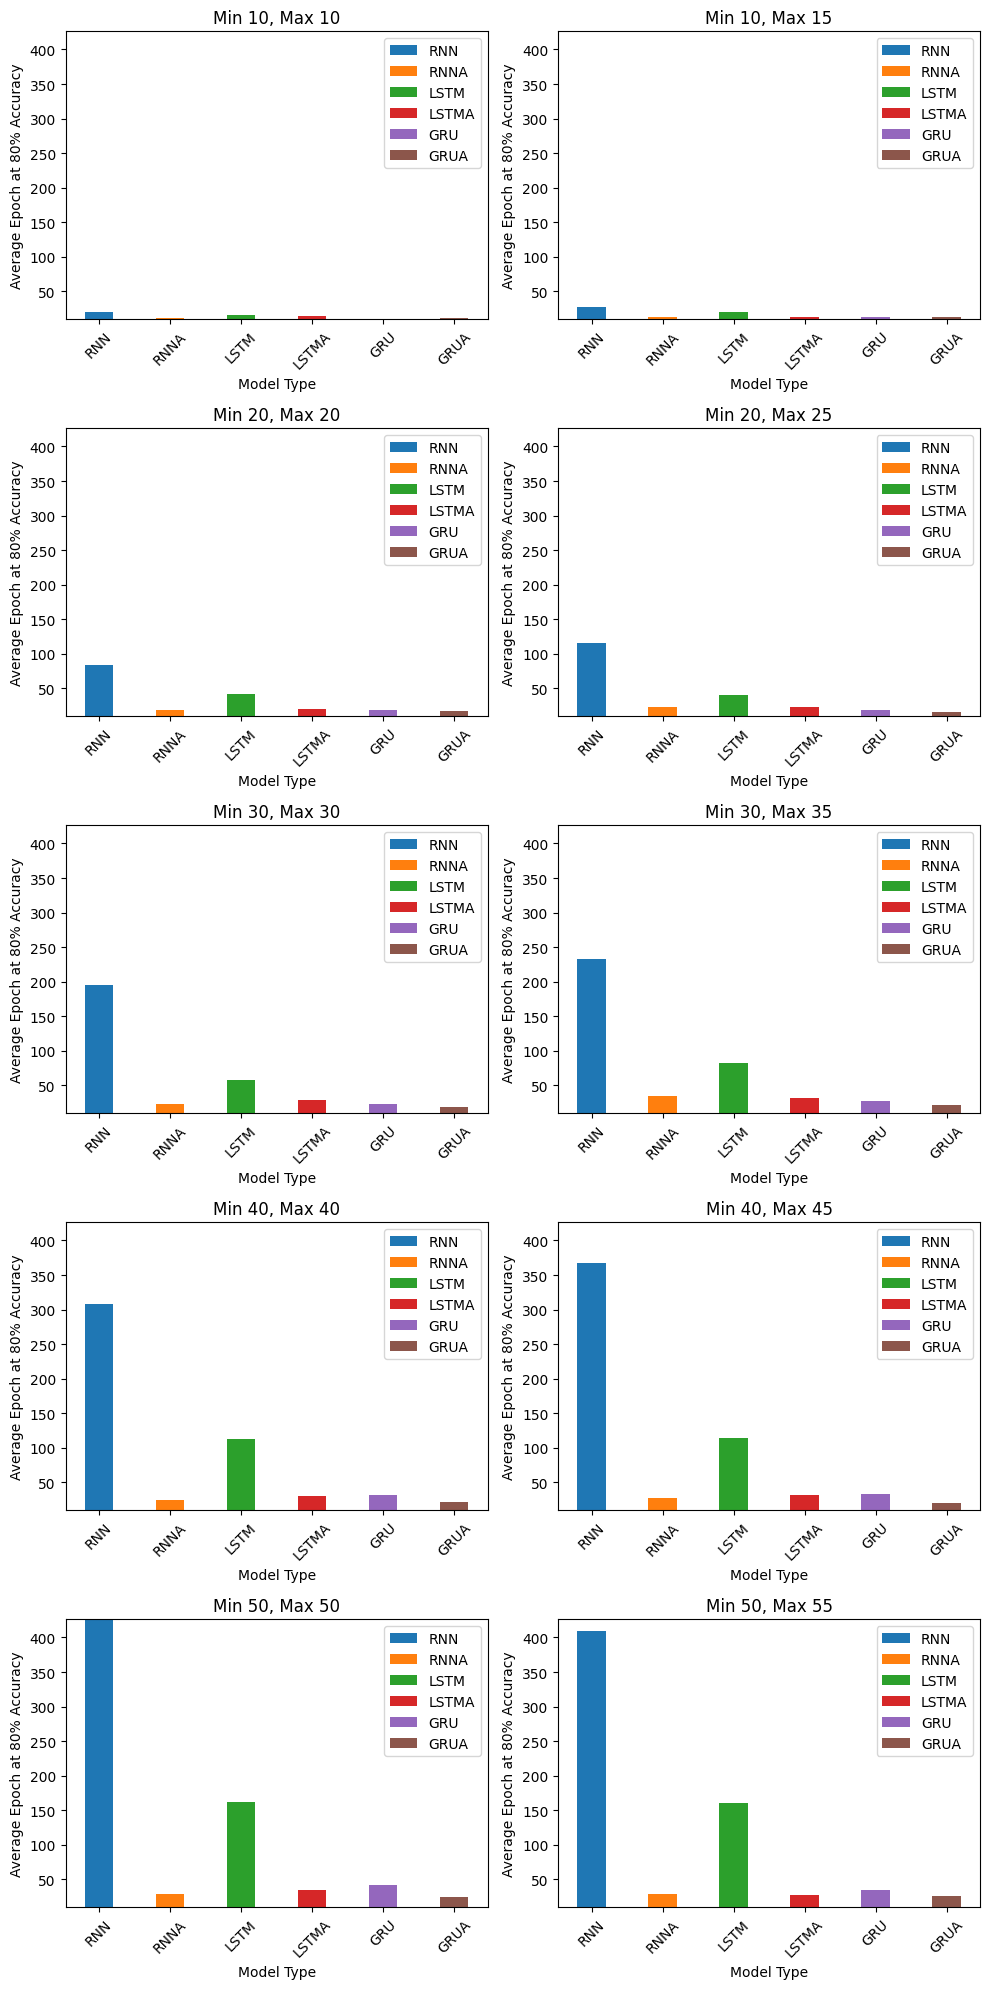

In [79]:
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = {kind: [] for kind in kinds}

# Gathering data for the bar plot
for min_len, max_len in zip(min_lengths, max_lengths):
    for kind in kinds:
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                if skip_condition(data):
                    continue
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            results[kind].append(avg_epoch)
        else:
            results[kind].append(None)

# Find global min and max for the y-axis scale
all_epochs = [epoch for kind_results in results.values() for epoch in kind_results if epoch is not None]
global_min = min(all_epochs)
global_max = max(all_epochs)

# Version 1: Consistent Normal Scale
plt.figure(figsize=(10, 20))
for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)
    bar_positions = np.arange(len(kinds))
    for j, kind in enumerate(kinds):
        ax.bar(bar_positions[j], results[kind][i], width=0.4, label=kind)
    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(kinds, rotation=45)
    ax.set_xlabel("Model Type")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.set_ylim(global_min, global_max)  # Consistent scale
    ax.legend()
plt.tight_layout()
plt.show()


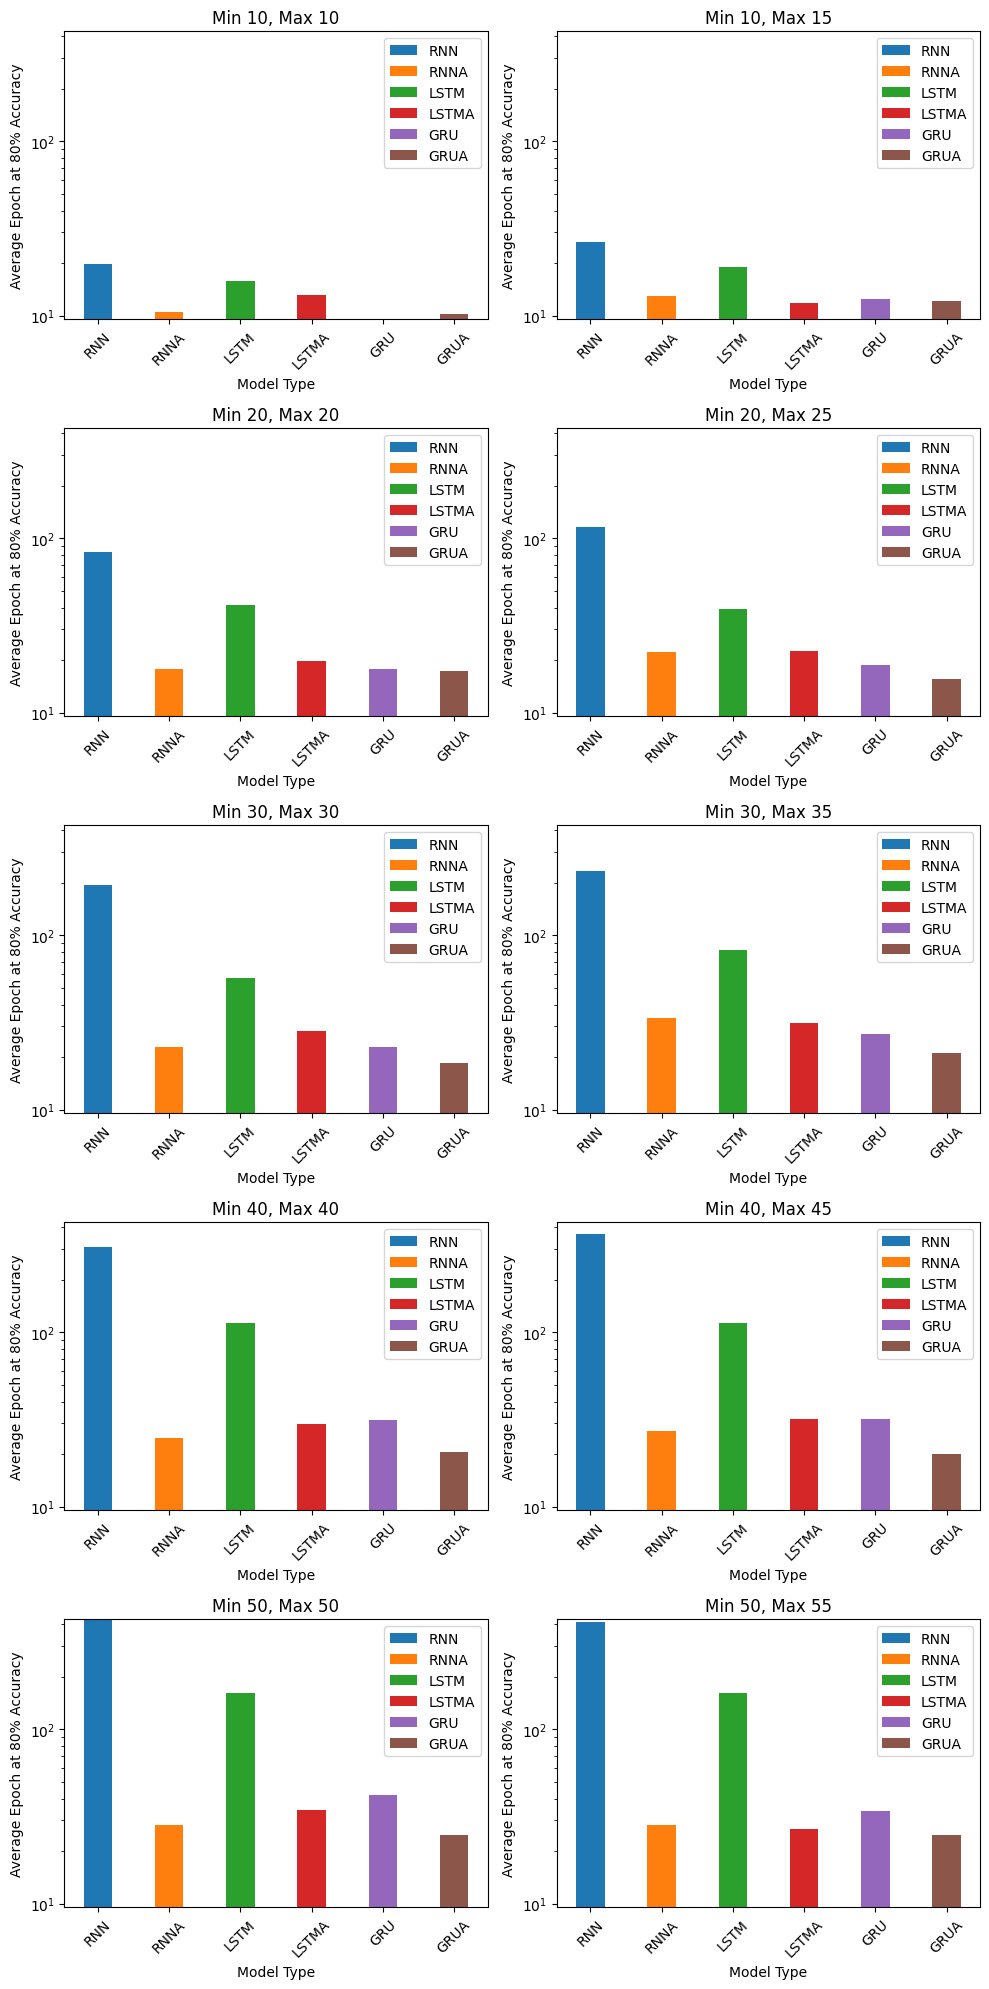

In [80]:
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = {kind: [] for kind in kinds}

# Gathering data for the bar plot
for min_len, max_len in zip(min_lengths, max_lengths):
    for kind in kinds:
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                if skip_condition(data):
                    continue
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            results[kind].append(avg_epoch)
        else:
            results[kind].append(None)

# Find global min and max for the y-axis scale
all_epochs = [epoch for kind_results in results.values() for epoch in kind_results if epoch is not None]
global_min = min(all_epochs)
global_max = max(all_epochs)

plt.figure(figsize=(10, 20))
for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)
    bar_positions = np.arange(len(kinds))
    for j, kind in enumerate(kinds):
        ax.bar(bar_positions[j], results[kind][i], width=0.4, label=kind)
    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(kinds, rotation=45)
    ax.set_xlabel("Model Type")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.set_yscale('log')  # Logarithmic scale
    ax.set_ylim(global_min, global_max)  # Consistent scale
    ax.legend()
plt.tight_layout()
plt.show()

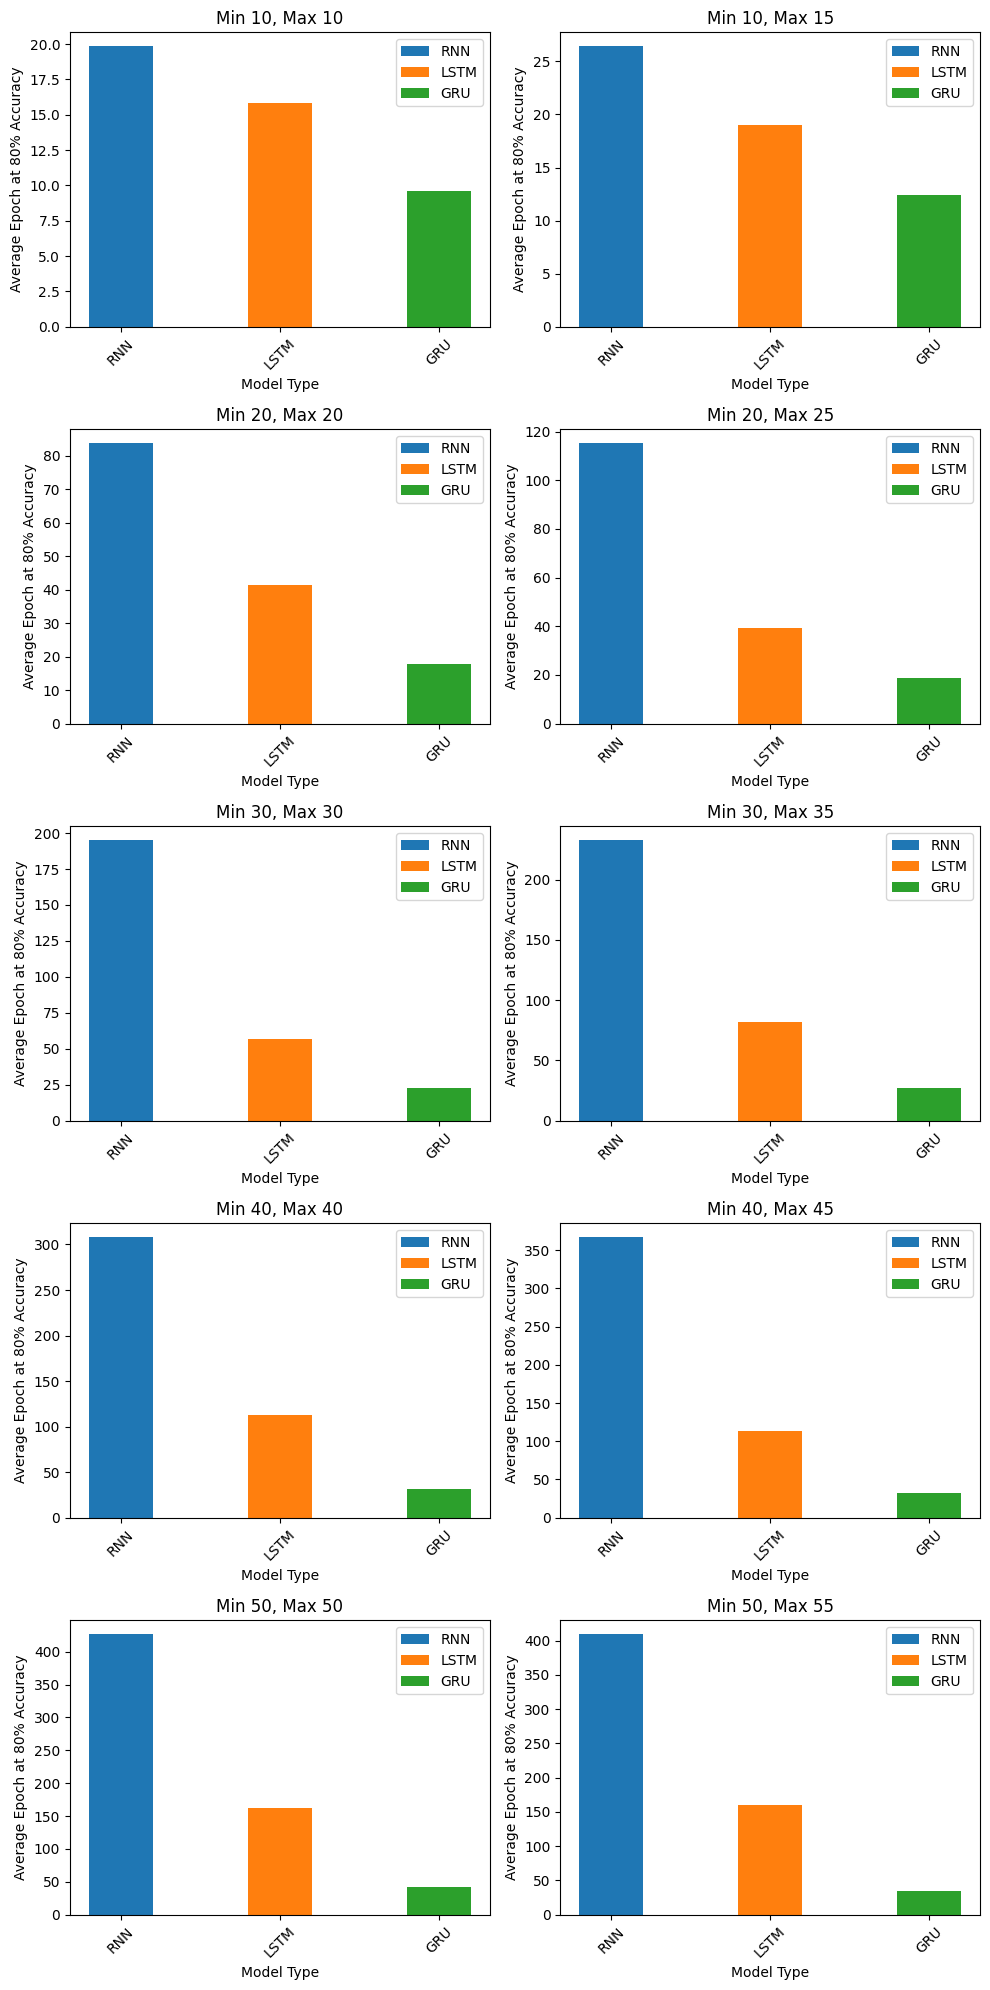

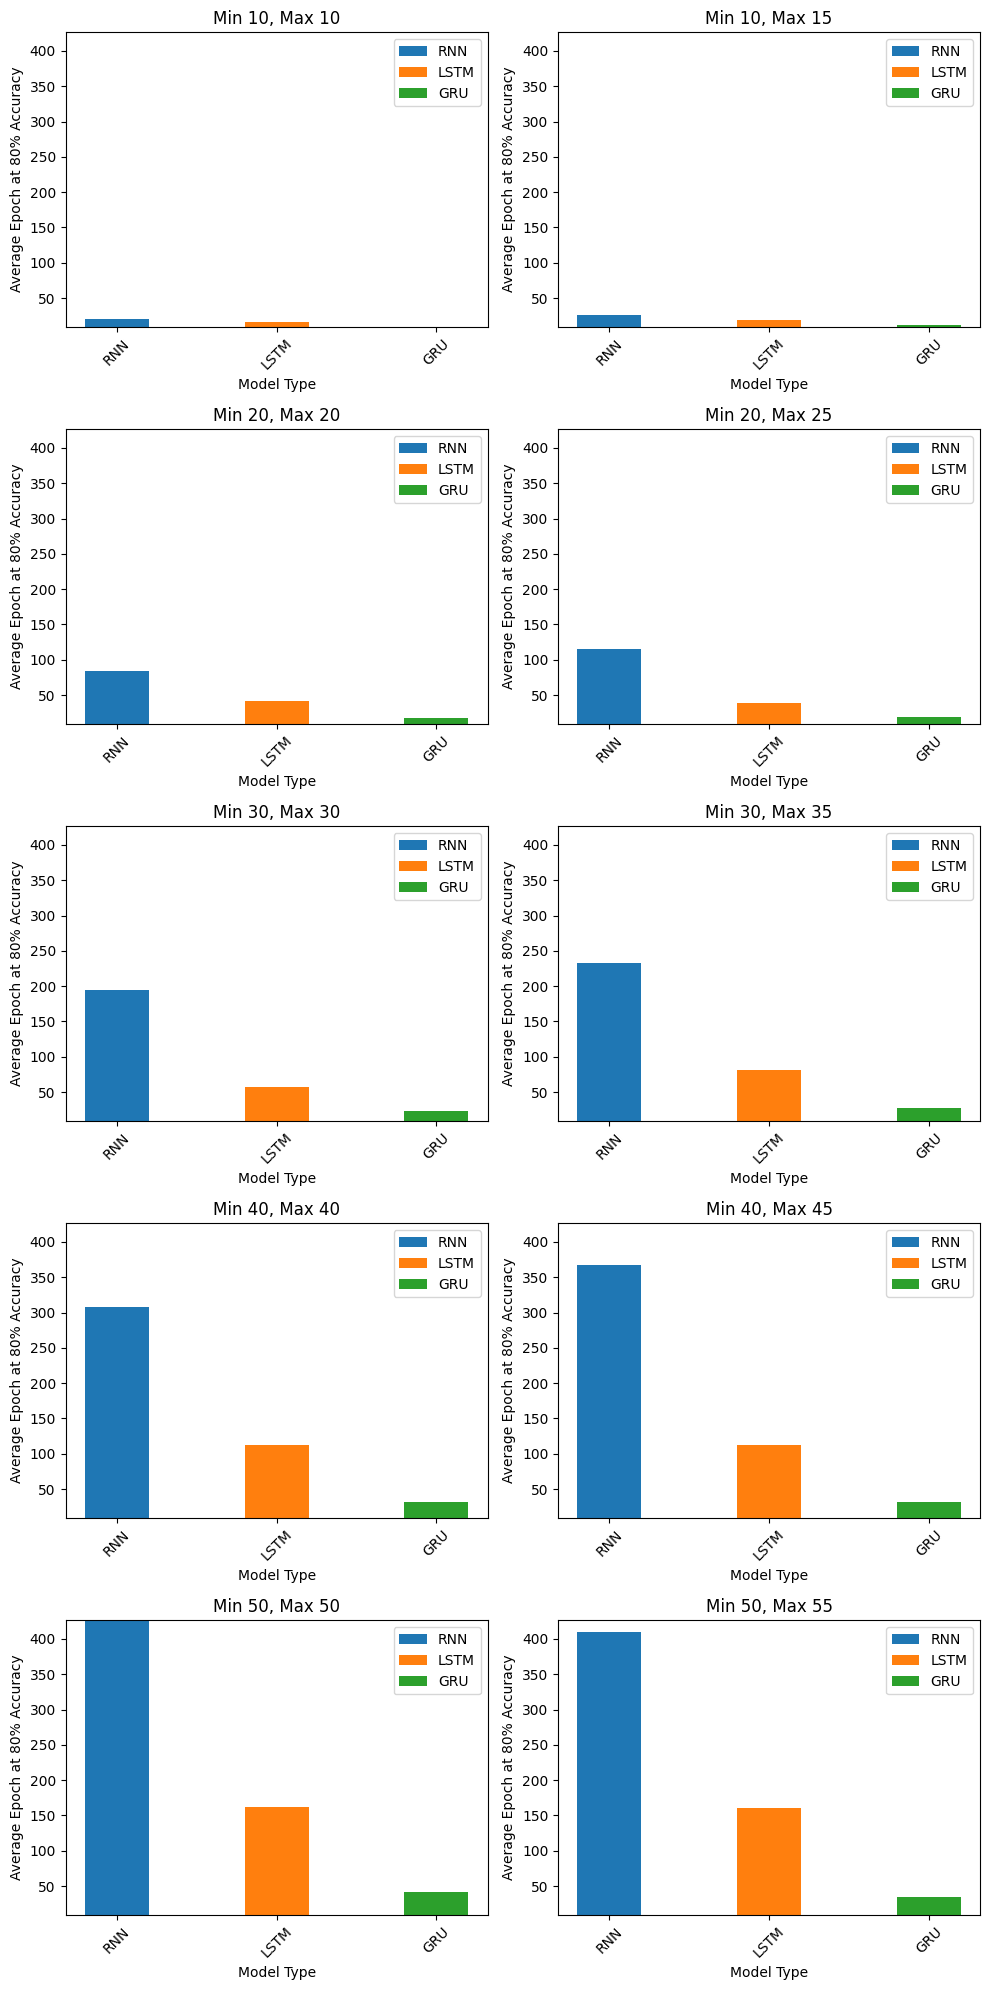

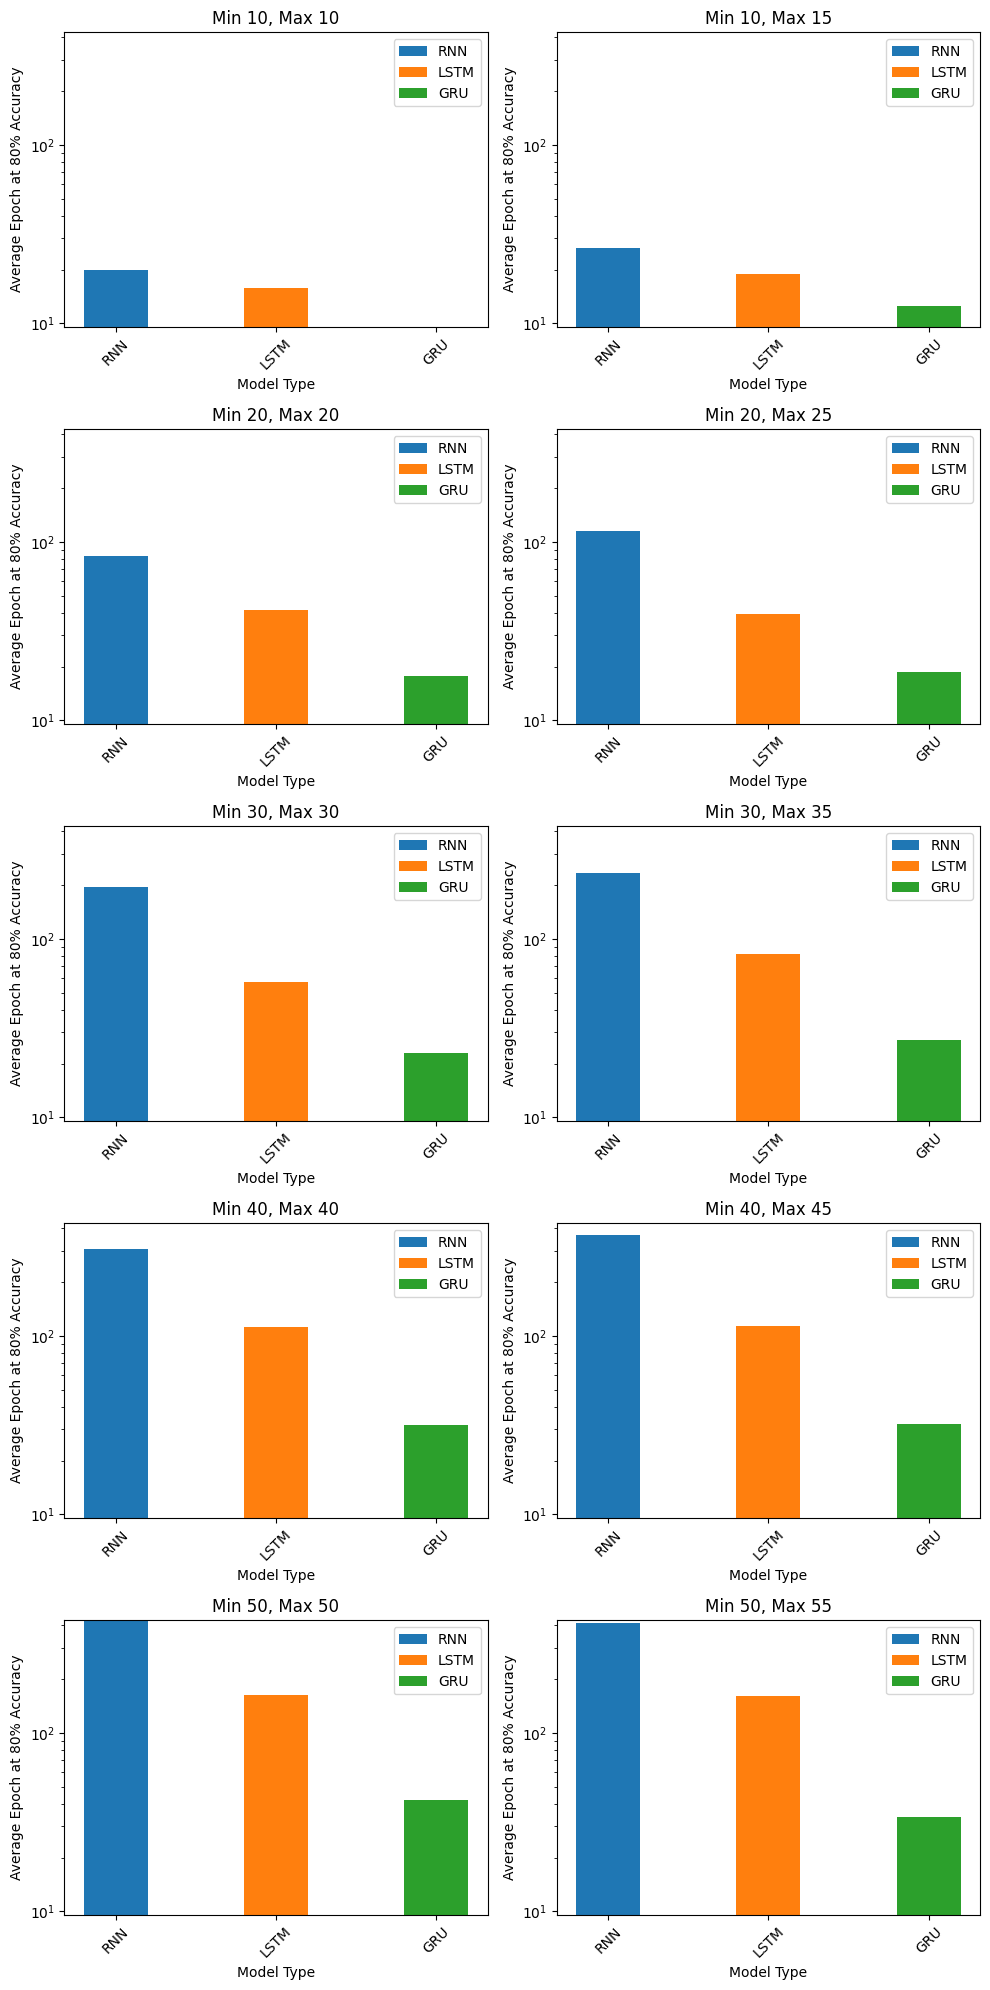

In [81]:
# Constants
kinds = ["RNN", "LSTM", "GRU", ]
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = {kind: [] for kind in kinds}

# Gathering data for the bar plot
for min_len, max_len in zip(min_lengths, max_lengths):
    for kind in kinds:
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                if skip_condition(data):
                    continue
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            results[kind].append(avg_epoch)
        else:
            results[kind].append(None)

# Creating the bar plot
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed

# Create a subplot for each min/max length configuration
for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # 5x2 grid for 10 configurations
    bar_positions = np.arange(len(kinds))  # One bar for each model kind

    # Plot the bars
    for j, kind in enumerate(kinds):
        ax.bar(bar_positions[j], results[kind][i], width=0.4, label=kind)

    # Set up the plot
    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(kinds, rotation=45)
    ax.set_xlabel("Model Type")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


# Find global min and max for the y-axis scale
all_epochs = [epoch for kind_results in results.values() for epoch in kind_results if epoch is not None]
global_min = min(all_epochs)
global_max = max(all_epochs)

# Version 1: Consistent Normal Scale
plt.figure(figsize=(10, 20))
for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)
    bar_positions = np.arange(len(kinds))
    for j, kind in enumerate(kinds):
        ax.bar(bar_positions[j], results[kind][i], width=0.4, label=kind)
    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(kinds, rotation=45)
    ax.set_xlabel("Model Type")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.set_ylim(global_min, global_max)  # Consistent scale
    ax.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(10, 20))
for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)
    bar_positions = np.arange(len(kinds))
    for j, kind in enumerate(kinds):
        ax.bar(bar_positions[j], results[kind][i], width=0.4, label=kind)
    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(kinds, rotation=45)
    ax.set_xlabel("Model Type")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.set_yscale('log')  # Logarithmic scale
    ax.set_ylim(global_min, global_max)  # Consistent scale
    ax.legend()
plt.tight_layout()
plt.show()


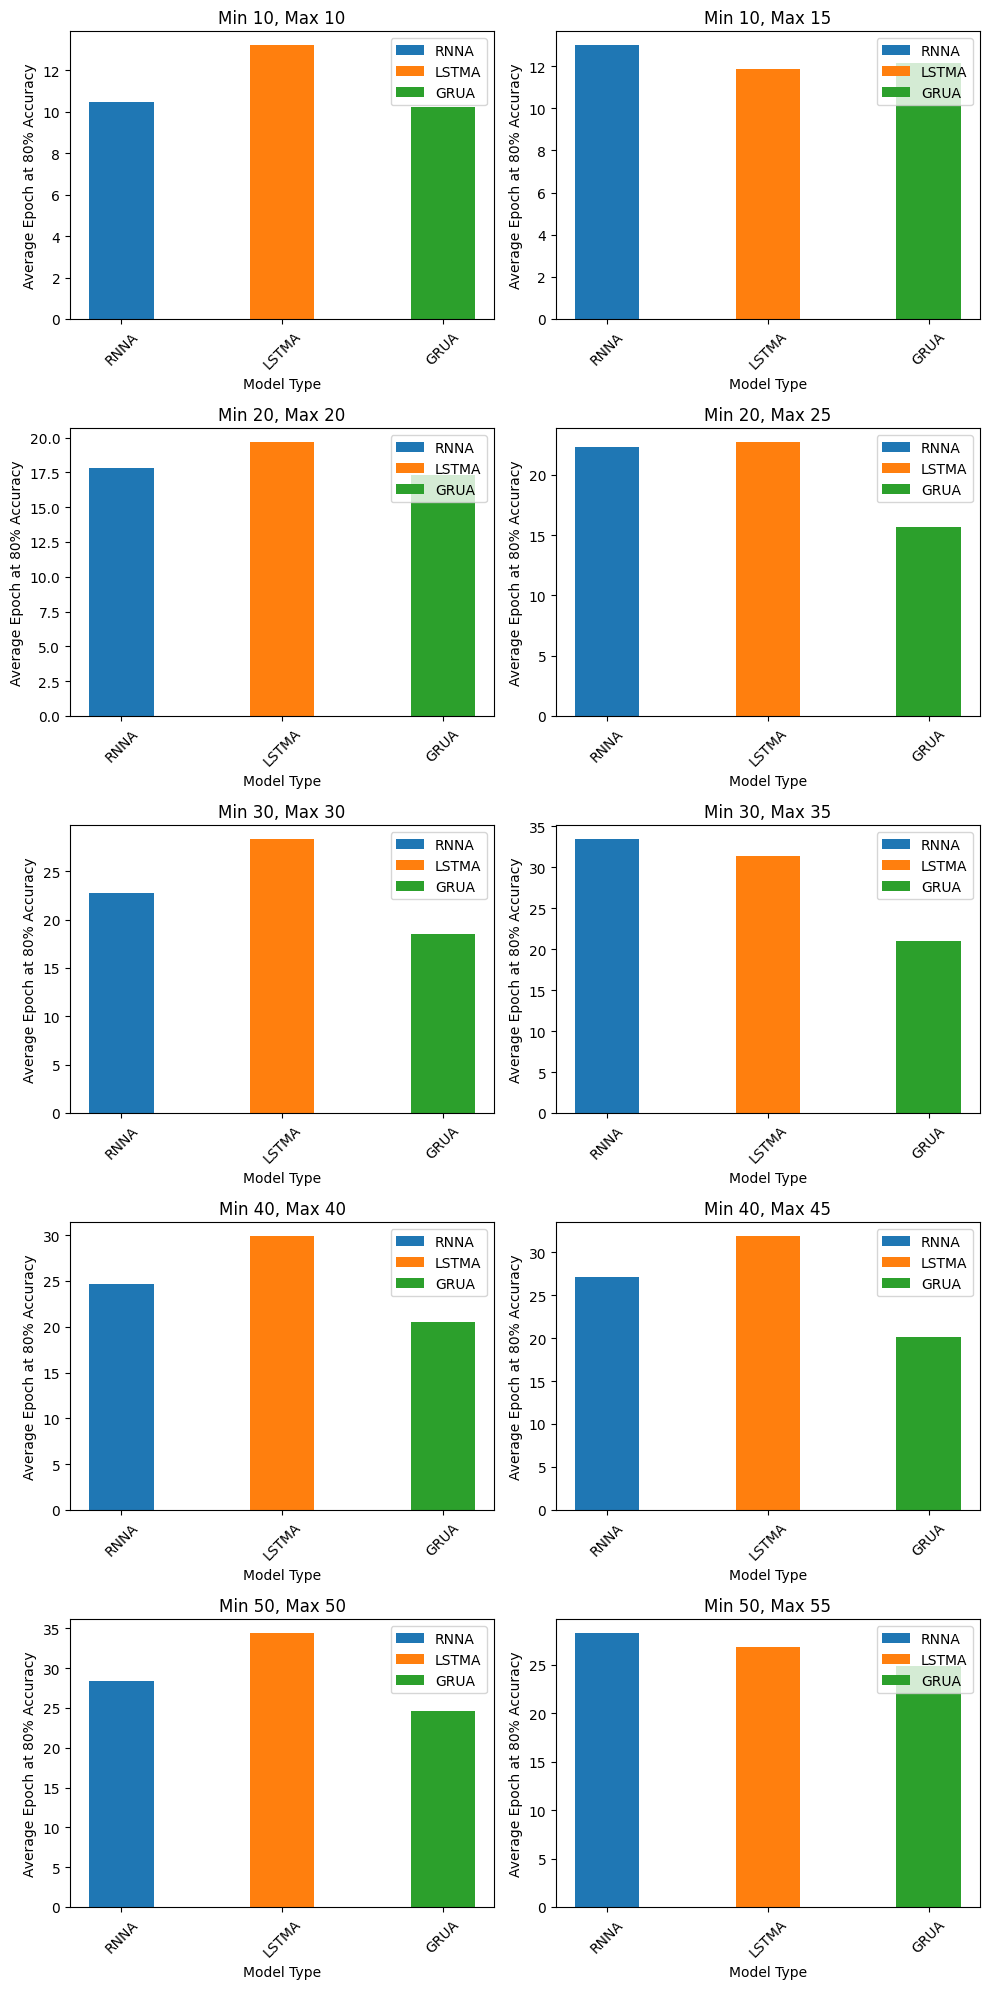

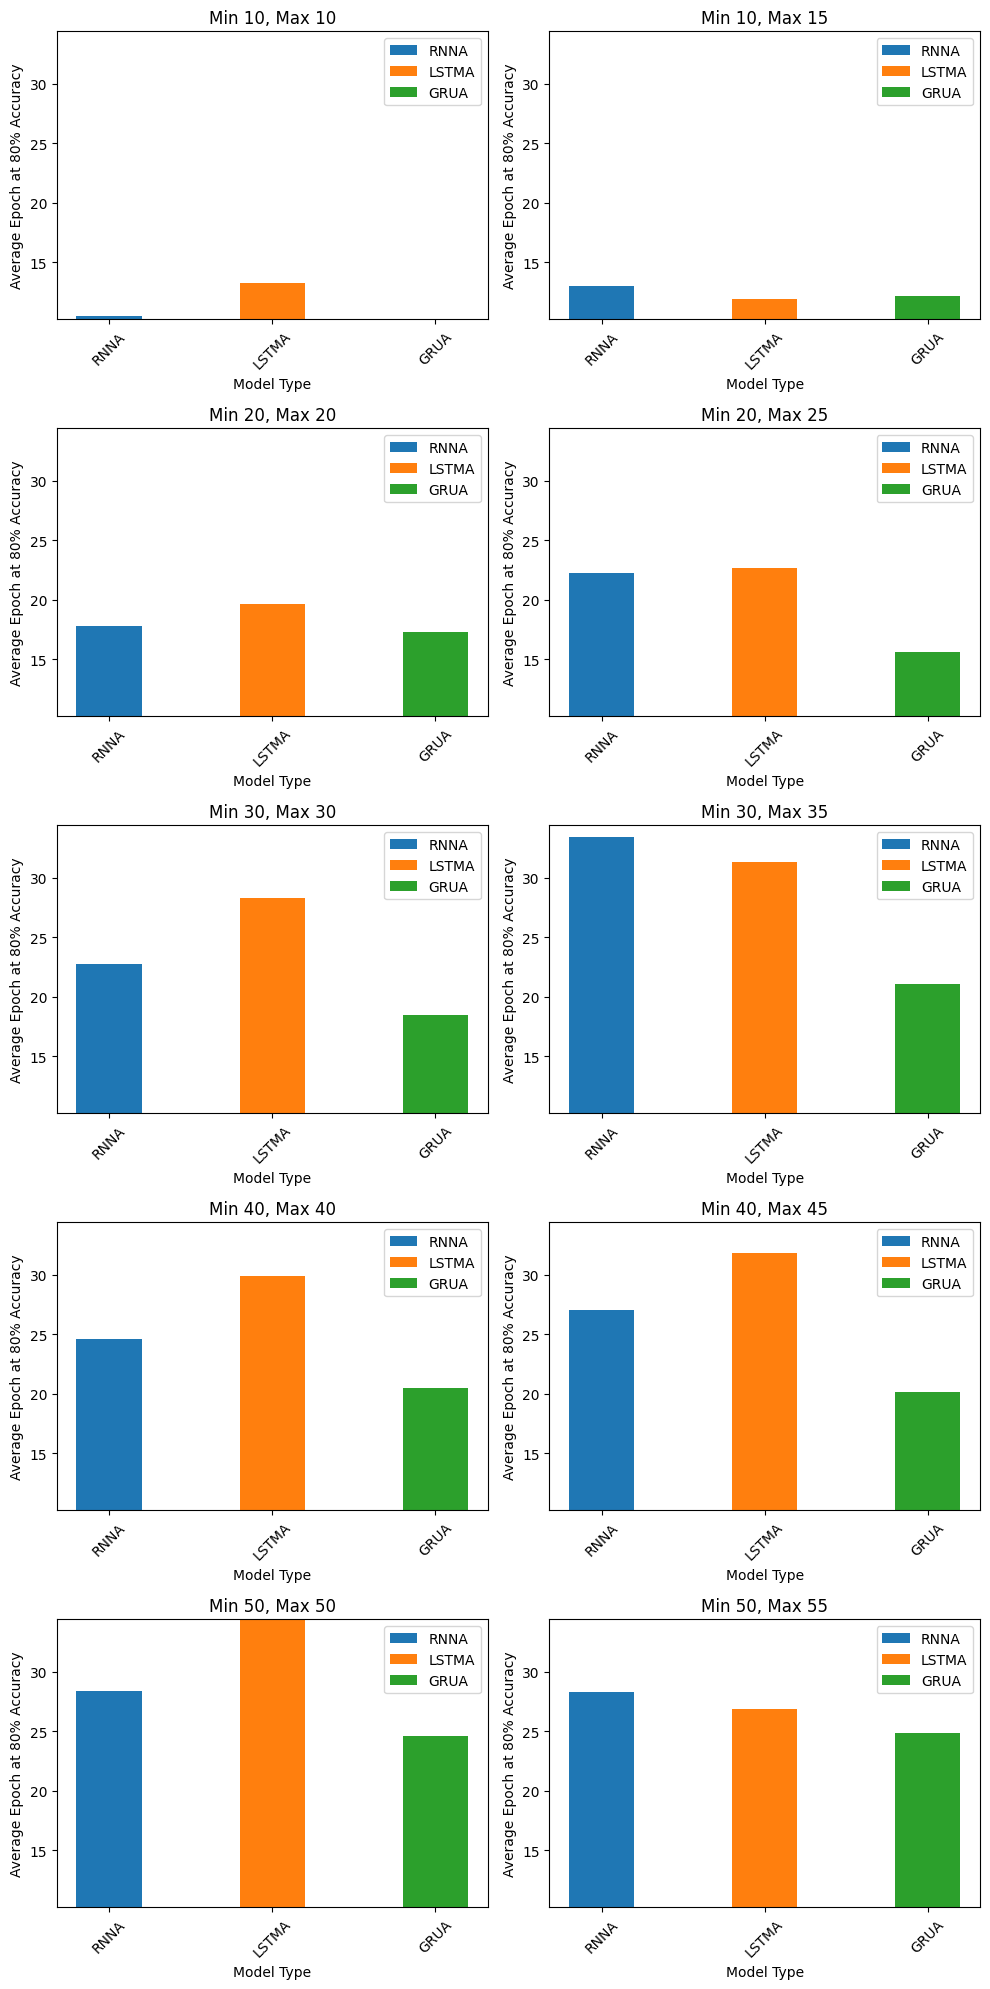

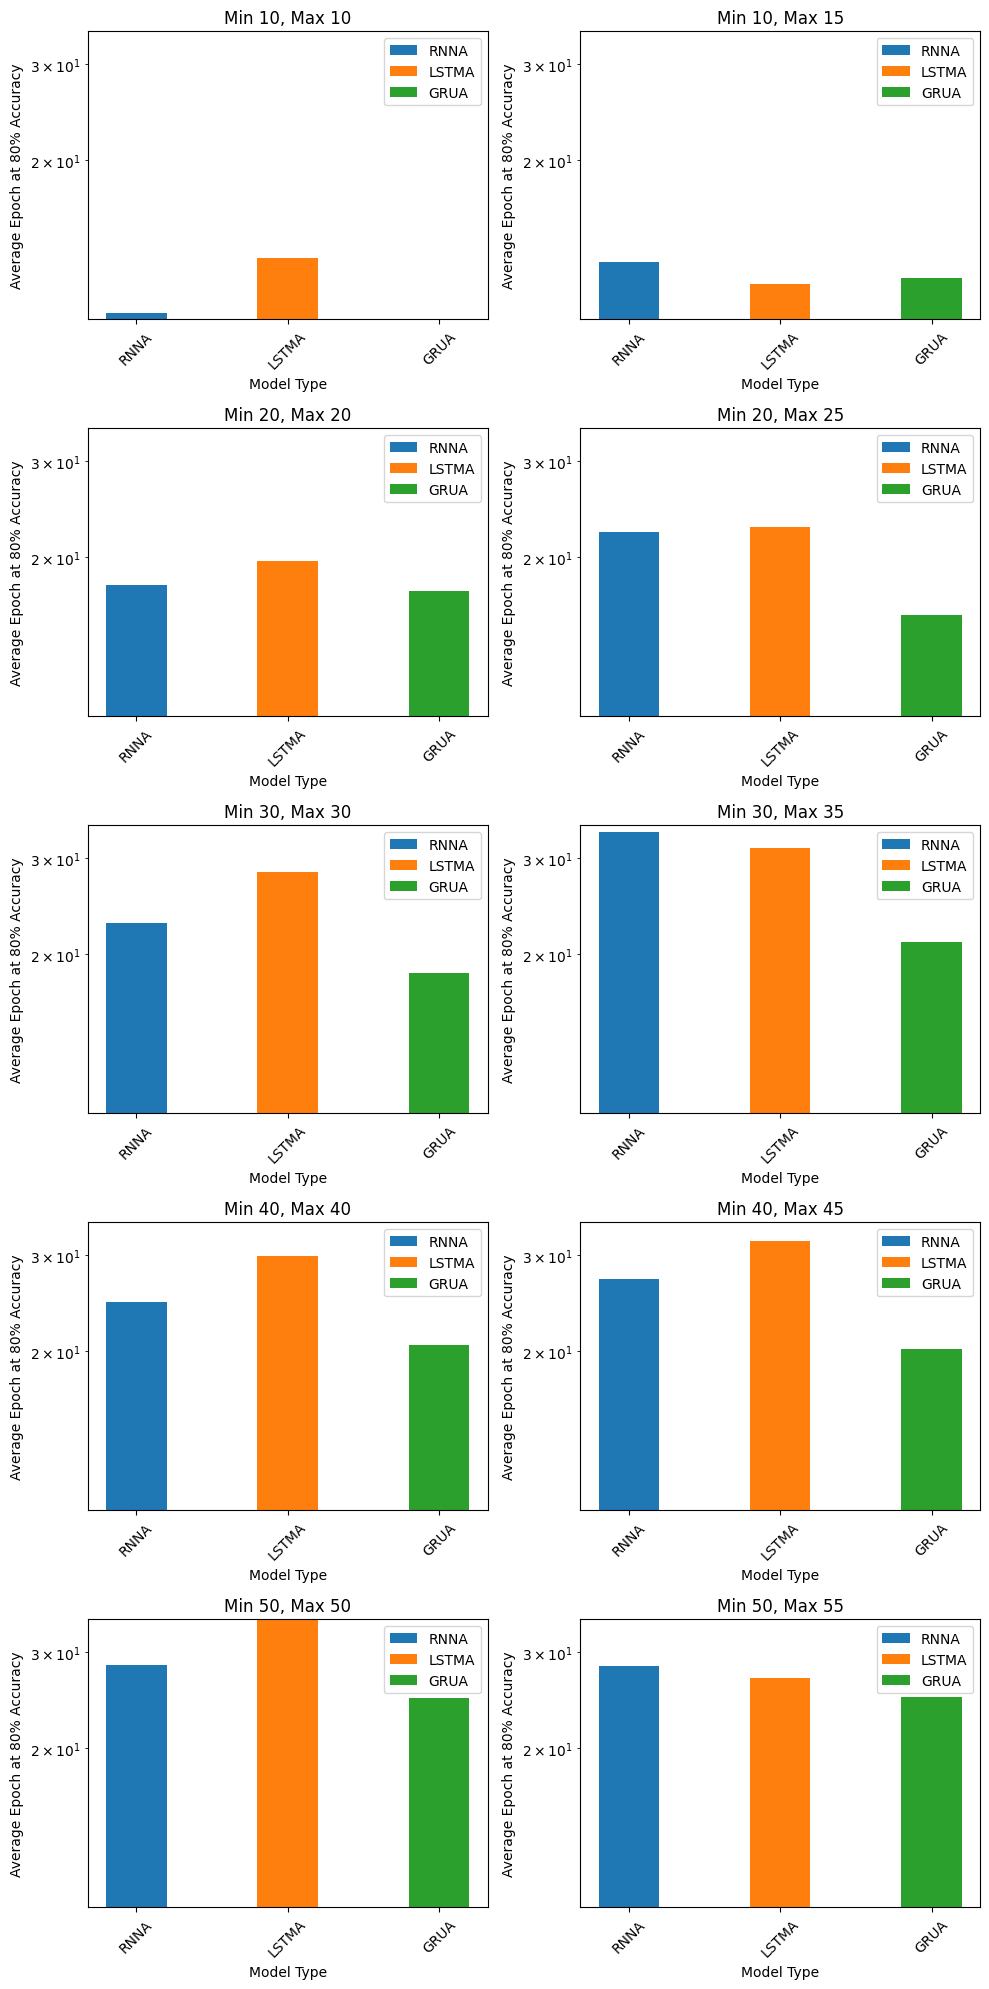

In [82]:
# Constants
kinds = ["RNNA", "LSTMA", "GRUA"]
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = {kind: [] for kind in kinds}

# Gathering data for the bar plot
for min_len, max_len in zip(min_lengths, max_lengths):
    for kind in kinds:
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                if skip_condition(data):
                    continue
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            results[kind].append(avg_epoch)
        else:
            results[kind].append(None)

# Creating the bar plot
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed

# Create a subplot for each min/max length configuration
for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # 5x2 grid for 10 configurations
    bar_positions = np.arange(len(kinds))  # One bar for each model kind

    # Plot the bars
    for j, kind in enumerate(kinds):
        ax.bar(bar_positions[j], results[kind][i], width=0.4, label=kind)

    # Set up the plot
    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(kinds, rotation=45)
    ax.set_xlabel("Model Type")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()




# Find global min and max for the y-axis scale
all_epochs = [epoch for kind_results in results.values() for epoch in kind_results if epoch is not None]
global_min = min(all_epochs)
global_max = max(all_epochs)

# Version 1: Consistent Normal Scale
plt.figure(figsize=(10, 20))
for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)
    bar_positions = np.arange(len(kinds))
    for j, kind in enumerate(kinds):
        ax.bar(bar_positions[j], results[kind][i], width=0.4, label=kind)
    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(kinds, rotation=45)
    ax.set_xlabel("Model Type")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.set_ylim(global_min, global_max)  # Consistent scale
    ax.legend()
plt.tight_layout()
plt.show()



plt.figure(figsize=(10, 20))
for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)
    bar_positions = np.arange(len(kinds))
    for j, kind in enumerate(kinds):
        ax.bar(bar_positions[j], results[kind][i], width=0.4, label=kind)
    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(kinds, rotation=45)
    ax.set_xlabel("Model Type")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.set_yscale('log')  # Logarithmic scale
    ax.set_ylim(global_min, global_max)  # Consistent scale
    ax.legend()
plt.tight_layout()
plt.show()



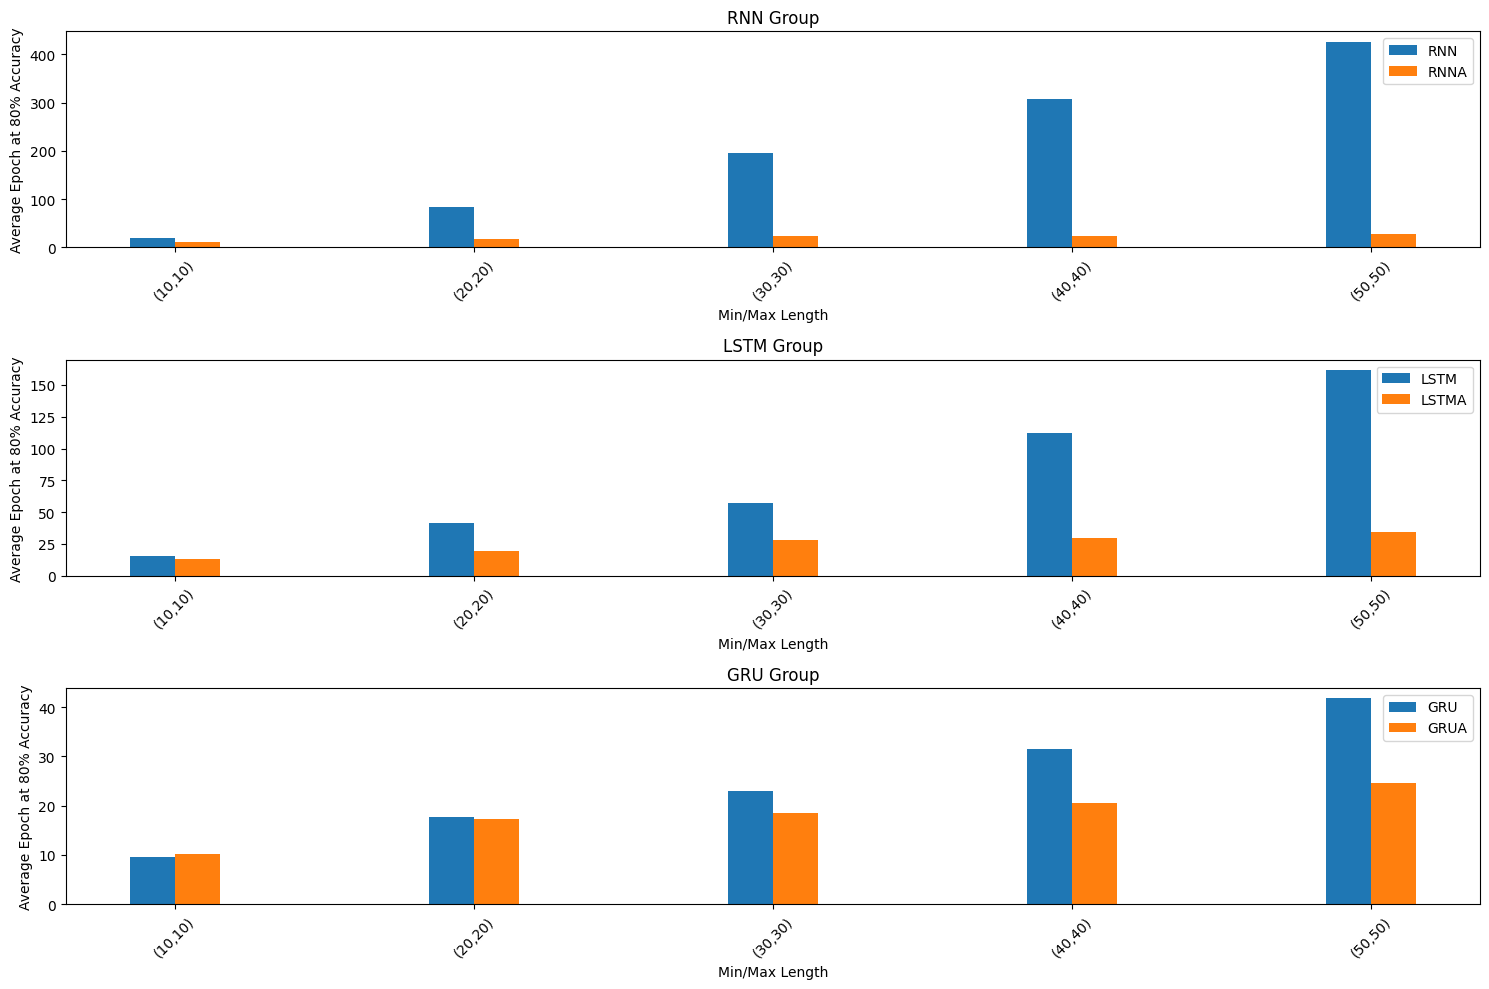

In [83]:
# Model groups
model_groups = {
    "RNN": ["RNN", "RNNA"],
    "LSTM": ["LSTM", "LSTMA"],
    "GRU": ["GRU", "GRUA"]
}

min_lengths = [10 ,20, 30, 40, 50]
max_lengths = [10 ,20, 30, 40, 50]
num_reps = 31

# Placeholder for the results
results = {group: [] for group in model_groups}

# Gathering data for the bar plot
for group_name, kinds in model_groups.items():
    group_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        kind_avg_epochs = []

        for kind in kinds:
            epochs_to_80_percent = []

            for rep in range(num_reps):
                filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
                try:
                    data = pd.read_csv(filename)
                    data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                    if skip_condition(data):
                        continue
                    epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                    if epoch is not None:
                        epochs_to_80_percent.append(epoch)
                except FileNotFoundError:
                    print(f"File not found: {filename}")
                    continue

            if epochs_to_80_percent:
                avg_epoch = np.mean(epochs_to_80_percent)
                kind_avg_epochs.append(avg_epoch)
            else:
                kind_avg_epochs.append(None)

        group_results.append(kind_avg_epochs)
    results[group_name] = group_results

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Create a subplot for each model group
for i, (group_name, group_kinds) in enumerate(model_groups.items()):
    ax = plt.subplot(len(model_groups), 1, i + 1)  # One row for each group
    bar_positions = np.arange(len(min_lengths))  # One set of bars for each min/max length combination

    # Plot the bars for each kind in the group
    bar_width = 0.15
    for j, kind in enumerate(group_kinds):
        kind_results = [result[j] for result in results[group_name]]  # Get results for this kind
        ax.bar(bar_positions + j * bar_width, kind_results, width=bar_width, label=kind)

    # Set up the plot
    ax.set_title(f"{group_name} Group")
    ax.set_xticks(bar_positions + bar_width * (len(group_kinds) - 1) / 2)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


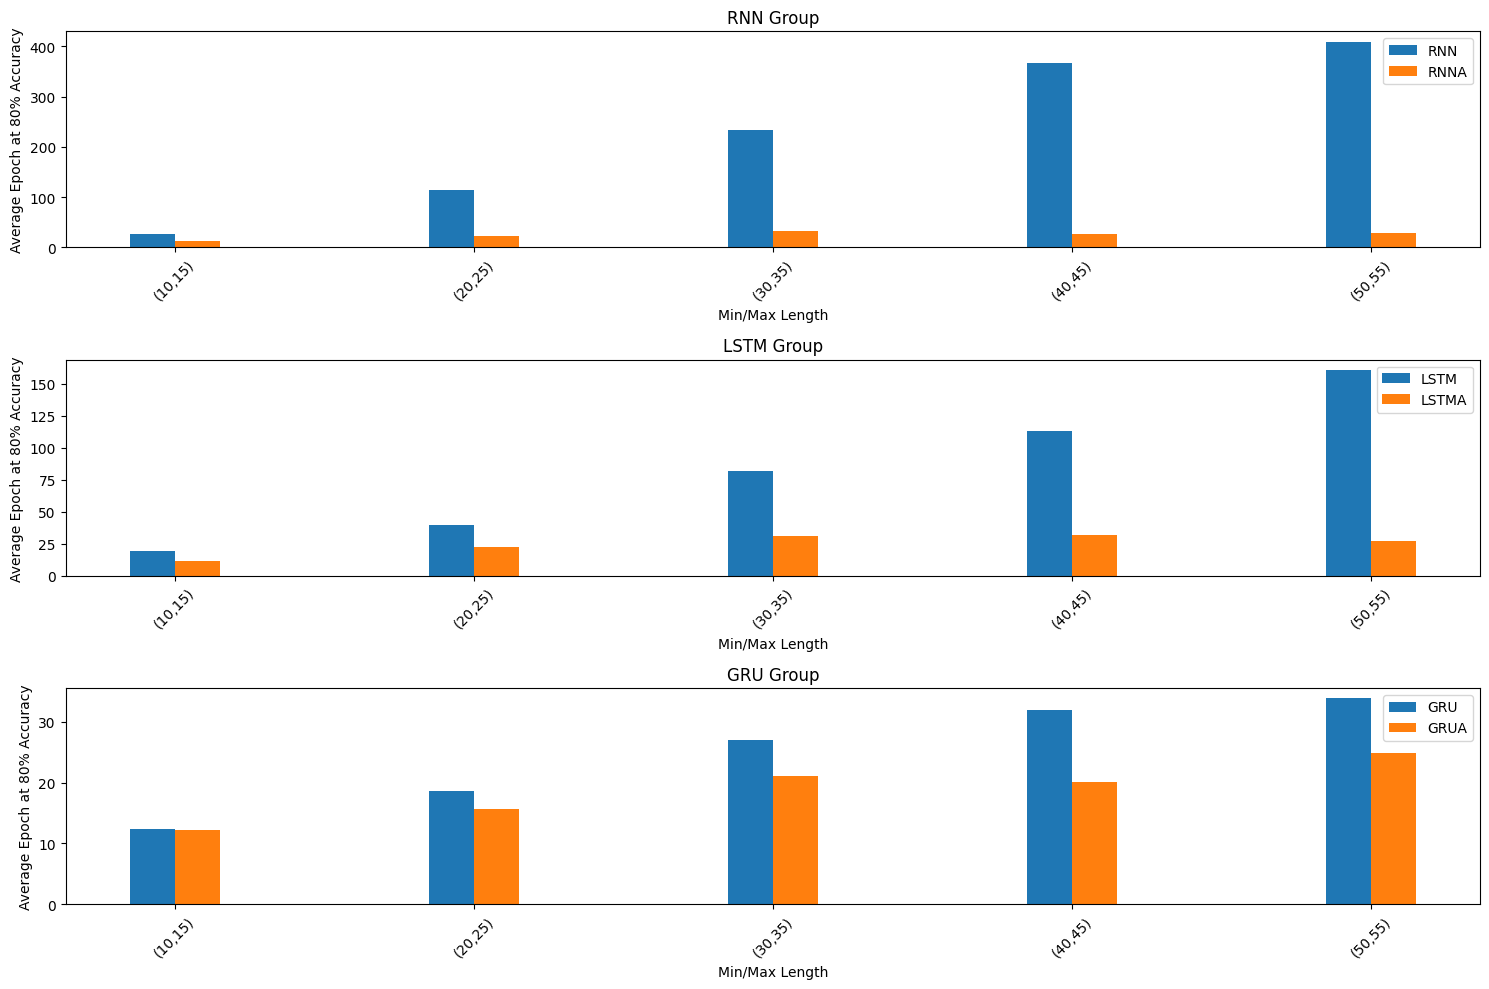

In [84]:
# Model groups
model_groups = {
    "RNN": ["RNN", "RNNA"],
    "LSTM": ["LSTM", "LSTMA"],
    "GRU": ["GRU", "GRUA"]
}

min_lengths = [10 ,20, 30, 40, 50]
max_lengths = [15 ,25, 35, 45, 55]
num_reps = 31

# Placeholder for the results
results = {group: [] for group in model_groups}

# Gathering data for the bar plot
for group_name, kinds in model_groups.items():
    group_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        kind_avg_epochs = []

        for kind in kinds:
            epochs_to_80_percent = []

            for rep in range(num_reps):
                filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
                try:
                    data = pd.read_csv(filename)
                    data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                    if skip_condition(data):
                        continue
                    epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                    if epoch is not None:
                        epochs_to_80_percent.append(epoch)
                except FileNotFoundError:
                    print(f"File not found: {filename}")
                    continue

            if epochs_to_80_percent:
                avg_epoch = np.mean(epochs_to_80_percent)
                kind_avg_epochs.append(avg_epoch)
            else:
                kind_avg_epochs.append(None)

        group_results.append(kind_avg_epochs)
    results[group_name] = group_results

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Create a subplot for each model group
for i, (group_name, group_kinds) in enumerate(model_groups.items()):
    ax = plt.subplot(len(model_groups), 1, i + 1)  # One row for each group
    bar_positions = np.arange(len(min_lengths))  # One set of bars for each min/max length combination

    # Plot the bars for each kind in the group
    bar_width = 0.15
    for j, kind in enumerate(group_kinds):
        kind_results = [result[j] for result in results[group_name]]  # Get results for this kind
        ax.bar(bar_positions + j * bar_width, kind_results, width=bar_width, label=kind)

    # Set up the plot
    ax.set_title(f"{group_name} Group")
    ax.set_xticks(bar_positions + bar_width * (len(group_kinds) - 1) / 2)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


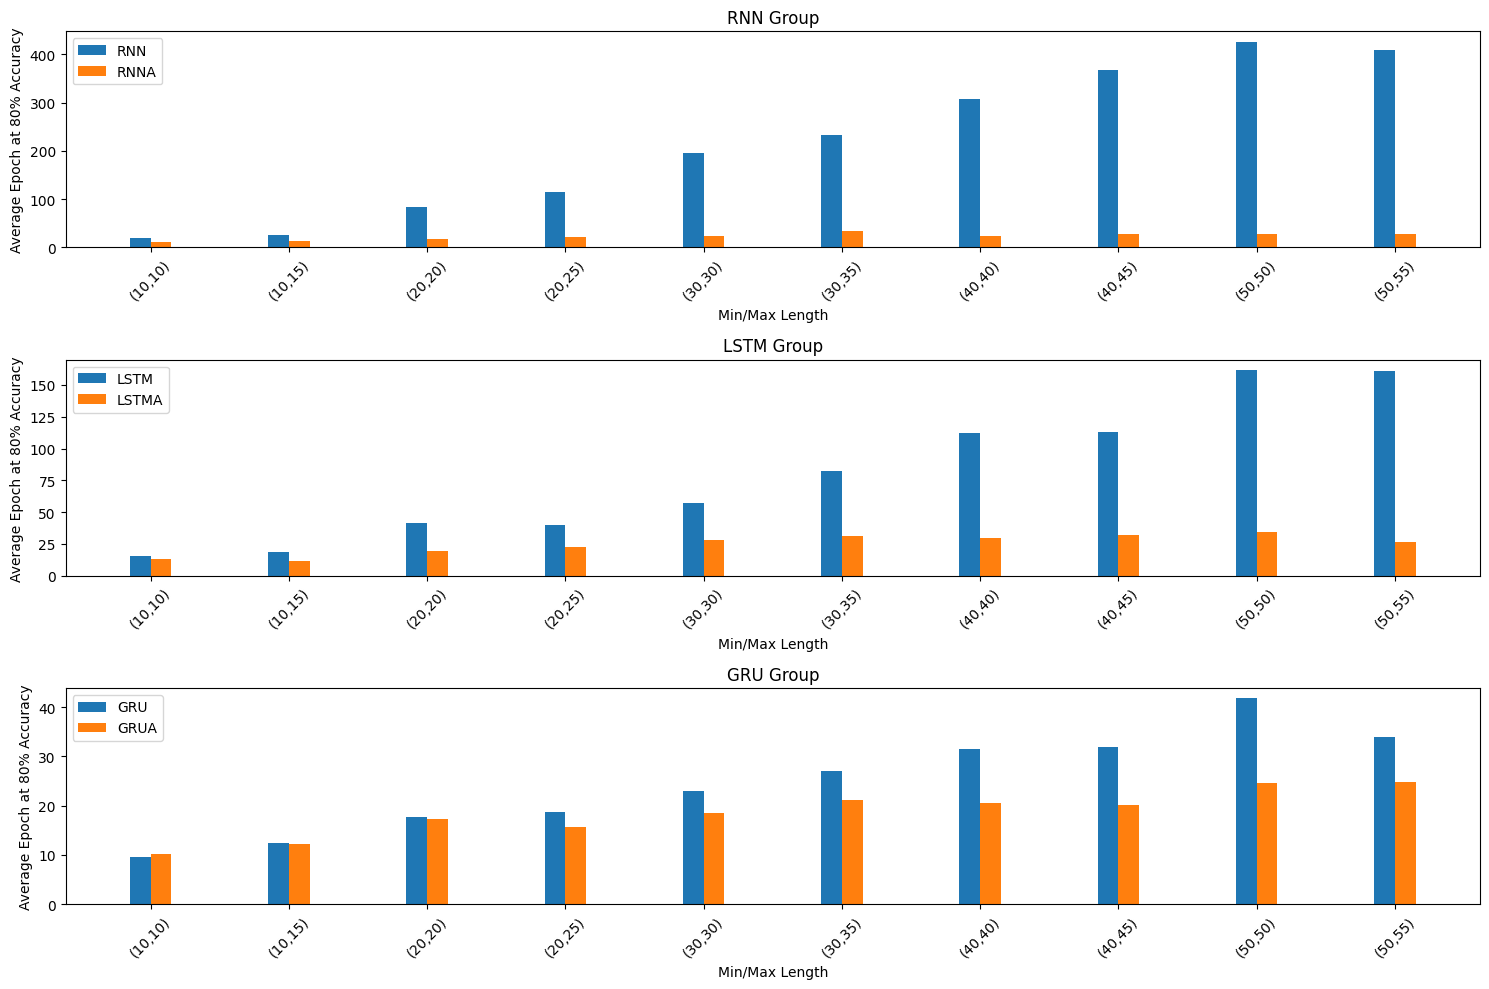

In [85]:
# Model groups
model_groups = {
    "RNN": ["RNN", "RNNA"],
    "LSTM": ["LSTM", "LSTMA"],
    "GRU": ["GRU", "GRUA"]
}

min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = {group: [] for group in model_groups}

# Gathering data for the bar plot
for group_name, kinds in model_groups.items():
    group_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        kind_avg_epochs = []

        for kind in kinds:
            epochs_to_80_percent = []

            for rep in range(num_reps):
                filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
                try:
                    data = pd.read_csv(filename)
                    data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                    if skip_condition(data):
                        continue
                    epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                    if epoch is not None:
                        epochs_to_80_percent.append(epoch)
                except FileNotFoundError:
                    print(f"File not found: {filename}")
                    continue

            if epochs_to_80_percent:
                avg_epoch = np.mean(epochs_to_80_percent)
                kind_avg_epochs.append(avg_epoch)
            else:
                kind_avg_epochs.append(None)

        group_results.append(kind_avg_epochs)
    results[group_name] = group_results

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Create a subplot for each model group
for i, (group_name, group_kinds) in enumerate(model_groups.items()):
    ax = plt.subplot(len(model_groups), 1, i + 1)  # One row for each group
    bar_positions = np.arange(len(min_lengths))  # One set of bars for each min/max length combination

    # Plot the bars for each kind in the group
    bar_width = 0.15
    for j, kind in enumerate(group_kinds):
        kind_results = [result[j] for result in results[group_name]]  # Get results for this kind
        ax.bar(bar_positions + j * bar_width, kind_results, width=bar_width, label=kind)

    # Set up the plot
    ax.set_title(f"{group_name} Group")
    ax.set_xticks(bar_positions + bar_width * (len(group_kinds) - 1) / 2)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


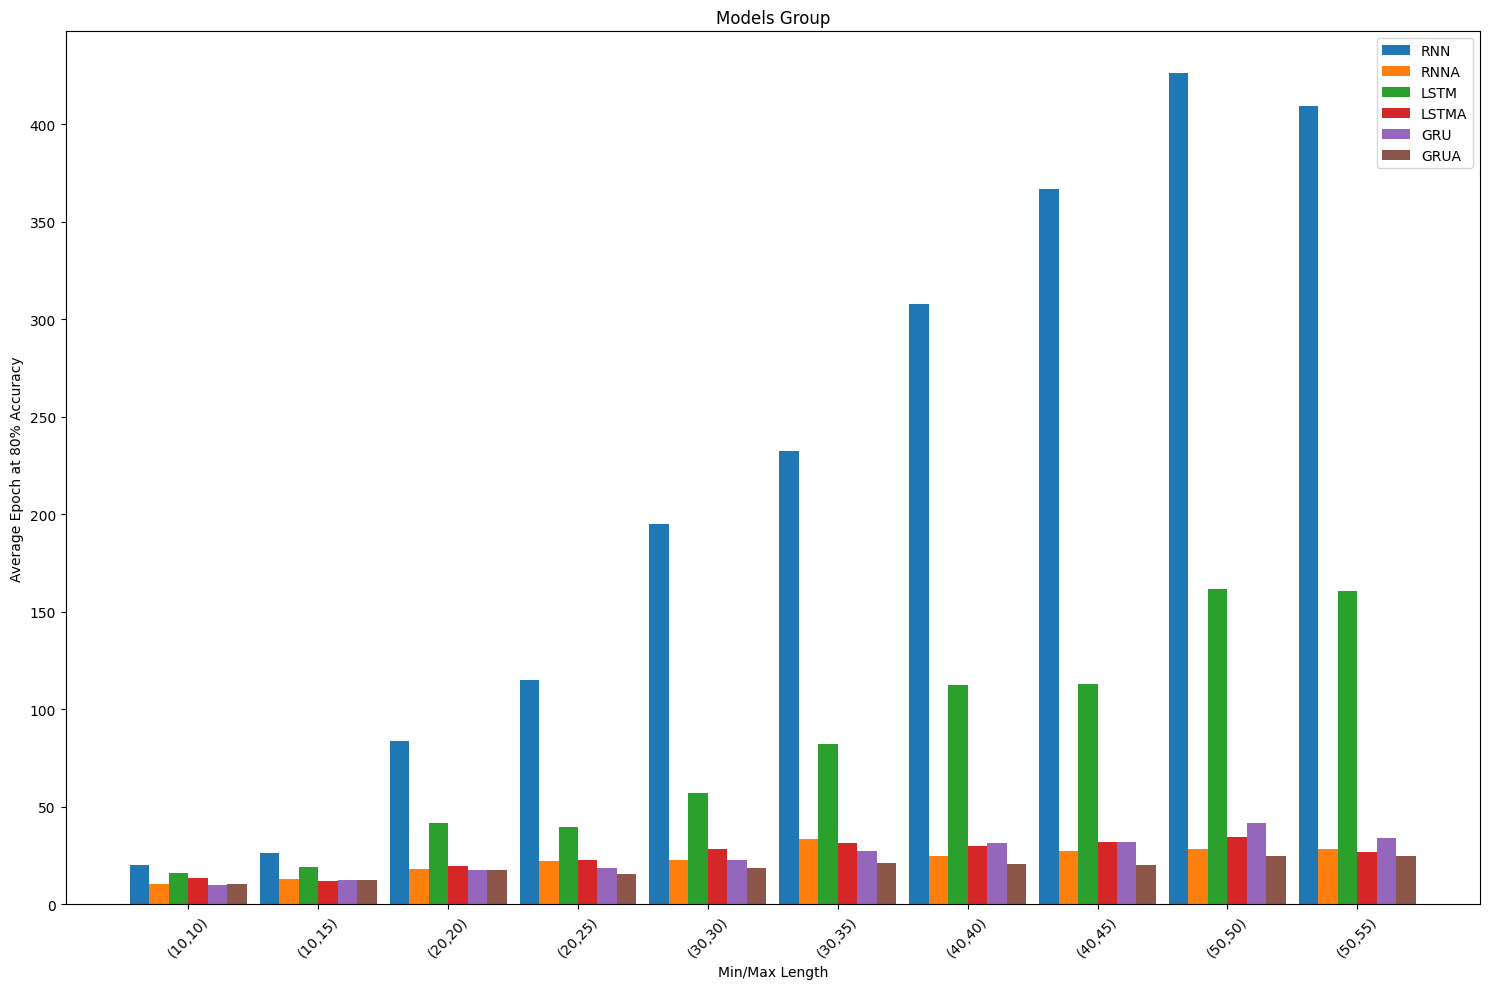

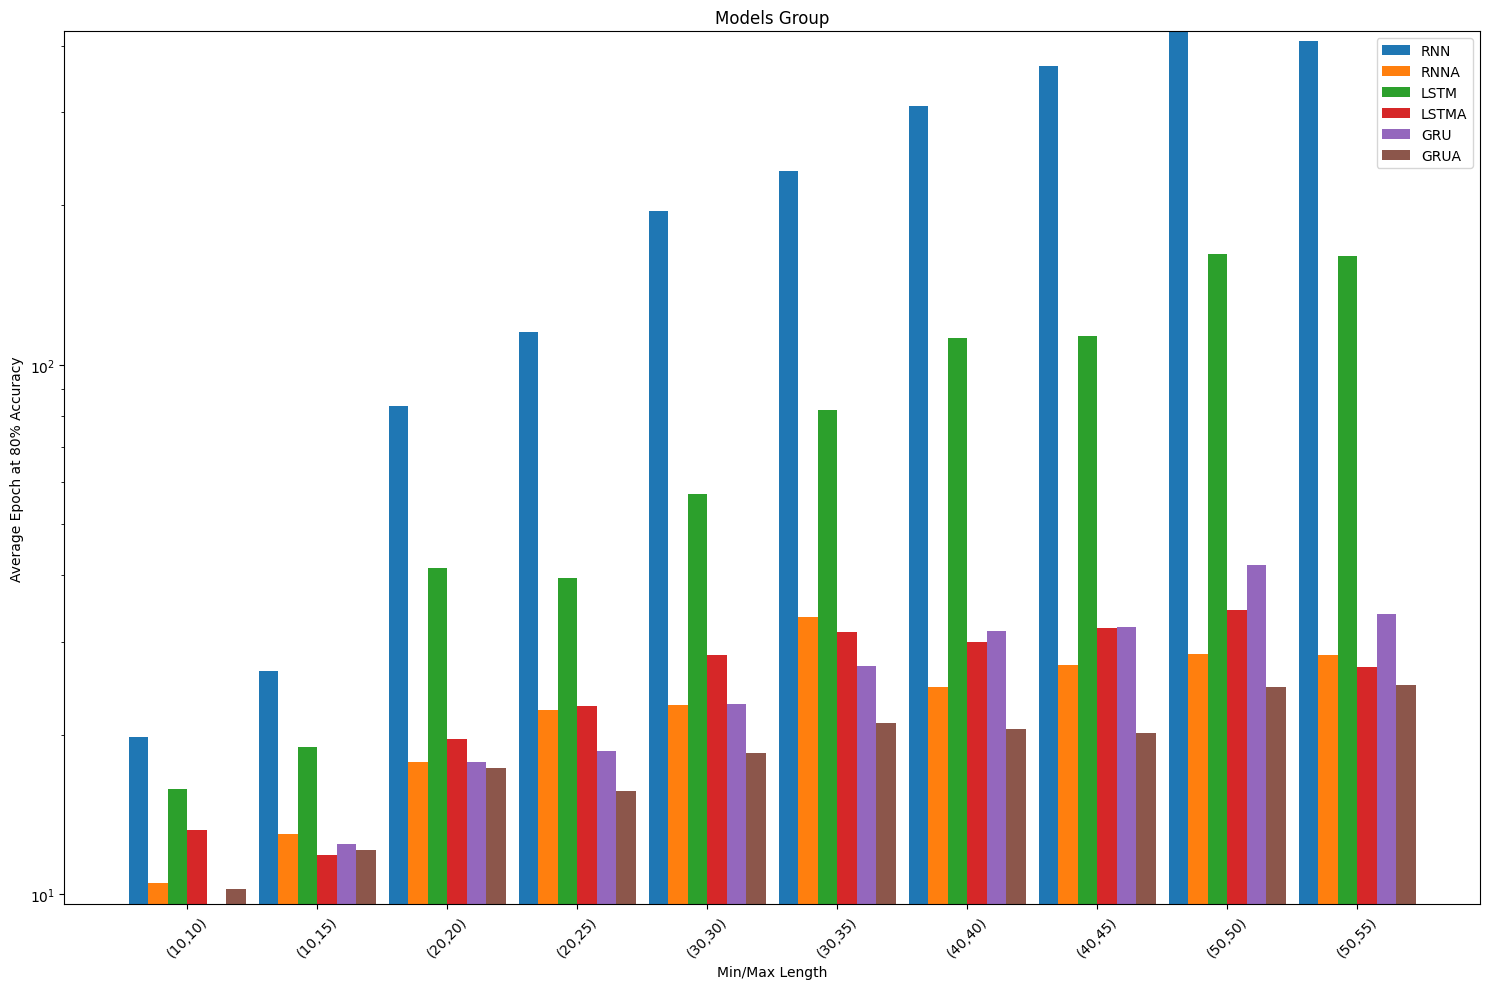

In [86]:
# Model groups
model_groups = {
    "Models": ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA" ],
}

min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = {group: [] for group in model_groups}

# Gathering data for the bar plot
for group_name, kinds in model_groups.items():
    group_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        kind_avg_epochs = []

        for kind in kinds:
            epochs_to_80_percent = []

            for rep in range(num_reps):
                filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
                try:
                    data = pd.read_csv(filename)
                    data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                    if skip_condition(data):
                        continue
                    epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                    if epoch is not None:
                        epochs_to_80_percent.append(epoch)
                except FileNotFoundError:
                    print(f"File not found: {filename}")
                    continue

            if epochs_to_80_percent:
                avg_epoch = np.mean(epochs_to_80_percent)
                kind_avg_epochs.append(avg_epoch)
            else:
                kind_avg_epochs.append(None)

        group_results.append(kind_avg_epochs)
    results[group_name] = group_results

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Create a subplot for each model group
for i, (group_name, group_kinds) in enumerate(model_groups.items()):
    ax = plt.subplot(len(model_groups), 1, i + 1)  # One row for each group
    bar_positions = np.arange(len(min_lengths))  # One set of bars for each min/max length combination

    # Plot the bars for each kind in the group
    bar_width = 0.15
    for j, kind in enumerate(group_kinds):
        kind_results = [result[j] for result in results[group_name]]  # Get results for this kind
        ax.bar(bar_positions + j * bar_width, kind_results, width=bar_width, label=kind)

    # Set up the plot
    ax.set_title(f"{group_name} Group")
    ax.set_xticks(bar_positions + bar_width * (len(group_kinds) - 1) / 2)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


all_epochs = [epoch for group_results in results.values() for kind_results in group_results for epoch in kind_results if epoch is not None]
global_min = min(all_epochs)
global_max = max(all_epochs)


# Version 2: Consistent Logarithmic Scale
plt.figure(figsize=(15, 10))
for i, (group_name, group_kinds) in enumerate(model_groups.items()):
    ax = plt.subplot(len(model_groups), 1, i + 1)
    bar_positions = np.arange(len(min_lengths))
    bar_width = 0.15
    for j, kind in enumerate(group_kinds):
        kind_results = [result[j] for result in results[group_name]]
        ax.bar(bar_positions + j * bar_width, kind_results, width=bar_width, label=kind)
    ax.set_title(f"{group_name} Group")
    ax.set_xticks(bar_positions + bar_width * (len(group_kinds) - 1) / 2)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.set_yscale('log')  # Logarithmic scale
    ax.set_ylim(global_min, global_max)  # Consistent scale
    ax.legend()
plt.tight_layout()
plt.show()


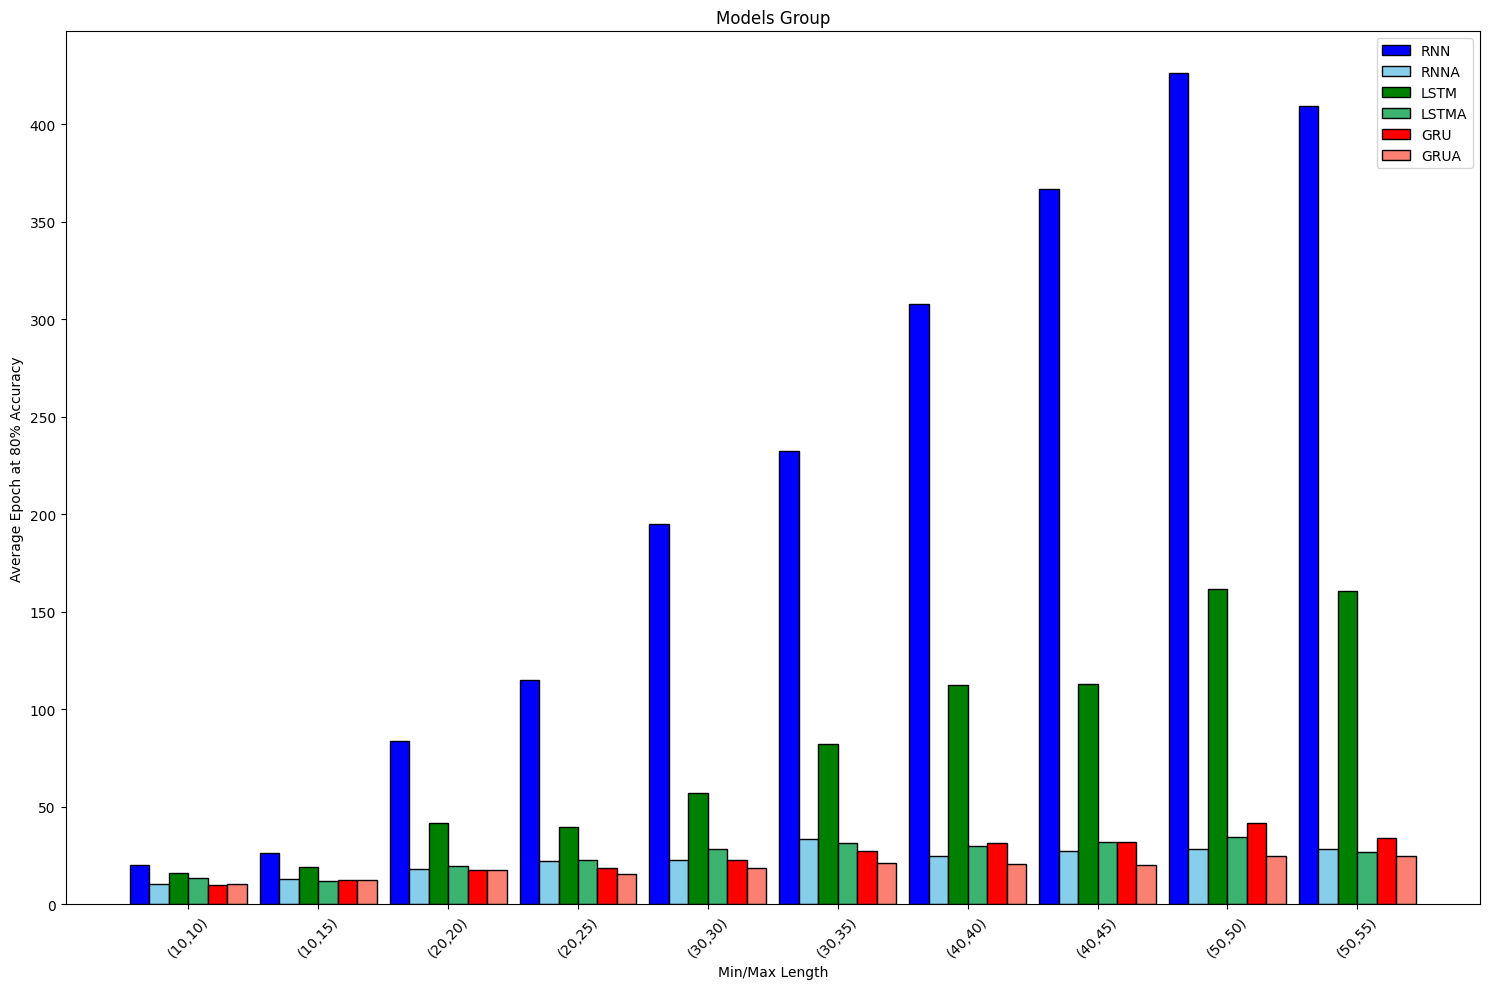

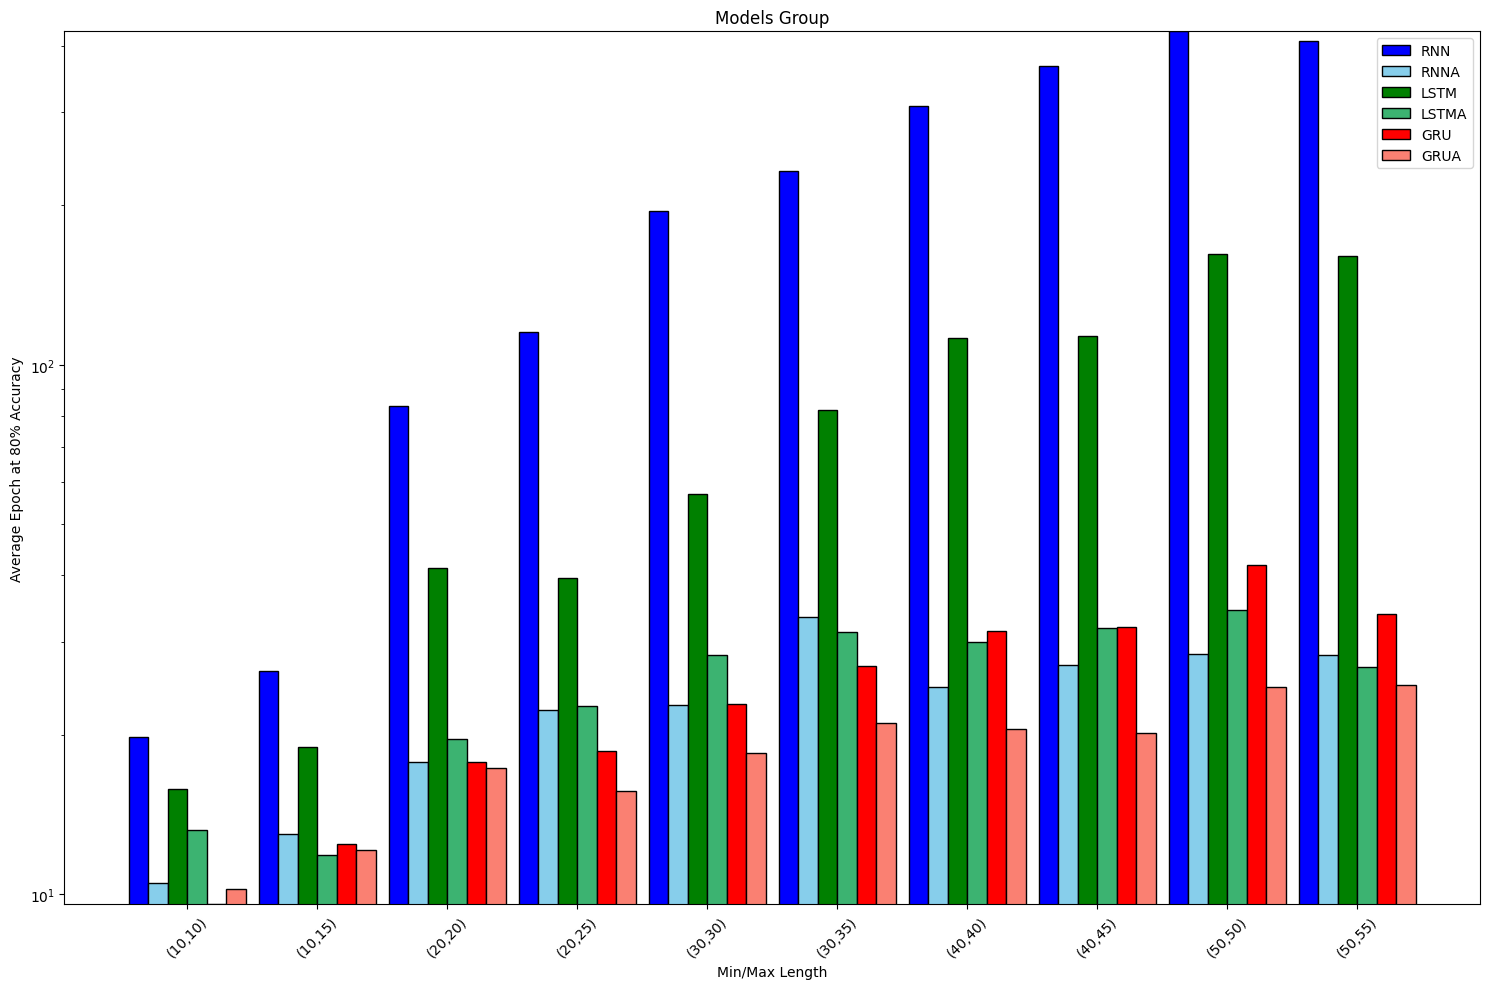

In [87]:
# Model groups
model_groups = {
    "Models": ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA" ],
}

min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = {group: [] for group in model_groups}

# Gathering data for the bar plot
for group_name, kinds in model_groups.items():
    group_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        kind_avg_epochs = []

        for kind in kinds:
            epochs_to_80_percent = []

            for rep in range(num_reps):
                filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
                try:
                    data = pd.read_csv(filename)
                    data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                    if skip_condition(data):
                        continue
                    epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                    if epoch is not None:
                        epochs_to_80_percent.append(epoch)
                except FileNotFoundError:
                    print(f"File not found: {filename}")
                    continue

            if epochs_to_80_percent:
                avg_epoch = np.mean(epochs_to_80_percent)
                kind_avg_epochs.append(avg_epoch)
            else:
                kind_avg_epochs.append(None)

        group_results.append(kind_avg_epochs)
    results[group_name] = group_results

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed


# Define colors for each model kind
colors = {
    "RNN": "blue", "RNNA": "skyblue",  # Adjusted to skyblue for better visibility
    "LSTM": "green", "LSTMA": "mediumseagreen",  # Adjusted to mediumseagreen
    "GRU": "red", "GRUA": "salmon"  # Adjusted to salmon
}
# Create a subplot for each model group
for i, (group_name, group_kinds) in enumerate(model_groups.items()):
    ax = plt.subplot(len(model_groups), 1, i + 1)  # One row for each group
    bar_positions = np.arange(len(min_lengths))  # One set of bars for each min/max length combination

    # Plot the bars for each kind in the group
    bar_width = 0.15
    for j, kind in enumerate(group_kinds):
        kind_results = [result[j] for result in results[group_name]]  # Get results for this kind
        ax.bar(bar_positions + j * bar_width, kind_results, width=bar_width, label=kind,color=colors[kind],edgecolor='black')

    # Set up the plot
    ax.set_title(f"{group_name} Group")
    ax.set_xticks(bar_positions + bar_width * (len(group_kinds) - 1) / 2)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()

# Find global min and max for the logarithmic y-axis scale
all_epochs = [epoch for group_results in results.values() for kind_results in group_results for epoch in kind_results if epoch is not None]
global_min = min(all_epochs)
global_max = max(all_epochs)


# Version with Consistent Logarithmic Scale and Specific Colors
plt.figure(figsize=(15, 10))
for i, (group_name, group_kinds) in enumerate(model_groups.items()):
    ax = plt.subplot(len(model_groups), 1, i + 1)
    bar_positions = np.arange(len(min_lengths))
    bar_width = 0.15
    for j, kind in enumerate(group_kinds):
        kind_results = [result[j] for result in results[group_name]]
        ax.bar(bar_positions + j * bar_width, kind_results, width=bar_width, label=kind, color=colors[kind],edgecolor='black')
    ax.set_title(f"{group_name} Group")
    ax.set_xticks(bar_positions + bar_width * (len(group_kinds) - 1) / 2)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.set_yscale('log')
    ax.set_ylim(global_min, global_max)
    ax.legend()
plt.tight_layout()
plt.show()


# Representation plots


In [12]:
# This function calculates the entropy of a dataset D using the Shannon entropy formula. Entropy is a measure of the unpredictability or randomness of the data.
def symbolEntropy(D, base=2):
    value, counts = numpy.unique(D, return_counts=True)  # Find unique values and their frequency in D
    return entropy(counts, base=base)  # Calculate and return the Shannon entropy

# This function seems to compute a complex metric, possibly related to information theory, involving inputs I, hidden states H, and outputs O.
def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    # Create various combinations of Inputs (I), Hidden states (H), and Outputs (O) for analysis
    # B, IB, AB, BO, IAB, IBO, ABO, IABO are different combinations of I, H, and O
    # Calculate entropy for each combination using symbolEntropy
    # Return a specific information metric combining these entropies


    #print("I H O",I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

# This function seems to analyze how information is processed or transmitted through a network, focusing on individual components (nodes) of the hidden states H.
def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes = list(range(width))  # Initialize a list of node indices
    cols = []  # To store subsets of nodes
    colh = []  # To store corresponding information values
    # Iteratively remove a node, compute information value, and record subsets and values
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh


# This function processes the output of a model given a dataset. It appears to involve some form of clustering (using KMeans) and then re-encoding the hidden states H.
def getOutTaH(model,dataSet):
    O, H = model.step(torch.Tensor(dataSet))  # Get output and hidden states from the model
    # Transform H using clustering and re-encoding

    #print(H.shape,H.min(),H.max())
    #figure()
    #hist(H.flatten())

    H = H.transpose()  # Transpose H for processing
    O = O.transpose()  # Transpose O for processing
    B = numpy.zeros(H.shape)  # Initialize a matrix to store cluster labels for each hidden state
    # Apply KMeans clustering to each hidden state
    # Recompute H as a combination of cluster labels (B)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        x =len(numpy.unique(a))
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr,n_init=10).fit(a)
        B[i]=kmeans.labels_
        #B[i]=1.0*(H[i]>numpy.median(H[i]))


    H=numpy.zeros((H.shape))
    for i in range(12):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return O,H

# This function seems to integrate the previous functions to analyze how information flows through the network for different input-output pairs in a dataset.
def shrinkingDecompositionInformation(model,width,dataSet,target,numbers=[0,1,2],whichTS=5,dsLength=8):
    output, H = getOutTaH(model, dataSet)  # Get transformed outputs and hidden states from the model
    # Slice output and H to process only specific timesteps
    output=output.transpose()[whichTS::dsLength].transpose()

    #print("target.shape",target.shape,"output.shape",output.shape,"H.shape",H.shape,"dataset.shape",dataSet.shape)
    H=H.transpose()[whichTS::dsLength].transpose()
    #target=target.transpose()[whichTS::dsLength].transpose()
    #print(H.shape,target.shape,numpy.array(range(512))[whichTS::dsLength])

    collectorSet = dict()  # To store information about subsets of nodes (S)
    collectorH = dict()    # To store information values (H)
    # Compute shrinking decomposition information for selected inputs/outputs
    for number in numbers:
        I=target[number].astype(int)
        O=(1.0*(output[number]>0.5)).astype(int)
        #print("O",O,"T",target[number])
        #print(number,"I.shape",I.shape,"O.shape",O.shape,"H.shape",H.shape)
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH


# These functions convert the results of the shrinking decomposition into vector and matrix forms, which are likely used for further analysis or visualization.
def removalIntoVec(res,width,H):
    # Convert the shrinking decomposition results into a vector form

    V = numpy.zeros(width)  # Initialize a vector
    # Calculate values for V based on the difference in information values (H) as nodes are removed
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)

    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]

    #V=sqrt(V)
    if V.sum()==0:
        return V
    return V#/V.max()

def removalIntoMatrix(res,width,H):
    # Convert the shrinking decomposition results into a matrix form

    M=[]
    # Convert the shrinking decomposition results (S and H) into a matrix form
    # This matrix can be used for visualization or further analysis
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)

C:\Users\ahmad\AppData\Local\Temp\ipykernel_6844\1455339256.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  o = modelRNNWithAttention.attention(torch.Tensor(s))


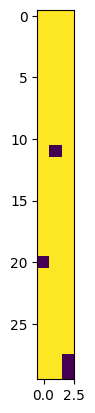

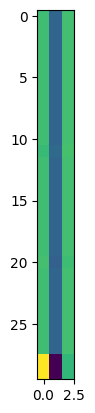

<Figure size 640x480 with 0 Axes>

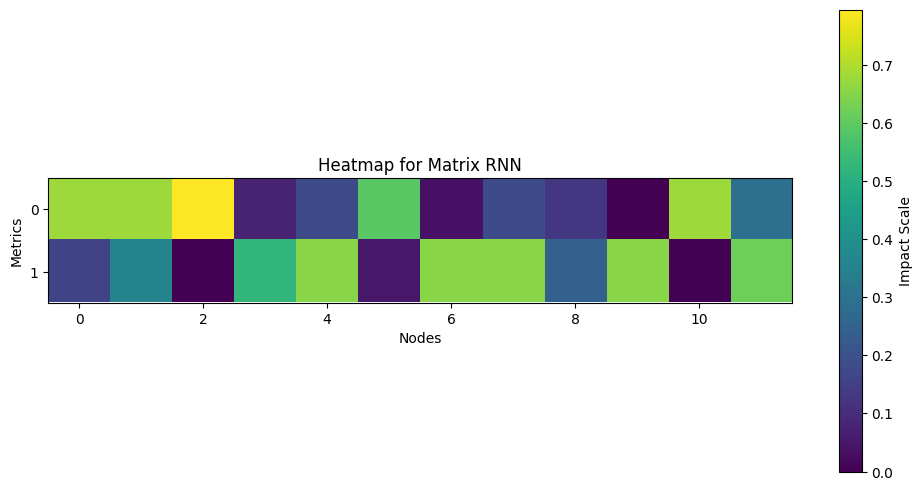

<Figure size 640x480 with 0 Axes>

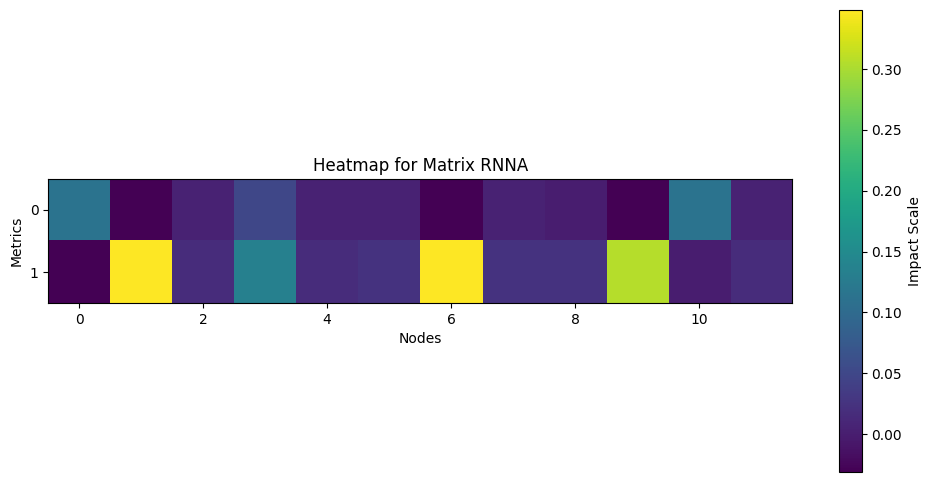

In [13]:
modelRNN=torch.load("./dataModel/model_RNN_min_30_max_35_rep_16.model")
modelRNNWithAttention=torch.load("./dataModel/model_RNNA_min_30_max_35_rep_16.model")


s,t = generateTrainData(100, [30,30]) 
o = modelRNNWithAttention.attention(torch.Tensor(s)) 
#print(o)
imshow(s[2])
figure()
imshow(o.detach().numpy()[2])
S,H=shrinkingDecompositionInformation(modelRNN,12,s,t.transpose(),numbers = [0,1],whichTS=29,dsLength=30)
figure()
M1 = removalIntoMatrix(S,12,H)
#print(f"M1 {M1}")
#imshow(M1)
plt.figure(figsize=(12, 6))
plt.imshow(M1)
plt.colorbar(label='Impact Scale')
plt.title('Heatmap for Matrix RNN')
plt.xlabel('Nodes')
plt.ylabel('Metrics')
plt.yticks([0, 1], ['0', '1'])  # Setting y-axis labels to 0 and 1
plt.show()

S,H=shrinkingDecompositionInformation(modelRNNWithAttention,12,s,t.transpose(),numbers = [0,1],whichTS=29,dsLength=30)
figure()

M2 = removalIntoMatrix(S,12,H)
#print(f"M2 {M2}")
#imshow(M2)
plt.figure(figsize=(12, 6))
plt.imshow(M2)
plt.colorbar(label='Impact Scale')
plt.title('Heatmap for Matrix RNNA')
plt.xlabel('Nodes')
plt.ylabel('Metrics')
plt.yticks([0, 1], ['0', '1'])  # Setting y-axis labels to 0 and 1
plt.show()

# Calculations


In [14]:
def shannon_entropy(matrix):
    probabilities = matrix.flatten().astype(float)  # Convert to float
    total = np.sum(probabilities)
    if total > 0:
        probabilities /= total
    else:
        return 0  # Avoid division by zero; entropy is undefined for empty distribution

    # Compute Shannon entropy
    entropy = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    return entropy


In [15]:
def kmeans_thresholding(matrix, random_state=42):
    # Flatten the matrix
    flat_matrix = matrix.flatten()

    # Apply KMeans clustering with a fixed random state for reproducibility
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=random_state).fit(flat_matrix.reshape(-1, 1))

    centroids = kmeans.cluster_centers_.flatten()

    # Check if there are two centroids (clusters) and handle accordingly
    if len(centroids) > 1:
        # Determine threshold - you may choose a different method here
        threshold = np.mean(centroids)
    else:
        # If only one centroid (unlikely, but possible), use it as the threshold
        threshold = centroids[0]

    # Count the number of elements exceeding the threshold
    count_exceeding = np.sum(flat_matrix > threshold)

    return threshold, count_exceeding

# Apply KMeans thresholding to M1 and M2
threshold_M1, count_exceeding_M1 = kmeans_thresholding(M1)
threshold_M2, count_exceeding_M2 = kmeans_thresholding(M2)

(threshold_M1, count_exceeding_M1, threshold_M2, count_exceeding_M2)

(0.3936126385812114, 11, 0.1776090836079873, 3)

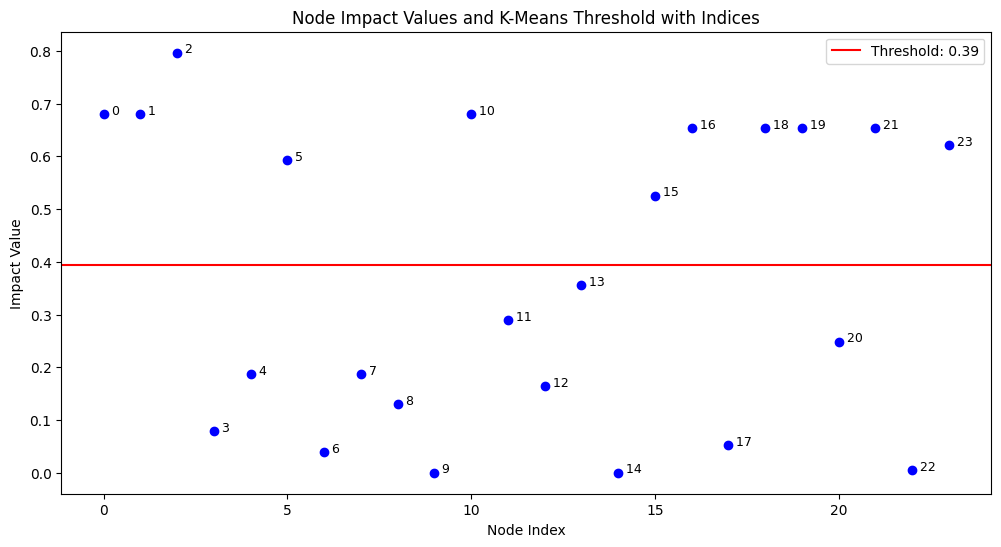

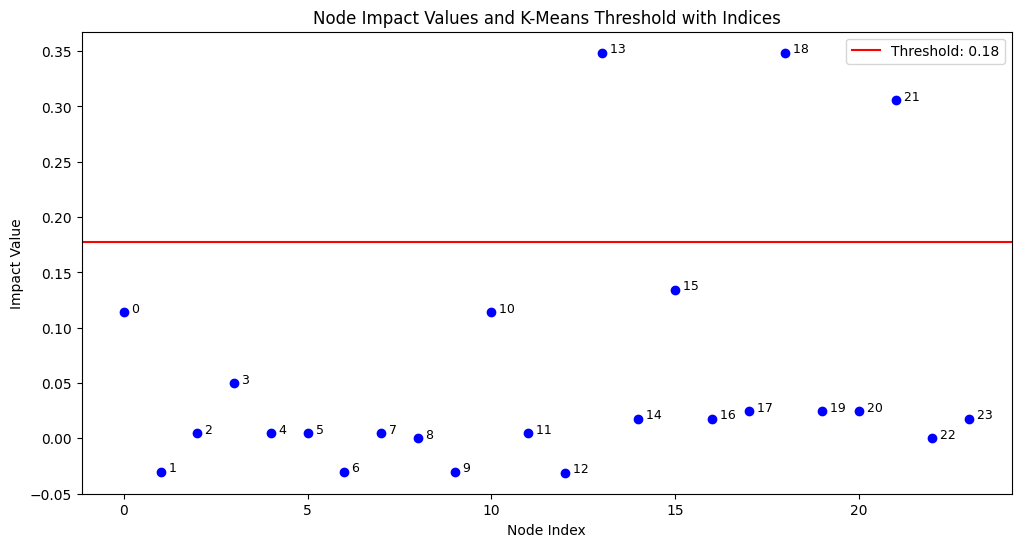

In [16]:
def plot_kmeans_thresholding_with_index(matrix, threshold):
    # Flatten the matrix
    flat_matrix = matrix.flatten()

    # Generate indices for each point in the flattened matrix
    indices = range(len(flat_matrix))

    # Plot the flattened matrix values and the threshold line
    plt.figure(figsize=(12, 6))
    for index, value in zip(indices, flat_matrix):
        plt.scatter(index, value, color='blue')
        #plt.text(index, value, str(index) + " " + str(value), fontsize=9)
        plt.text(index, value, "  " +str(index), fontsize=9)

    plt.axhline(y=threshold, color='red', linestyle='-', label=f'Threshold: {threshold:.2f}')
    plt.xlabel('Node Index')
    plt.ylabel('Impact Value')
    plt.title('Node Impact Values and K-Means Threshold with Indices')
    plt.legend()
    plt.show()

# Apply KMeans thresholding to M1 and M2
threshold_M1, count_exceeding_M1 = kmeans_thresholding(M1)
threshold_M2, count_exceeding_M2 = kmeans_thresholding(M2)

# Plotting for M1 and M2 with indices
plot_kmeans_thresholding_with_index(M1, threshold_M1)
plot_kmeans_thresholding_with_index(M2, threshold_M2)

In [17]:
def threshold_binarize_matrix(matrix, threshold):
    # Flatten the matrix
    flat_matrix = matrix.flatten()

    # Apply thresholding
    binarized_matrix = np.where(flat_matrix >= threshold, 1, 0)

    # Reshape to the original matrix shape
    binarized_matrix = binarized_matrix.reshape(matrix.shape)

    return binarized_matrix



In [18]:
def calculate_counts(matrix):
    transposed_matrix = matrix.T
    count_11, count_00, count_mixed = 0, 0, 0
    for row in transposed_matrix:
        if np.array_equal(row, [1, 1]):
            count_11 += 1
        elif np.array_equal(row, [0, 0]):
            count_00 += 1
        else:
            count_mixed += 1
    return count_11, count_00, count_mixed

In [214]:
skipped_models

[]

## One sample of calculations for all models on a random repetition


In [19]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]  # Assuming you have these types
min_lengths = [30]
max_lengths = [35]
rep = 7

model_matrices = {}

# Loop for gathering data
for min_len, max_len in zip(min_lengths, max_lengths):
    for kind in kinds:
        #for rep in range(num_reps):
        filename = f"./dataModel/model_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.model"
        model_identifier = model_identifier = f'{kind}-{min_len}-{max_len}-{rep}'

        try:
            # Load the model
            model = torch.load(filename)
            s, t = generateTrainData(100, [min_len, min_len])
            S, H = shrinkingDecompositionInformation(model, 12, s, t.transpose(), numbers=[0, 1], whichTS=min_len - 1, dsLength=min_len)
            M = removalIntoMatrix(S, 12, H)  # Assuming you have this function defined
            model_matrices[model_identifier] = M
        except FileNotFoundError:
            print(f"File not found: {filename}")
            continue   
        

In [20]:
# List to hold data for DataFrame
df_m = []

# Loop through the model_matrices dictionary
for model_identifier, M in model_matrices.items():
    # Create a dictionary for each model with its identifier and matrix
    model_data = {
        'Model Identifier': model_identifier,
        'Matrix': M
    }
    df_m.append(model_data)

# Create DataFrame from the list of dictionaries
models_M = pd.DataFrame(df_m)

# Display the DataFrame
print(models_M)

  Model Identifier                                             Matrix
0      RNN-30-35-7  [[0.06178301360047955, 0.9985790746479424, 0.2...
1     RNNA-30-35-7  [[0.00023223832979457626, 0.03959675766724047,...
2     LSTM-30-35-7  [[0.061872828746194486, 0.9893781929232679, 0....
3    LSTMA-30-35-7  [[0.0, 0.0, -4.440892098500626e-16, -4.4408920...
4      GRU-30-35-7  [[0.9603113655986273, 0.9927624905769932, 0.94...
5     GRUA-30-35-7  [[-0.0661011741351869, 0.008407419694352214, 0...


In [21]:
results = []

for model_identifier, M in model_matrices.items():
    # Extract model details from the identifier
    kind, min_len, max_len, rep = model_identifier.split('-')           
            
    # Calculate metrics
    sum_abs = np.sum(np.abs(M))
    mean = np.mean(M)
    std = np.std(M)
    max_val = np.max(M)
    min_val = np.min(M)
    
    threshold_A, count_exceeding_A = kmeans_thresholding(M[0]) # fix this K means of A alone then B alone
    threshold_B, count_exceeding_B = kmeans_thresholding(M[1]) # fix this K means of A alone then B alone
    
    binarized_matrix_A = np.where(M[0].flatten() >= threshold_A, 1, 0).reshape(M[0].shape) 
    binarized_matrix_B = np.where(M[1].flatten() >= threshold_B, 1, 0).reshape(M[1].shape)
    binarized_count_exceeding_A = np.sum(binarized_matrix_A > threshold_A)
    binarized_count_exceeding_B = np.sum(binarized_matrix_B > threshold_B)
    # Vertically stack binarized_matrix_A and binarized_matrix_B
    binarized_combined_matrix = np.vstack([binarized_matrix_A, binarized_matrix_B])
    
    entropy_s = shannon_entropy(binarized_combined_matrix) # entropy_s done ont he binarized 
    count_11, count_00, count_mixed = calculate_counts(binarized_combined_matrix)
    ratio_11_00_mixed = count_11 / (count_mixed + count_00  + 1)  if (count_mixed + count_00) != 0 else 0 # justify the +1 
    ratio_11_mixed = count_11 / (count_mixed  + 1)  if count_mixed != 0 else 0 # justify the +1 
    # Get the minimum values along axis 0
    min_values = np.min(M, axis=0)

    # Clip these values between 0 and 1
    clipped_min_values = np.clip(min_values, 0, 1)

    # Sum the clipped values
    sum_clipped_min_values = np.sum(clipped_min_values) # fixed this


    metrics = {
        "Kind": kind,
        "Min_Length": min_len,
        "Max_Length": max_len,
        "Repetition": rep,
        "Sum of Absolute Values": round(sum_abs,4),
        "Mean Value": round(mean,4),
        "Standard Deviation": round(std, 4),
        "Shannon Entropy": round(entropy_s, 4),
        "Maximum Value": round(max_val,4),
        "Minimum Value": round(min_val,4),
        "Kmeans Threshold_A": round(threshold_A,4),
        "Kmeans Threshold_B": round(threshold_B,4),
        "Kmeans Nodes A Exceeding Treshhold = 1": binarized_count_exceeding_A,
        "Kmeans Nodes B Exceeding Treshhold = 1": binarized_count_exceeding_B,
        "count_11": count_11,
        "count_00":count_00,
        "count_mixed":count_mixed,
        "Overlap % with zeroes": round(ratio_11_00_mixed,4),
        "Overlap % no zeroes": round(ratio_11_mixed,4),
        "Sum of min": round(sum_clipped_min_values,4) 
    }

    results.append(metrics)



df_one_sample = pd.DataFrame(results)

df_one_sample




Kind Min_Length Max_Length Repetition  Sum of Absolute Values  Mean Value  \
0    RNN         30         35          7                 11.9242      0.4968   
1   RNNA         30         35          7                  0.3718      0.0151   
2   LSTM         30         35          7                 11.3490      0.4729   
3  LSTMA         30         35          7                  0.0000     -0.0000   
4    GRU         30         35          7                 14.2785      0.5949   
5   GRUA         30         35          7                  3.0798      0.1058   

   Standard Deviation  Shannon Entropy  Maximum Value  Minimum Value  \
0              0.4209           3.5850         0.9986         0.0000   
1              0.0195           3.1699         0.0601        -0.0021   
2              0.3424           3.8074         0.9894         0.0000   
3              0.0000           2.8074         0.0000        -0.0000   
4              0.3953           3.7004         0.9928         0.0000   
5              0.1395           3.7004         0.3774        -0.0709   

   Kmeans Threshold_A  Kmeans Threshold_B  \
0              0.5598              0.4339   
1              0.0166              0.0273   
2              0.5071              0.3310   
3             -0.0000              0.0000   
4              0.5415              0.5726   
5              0.0152              0.1758   

   Kmeans Nodes A Exceeding Treshhold = 1  \
0                                       6   
1                                       7   
2                                       8   
3                                      12   
4                                       8   
5                                       6   

   Kmeans Nodes B Exceeding Treshhold = 1  count_11  count_00  count_mixed  \
0                                       6         0         0           12   
1                                       2         1         4            7   
2                                       6         2         0           10   
3                                       3         1         6            5   
4                                       5         1         0           11   
5                                       7         4         3            5   

   Overlap % with zeroes  Overlap % no zeroes  Sum of min  
0                 0.0000               0.0000      1.1953  
1                 0.0833               0.1250      0.0396  
2                 0.1818               0.1818      2.4416  
3                 0.0833               0.1667      0.0000  
4                 0.0833               0.0833      2.7987  
5                 0.4444               0.6667      0.3328

We noticed that we have consistent results for models with attention having lower results then the base models for mean. overlap and shannon. we tried running it for different reps below is the code running all models and each rep


## Comparing base models with attention models


In [221]:
results2 = []

# Compare each pair of models
for kind1, kind2 in [("RNN", "RNNA"), ("LSTM", "LSTMA"), ("GRU", "GRUA")]:
    #for rep in range(num_reps):
    model_id1 = f'{kind1}-{min_len}-{max_len}-{rep}'
    model_id2 = f'{kind2}-{min_len}-{max_len}-{rep}'

    if model_id1 in model_matrices and model_id2 in model_matrices:
        M1 = model_matrices[model_id1]
        M2 = model_matrices[model_id2]

        # Calculate metrics between the two models
        similarity = cosine_similarity(M1.reshape(1, -1), M2.reshape(1, -1))[0, 0]
        similarity_1 = cosine_similarity(M1[0].reshape(1, -1), M2[0].reshape(1, -1))[0, 0]
        similarity_2 = cosine_similarity(M1[1].reshape(1, -1), M2[1].reshape(1, -1))[0, 0]
        pair_metrics = {
            "Model_Pair": f"{kind1}-{kind2}",
            "Repetition": rep,
            "Overall Similarity": similarity,
            "Similarity_A": similarity_1,
            "Similarity_B": similarity_2,
        }
        results2.append(pair_metrics)

# Convert results to DataFrame
df_models = pd.DataFrame(results2)


In [222]:
df_models

Model_Pair Repetition  Overall Similarity  Similarity_A  Similarity_B
0    RNN-RNNA          7        5.097080e-01  5.615465e-01  4.206497e-01
1  LSTM-LSTMA          7        2.308739e-16  1.845967e-16  1.406389e-16
2    GRU-GRUA          7        3.482575e-01  5.034221e-01  4.243749e-01

1. **Cosine Similarity**
   - **Measurement**: Calculated as the cosine of the angle between two vectors. It's given by the dot product of the vectors divided by the product of their magnitudes.
   - **Range**: Ranges from -1 to 1.
   - **Interpretation**:
     - 1 indicates that the vectors are in the same direction (perfectly similar).
     - 0 indicates orthogonality (no similarity).
     - -1 indicates that the vectors are in opposite directions (completely dissimilar).


## data frame for each repetition and their calculations


In [223]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]  # Assuming you have these types
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

model_matrices = {}

# Loop for gathering data
for min_len, max_len in zip(min_lengths, max_lengths):
    for kind in kinds:
        for rep in range(num_reps):
            filename = f"./dataModel/model_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.model"
            model_identifier = model_identifier = f'{kind}-{min_len}-{max_len}-{rep}'

            try:
                # Load the model
                model = torch.load(filename)
                s, t = generateTrainData(100, [min_len, min_len])
                S, H = shrinkingDecompositionInformation(model, 12, s, t.transpose(), numbers=[0, 1], whichTS=min_len - 1, dsLength=min_len)
                M = removalIntoMatrix(S, 12, H)  # Assuming you have this function defined
                model_matrices[model_identifier] = M
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue   

In [224]:
# List to hold data for DataFrame
df_m = []

# Loop through the model_matrices dictionary
for model_identifier, M in model_matrices.items():
    # Create a dictionary for each model with its identifier and matrix
    model_data = {
        'Model Identifier': model_identifier,
        'Matrix': M
    }
    df_m.append(model_data)

# Create DataFrame from the list of dictionaries
models_M = pd.DataFrame(df_m)

# Display the DataFrame
print(models_M)

     Model Identifier                                             Matrix
0         RNN-10-10-0  [[0.9639839042163247, 0.7765106634983319, 0.26...
1         RNN-10-10-1  [[-0.006559175691294161, -0.03145561249619888,...
2         RNN-10-10-2  [[0.9997113262447908, 0.4896291715646095, 0.26...
3         RNN-10-10-3  [[0.9927481269466876, 0.022865655232152893, 0....
4         RNN-10-10-4  [[0.9972332586505388, 0.776842258477461, 0.997...
...               ...                                                ...
1855    GRUA-50-55-26  [[0.2495030102765663, 0.26950301027656676, 0.0...
1856    GRUA-50-55-27  [[0.023804899491454368, 0.016976091685533046, ...
1857    GRUA-50-55-28  [[0.09266650802858534, 0.00401955336901505, 0....
1858    GRUA-50-55-29  [[0.01972823719082495, 0.01972823719082495, 0....
1859    GRUA-50-55-30  [[-0.00017931966805617705, -0.0001793196680561...

[1860 rows x 2 columns]


In [225]:
models_M.to_csv("models_M.csv")

In [ ]:
results = []

for model_identifier, M in model_matrices.items():
    # Extract model details from the identifier
    kind, min_len, max_len, rep = model_identifier.split('-')           
            
    # Calculate metrics
    sum_abs = np.sum(np.abs(M))
    mean = np.mean(M)
    std = np.std(M)
    max_val = np.max(M)
    min_val = np.min(M)
    
    threshold_A, count_exceeding_A = kmeans_thresholding(M[0]) # fix this K means of A alone then B alone
    threshold_B, count_exceeding_B = kmeans_thresholding(M[1]) # fix this K means of A alone then B alone
    
    binarized_matrix_A = np.where(M[0].flatten() >= threshold_A, 1, 0).reshape(M[0].shape) 
    binarized_matrix_B = np.where(M[1].flatten() >= threshold_B, 1, 0).reshape(M[1].shape)
    binarized_count_exceeding_A = np.sum(binarized_matrix_A > threshold_A)
    binarized_count_exceeding_B = np.sum(binarized_matrix_B > threshold_B)
    # Vertically stack binarized_matrix_A and binarized_matrix_B
    binarized_combined_matrix = np.vstack([binarized_matrix_A, binarized_matrix_B])
    
    entropy_s = shannon_entropy(binarized_combined_matrix) # entropy_s done ont he binarized 
    count_11, count_00, count_mixed = calculate_counts(binarized_combined_matrix)
    ratio_11_00_mixed = count_11 / (count_mixed + count_00 )  if (count_mixed + count_00) != 0 else 0 # justify the +1 
    ratio_11_mixed = count_11 / (count_mixed )  if count_mixed != 0 else 0 # justify the +1 
    # Get the minimum values along axis 0
    min_values = np.min(M, axis=0)

    # Clip these values between 0 and 1
    clipped_min_values = np.clip(min_values, 0, 1)

    # Sum the clipped values
    sum_clipped_min_values = np.sum(clipped_min_values) # fixed this


    metrics = {
        "Kind": kind,
        "Min_Length": min_len,
        "Max_Length": max_len,
        "Repetition": rep,
        "Sum of Absolute Values": round(sum_abs,4),
        "Mean Value": round(mean,4),
        "Standard Deviation": round(std, 4),
        "Shannon Entropy": round(entropy_s, 4),
        "Maximum Value": round(max_val,4),
        "Minimum Value": round(min_val,4),
        "Kmeans Threshold_A": round(threshold_A,4),
        "Kmeans Threshold_B": round(threshold_B,4),
        "Kmeans Nodes A Exceeding Treshhold = 1": binarized_count_exceeding_A,
        "Kmeans Nodes B Exceeding Treshhold = 1": binarized_count_exceeding_B,
        "count_11": count_11,
        "count_00":count_00,
        "count_mixed":count_mixed,
        "Overlap % with zeroes": round(ratio_11_00_mixed,4),
        "Overlap % no zeroes": round(ratio_11_mixed,4),
        "Sum of min": round(sum_clipped_min_values,4) 
    }

    results.append(metrics)



df = pd.DataFrame(results)



In [234]:
df

Kind Min_Length Max_Length Repetition  Sum of Absolute Values  \
0      RNN         10         10          0                  6.2473   
1      RNN         10         10          1                  5.2862   
2      RNN         10         10          2                  6.9492   
3      RNN         10         10          3                 13.3120   
4      RNN         10         10          4                 12.6645   
...    ...        ...        ...        ...                     ...   
1855  GRUA         50         55         26                  3.2721   
1856  GRUA         50         55         27                  0.8245   
1857  GRUA         50         55         28                  0.3239   
1858  GRUA         50         55         29                  1.6768   
1859  GRUA         50         55         30                  0.0408   

      Mean Value  Standard Deviation  Shannon Entropy  Maximum Value  \
0         0.2407              0.3007           3.1699         0.9640   
1         0.2099              0.2794           3.3219         0.8472   
2         0.2836              0.3098           3.0000         0.9997   
3         0.5547              0.4101           3.8074         0.9927   
4         0.5277              0.4307           3.5850         0.9972   
...          ...                 ...              ...            ...   
1855      0.1363              0.0901           4.4594         0.2695   
1856      0.0344              0.0513           3.8074         0.1992   
1857      0.0135              0.0248           2.3219         0.0927   
1858      0.0639              0.0726           3.8074         0.1704   
1859      0.0016              0.0034           2.8074         0.0091   

      Minimum Value  Kmeans Threshold_A  Kmeans Threshold_B  \
0           -0.0513              0.4158              0.1350   
1           -0.0599              0.1040              0.2993   
2           -0.0197              0.6318              0.1029   
3            0.0000              0.4952              0.4820   
4            0.0000              0.5693              0.4858   
...             ...                 ...                 ...   
1855         0.0000              0.1157              0.0330   
1856         0.0000              0.0126              0.0733   
1857         0.0000              0.0465              0.0148   
1858        -0.0194              0.0039              0.1067   
1859        -0.0002              0.0047              0.0000   

      Kmeans Nodes A Exceeding Treshhold = 1  \
0                                          6   
1                                          2   
2                                          3   
3                                          8   
4                                          7   
...                                      ...   
1855                                      11   
1856                                      10   
1857                                       2   
1858                                       6   
1859                                       4   

      Kmeans Nodes B Exceeding Treshhold = 1  count_11  count_00  count_mixed  \
0                                          3         0         3            9   
1                                          8         2         4            6   
2                                          5         0         4            8   
3                                          6         3         1            8   
4                                          5         1         1           10   
...                                      ...       ...       ...          ...   
1855                                      11        11         1            0   
1856                                       4         2         0           10   
1857                                       3         0         7            5   
1858                                       8         6         4            2   
1859                                       3         0         

In [232]:
df.to_csv("all_models_results.csv")

In [22]:
file_path = './all_models_results.csv'
df = pd.read_csv(file_path)


In [33]:
# Function to compare models and add original metrics for both
def compare_models_with_original_metrics(df, model, model_a, metrics):
    # Filter data for the two models
    df_model = df[df['Kind'] == model]
    df_model_a = df[df['Kind'] == model_a]

    # Initialize a list to store comparison results
    comparison_results = []

    # Iterate over each row in the model DataFrame
    for _, row in df_model.iterrows():
        # Find the matching row in the model_a DataFrame
        matching_row = df_model_a[(df_model_a['Min_Length'] == row['Min_Length']) &
                                  (df_model_a['Max_Length'] == row['Max_Length']) &
                                  (df_model_a['Repetition'] == row['Repetition'])]

        # If a matching row is found, calculate differences/ratios and include original metrics
        if not matching_row.empty:
            comparison = {'Kind': f'{model}_{model_a}',
                          'Min_Length': row['Min_Length'],
                          'Max_Length': row['Max_Length'],
                          'Repetition': row['Repetition']}

            # Add original metrics for both models
            for metric in metrics:
                comparison[f'{model} {metric}'] = row[metric]
                comparison[f'{model_a} {metric}'] = matching_row.iloc[0][metric]
                # Calculate the difference or ratio between the model and its A counterpart
                comparison[f'{metric} Difference'] = row[metric] - matching_row.iloc[0][metric]
                if matching_row.iloc[0][metric] != 0:  # Avoid division by zero
                    comparison[f'{metric} Ratio'] = row[metric] / matching_row.iloc[0][metric]
                else:
                    comparison[f'{metric} Ratio'] = None
            comparison_results.append(comparison)

    return comparison_results

# Define the metrics of interest for comparison
metrics_for_comparison = ['Shannon Entropy', 'Standard Deviation', 'Overlap % with zeroes', 'Overlap % no zeroes']

# Apply the comparison with original metrics for RNN with RNNA, LSTM with LTSMA, and GRU with GRUA
comparison_rnn_with_metrics = compare_models_with_original_metrics(df, 'RNN', 'RNNA', metrics_for_comparison)
comparison_lstm_with_metrics = compare_models_with_original_metrics(df, 'LSTM', 'LTSMA', metrics_for_comparison)
comparison_gru_with_metrics = compare_models_with_original_metrics(df, 'GRU', 'GRUA', metrics_for_comparison)
comparison_rnn_with_df = pd.DataFrame(comparison_rnn_with_metrics)

comparison_rnn_with_df

Kind  Min_Length  Max_Length  Repetition  RNN Shannon Entropy  \
0    RNN_RNNA          10          10           0               3.1699   
1    RNN_RNNA          10          10           1               3.3219   
2    RNN_RNNA          10          10           2               3.0000   
3    RNN_RNNA          10          10           3               3.8074   
4    RNN_RNNA          10          10           4               3.5850   
..        ...         ...         ...         ...                  ...   
305  RNN_RNNA          50          55          26               3.3219   
306  RNN_RNNA          50          55          27               3.5850   
307  RNN_RNNA          50          55          28               3.5850   
308  RNN_RNNA          50          55          29               3.4594   
309  RNN_RNNA          50          55          30               3.5850   

     RNNA Shannon Entropy  Shannon Entropy Difference  Shannon Entropy Ratio  \
0                  3.5850                     -0.4151               0.884212   
1                  3.4594                     -0.1375               0.960253   
2                  4.0000                     -1.0000               0.750000   
3                  3.1699                      0.6375               1.201110   
4                  3.8074                     -0.2224               0.941587   
..                    ...                         ...                    ...   
305                2.0000                      1.3219               1.660950   
306                4.2479                     -0.6629               0.843946   
307                4.0000                     -0.4150               0.896250   
308                3.7004                     -0.2410               0.934872   
309                3.3219                      0.2631               1.079202   

     RNN Standard Deviation  RNNA Standard Deviation  \
0                    0.3007                   0.1228   
1                    0.2794                   0.2182   
2                    0.3098                   0.0828   
3                    0.4101                   0.1774   
4                    0.4307                   0.1149   
..                      ...                      ...   
305                  0.4150                   0.0421   
306                  0.3750                   0.0064   
307                  0.3242                   0.0535   
308                  0.4139                   0.0002   
309                  0.4314                   0.0171   

     Standard Deviation Difference  Standard Deviation Ratio  \
0                           0.1779                  2.448697   
1                           0.0612                  1.280477   
2                           0.2270                  3.741546   
3                           0.2327                  2.311725   
4                           0.3158                  3.748477   
..                             ...                       ...   
305                         0.3729                  9.857482   
306                         0.3686                 58.593750   
307                         0.2707                  6.059813   
308                         0.4137               2069.500000   
309                         0.4143                 25.228070   

     RNN Overlap % with zeroes  RNNA Overlap % with zeroes  \
0                       0.0000                      0.0000   
1                       0.2000                      0.0909   
2                       0.0000                      0.5000   
3                       0.3333                      0.0000   
4                       0.0909                      0.2000   
..                         ...                         ...   
305                     0.0000                      0.0000   
306                     0.0000                      2.0000   
307                     0.0000                      2.0000   
308                     0.2000                      0.0909   
309                     0.0909     

In [32]:
# Combine the results into a single DataFrame
comparison_df_with_metrics = pd.DataFrame(comparison_rnn_with_metrics + comparison_lstm_with_metrics + comparison_gru_with_metrics)
comparison_df_with_metrics.head()  # Display the first few rows of the comparison results

Kind  Min_Length  Max_Length  Repetition  RNN Shannon Entropy  \
0  RNN_RNNA          10          10           0               3.1699   
1  RNN_RNNA          10          10           1               3.3219   
2  RNN_RNNA          10          10           2               3.0000   
3  RNN_RNNA          10          10           3               3.8074   
4  RNN_RNNA          10          10           4               3.5850   

   RNNA Shannon Entropy  Shannon Entropy Difference  Shannon Entropy Ratio  \
0                3.5850                     -0.4151               0.884212   
1                3.4594                     -0.1375               0.960253   
2                4.0000                     -1.0000               0.750000   
3                3.1699                      0.6375               1.201110   
4                3.8074                     -0.2224               0.941587   

   RNN Standard Deviation  RNNA Standard Deviation  ...  \
0                  0.3007                   0.1228  ...   
1                  0.2794                   0.2182  ...   
2                  0.3098                   0.0828  ...   
3                  0.4101                   0.1774  ...   
4                  0.4307                   0.1149  ...   

   Overlap % no zeroes Difference  Overlap % no zeroes Ratio  \
0                          0.0000                        NaN   
1                          0.2222                        3.0   
2                         -0.5000                        0.0   
3                          0.3750                        NaN   
4                         -0.1000                        0.5   

   GRU Shannon Entropy  GRUA Shannon Entropy  GRU Standard Deviation  \
0                  NaN                   NaN                     NaN   
1                  NaN                   NaN                     NaN   
2                  NaN                   NaN                     NaN   
3                  NaN                   NaN                     NaN   
4                  NaN                   NaN                     NaN   

   GRUA Standard Deviation  GRU Overlap % with zeroes  \
0                      NaN                        NaN   
1                      NaN                        NaN   
2                      NaN                        NaN   
3                      NaN                        NaN   
4                      NaN                        NaN   

   GRUA Overlap % with zeroes  GRU Overlap % no zeroes  \
0                         NaN                      NaN   
1                         NaN                      NaN   
2                         NaN                      NaN   
3                         NaN                      NaN   
4                         NaN                      NaN   

   GRUA Overlap % no zeroes  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  

[5 rows x 28 columns]

In [38]:
# Function to compare models and add only the differences for specified metrics
def compare_models_with_differences_only(df, model, model_a, metrics):
    # Filter data for the two models
    df_model = df[df['Kind'] == model]
    df_model_a = df[df['Kind'] == model_a]

    # Initialize a list to store comparison results
    comparison_results = []

    # Iterate over each row in the model DataFrame
    for _, row in df_model.iterrows():
        # Find the matching row in the model_a DataFrame
        matching_row = df_model_a[(df_model_a['Min_Length'] == row['Min_Length']) &
                                  (df_model_a['Max_Length'] == row['Max_Length']) &
                                  (df_model_a['Repetition'] == row['Repetition'])]

        # If a matching row is found, calculate differences for the specified metrics
        if not matching_row.empty:
            comparison = {'Kind': f'{model}_{model_a}',
                          'Min_Length': row['Min_Length'],
                          'Max_Length': row['Max_Length'],
                          'Repetition': row['Repetition']}

            # Add original metrics for both models and calculate the differences
            for metric in metrics:
                comparison[f'{model} {metric}'] = row[metric]
                comparison[f'{model_a} {metric}'] = matching_row.iloc[0][metric]
                comparison[f'{metric} Difference'] = row[metric] - matching_row.iloc[0][metric]
            
            comparison_results.append(comparison)

    return comparison_results

# Define the metrics of interest for comparison
metrics_for_differences = ['Shannon Entropy', 'Standard Deviation', 'Overlap % with zeroes', 'Overlap % no zeroes']

# Apply the comparison with differences only for RNN with RNNA, LSTM with LTSMA, and GRU with GRUA
comparison_rnn_diff = compare_models_with_differences_only(df, 'RNN', 'RNNA', metrics_for_differences)
comparison_lstm_diff = compare_models_with_differences_only(df, 'LSTM', 'LTSMA', metrics_for_differences)
comparison_gru_diff = compare_models_with_differences_only(df, 'GRU', 'GRUA', metrics_for_differences)


comparison_rnn_df = pd.DataFrame(comparison_rnn_diff)
comparison_lstm_df = pd.DataFrame(comparison_lstm_diff)
comparison_gru_df = pd.DataFrame(comparison_gru_diff)
comparison_rnn_df



Kind  Min_Length  Max_Length  Repetition  RNN Shannon Entropy  \
0    RNN_RNNA          10          10           0               3.1699   
1    RNN_RNNA          10          10           1               3.3219   
2    RNN_RNNA          10          10           2               3.0000   
3    RNN_RNNA          10          10           3               3.8074   
4    RNN_RNNA          10          10           4               3.5850   
..        ...         ...         ...         ...                  ...   
305  RNN_RNNA          50          55          26               3.3219   
306  RNN_RNNA          50          55          27               3.5850   
307  RNN_RNNA          50          55          28               3.5850   
308  RNN_RNNA          50          55          29               3.4594   
309  RNN_RNNA          50          55          30               3.5850   

     RNNA Shannon Entropy  Shannon Entropy Difference  RNN Standard Deviation  \
0                  3.5850                     -0.4151                  0.3007   
1                  3.4594                     -0.1375                  0.2794   
2                  4.0000                     -1.0000                  0.3098   
3                  3.1699                      0.6375                  0.4101   
4                  3.8074                     -0.2224                  0.4307   
..                    ...                         ...                     ...   
305                2.0000                      1.3219                  0.4150   
306                4.2479                     -0.6629                  0.3750   
307                4.0000                     -0.4150                  0.3242   
308                3.7004                     -0.2410                  0.4139   
309                3.3219                      0.2631                  0.4314   

     RNNA Standard Deviation  Standard Deviation Difference  \
0                     0.1228                         0.1779   
1                     0.2182                         0.0612   
2                     0.0828                         0.2270   
3                     0.1774                         0.2327   
4                     0.1149                         0.3158   
..                       ...                            ...   
305                   0.0421                         0.3729   
306                   0.0064                         0.3686   
307                   0.0535                         0.2707   
308                   0.0002                         0.4137   
309                   0.0171                         0.4143   

     RNN Overlap % with zeroes  RNNA Overlap % with zeroes  \
0                       0.0000                      0.0000   
1                       0.2000                      0.0909   
2                       0.0000                      0.5000   
3                       0.3333                      0.0000   
4                       0.0909                      0.2000   
..                         ...                         ...   
305                     0.0000                      0.0000   
306                     0.0000                      2.0000   
307                     0.0000                      2.0000   
308                     0.2000                      0.0909   
309                     0.0909                      0.3333   

     Overlap % with zeroes Difference  RNN Overlap % no zeroes  \
0                              0.0000                   0.0000   
1                              0.1091                   0.3333   
2                             -0.5000                   0.0000   
3                              0.3333                   0.3750   
4                             -0.1091                   0.1000   
..                                ...                      ...   
305                            0.0000                   0.0000   
306                           -2.0000                   0.0000   
307                           -2.0000              

In [45]:
def compare_models_with_differences_and_higher_info(df, model, model_a, metrics):
    # Filter data for the two models
    df_model = df[df['Kind'] == model]
    df_model_a = df[df['Kind'] == model_a]

    # Initialize a list to store comparison results
    comparison_results = []

    # Iterate over each row in the model DataFrame
    for _, row in df_model.iterrows():
        # Find the matching row in the model_a DataFrame
        matching_row = df_model_a[(df_model_a['Min_Length'] == row['Min_Length']) &
                                  (df_model_a['Max_Length'] == row['Max_Length']) &
                                  (df_model_a['Repetition'] == row['Repetition'])]

        # If a matching row is found, calculate differences for the specified metrics
        if not matching_row.empty:
            comparison = {'Kind': f'{model}_{model_a}',
                          'Min_Length': row['Min_Length'],
                          'Max_Length': row['Max_Length'],
                          'Repetition': row['Repetition']}

            # Add original metrics for both models and calculate the differences
            for metric in metrics:
                model_value = row[metric]
                model_a_value = matching_row.iloc[0][metric]
                difference = model_value - model_a_value

                comparison[f'{model} {metric}'] = model_value
                comparison[f'{model_a} {metric}'] = model_a_value
                comparison[f'{metric} Difference'] = difference

                # Determine which model had a higher value
                higher_model = model if difference > 0 else model_a if difference < 0 else 'Equal'
                comparison[f'Higher in {metric}'] = higher_model
            
            comparison_results.append(comparison)

    return comparison_results

# Apply the updated function for RNN with RNNA, LSTM with LTSMA, and GRU with GRUA
comparison_rnn_diff = compare_models_with_differences_and_higher_info(df, 'RNN', 'RNNA', metrics_for_differences)
comparison_lstm_diff = compare_models_with_differences_and_higher_info(df, 'LSTM', 'LTSMA', metrics_for_differences)
comparison_gru_diff = compare_models_with_differences_and_higher_info(df, 'GRU', 'GRUA', metrics_for_differences)

# Convert the results to DataFrames and display the first few rows for RNN comparison
comparison_rnn_df = pd.DataFrame(comparison_rnn_diff)
comparison_rnn_df.head()


Kind  Min_Length  Max_Length  Repetition  RNN Shannon Entropy  \
0  RNN_RNNA          10          10           0               3.1699   
1  RNN_RNNA          10          10           1               3.3219   
2  RNN_RNNA          10          10           2               3.0000   
3  RNN_RNNA          10          10           3               3.8074   
4  RNN_RNNA          10          10           4               3.5850   

   RNNA Shannon Entropy  Shannon Entropy Difference Higher in Shannon Entropy  \
0                3.5850                     -0.4151                      RNNA   
1                3.4594                     -0.1375                      RNNA   
2                4.0000                     -1.0000                      RNNA   
3                3.1699                      0.6375                       RNN   
4                3.8074                     -0.2224                      RNNA   

   RNN Standard Deviation  RNNA Standard Deviation  \
0                  0.3007                   0.1228   
1                  0.2794                   0.2182   
2                  0.3098                   0.0828   
3                  0.4101                   0.1774   
4                  0.4307                   0.1149   

   Standard Deviation Difference Higher in Standard Deviation  \
0                         0.1779                          RNN   
1                         0.0612                          RNN   
2                         0.2270                          RNN   
3                         0.2327                          RNN   
4                         0.3158                          RNN   

   RNN Overlap % with zeroes  RNNA Overlap % with zeroes  \
0                     0.0000                      0.0000   
1                     0.2000                      0.0909   
2                     0.0000                      0.5000   
3                     0.3333                      0.0000   
4                     0.0909                      0.2000   

   Overlap % with zeroes Difference Higher in Overlap % with zeroes  \
0                            0.0000                           Equal   
1                            0.1091                             RNN   
2                           -0.5000                            RNNA   
3                            0.3333                             RNN   
4                           -0.1091                            RNNA   

   RNN Overlap % no zeroes  RNNA Overlap % no zeroes  \
0                   0.0000                    0.0000   
1                   0.3333                    0.1111   
2                   0.0000                    0.5000   
3                   0.3750                    0.0000   
4                   0.1000                    0.2000   

   Overlap % no zeroes Difference Higher in Overlap % no zeroes  
0                          0.0000                         Equal  
1                          0.2222                           RNN  
2                         -0.5000                          RNNA  
3                          0.3750                           RNN  
4                         -0.1000                          RNNA

In [46]:
def calculate_metrics_summary(df, metrics):
    # Group by Kind, Min_Length, Max_Length and calculate required statistics
    grouped = df.groupby(['Kind', 'Min_Length', 'Max_Length'])

    # Initialize an empty DataFrame to store summary results
    summary_results = []

    for name, group in grouped:
        summary = {'Kind': name[0], 'Min_Length': name[1], 'Max_Length': name[2]}
        
        # Calculate the percentage of times each model was higher for each metric
        for metric in metrics:
            higher_metric = f'Higher in {metric}'
            counts = group[higher_metric].value_counts(normalize=True) * 100
            summary[f'{metric} Higher %'] = counts.to_dict()

            # Calculate average differences
            average_diff = group[f'{metric} Difference'].mean()
            summary[f'Average {metric} Difference'] = average_diff

        summary_results.append(summary)

    return pd.DataFrame(summary_results)

# Define the metrics of interest for calculation
metrics_for_summary = ['Shannon Entropy', 'Standard Deviation', 'Overlap % with zeroes', 'Overlap % no zeroes']

# Calculate the metrics summary for RNN-RNNA comparison
summary_rnn = calculate_metrics_summary(comparison_rnn_df, metrics_for_summary)

# Display the summary for RNN-RNNA comparison
summary_rnn.head()


Kind  Min_Length  Max_Length  \
0  RNN_RNNA          10          10   
1  RNN_RNNA          10          15   
2  RNN_RNNA          20          20   
3  RNN_RNNA          20          25   
4  RNN_RNNA          30          30   

                            Shannon Entropy Higher %  \
0  {'RNNA': 51.61290322580645, 'RNN': 35.48387096...   
1  {'RNN': 41.935483870967744, 'RNNA': 41.9354838...   
2  {'RNN': 51.61290322580645, 'RNNA': 41.93548387...   
3  {'RNN': 61.29032258064516, 'RNNA': 29.03225806...   
4  {'RNN': 58.06451612903226, 'RNNA': 35.48387096...   

   Average Shannon Entropy Difference  \
0                           -0.107465   
1                            0.001835   
2                            0.160677   
3                            0.302774   
4                            0.303106   

                         Standard Deviation Higher %  \
0  {'RNN': 80.64516129032258, 'RNNA': 19.35483870...   
1  {'RNN': 77.41935483870968, 'RNNA': 22.58064516...   
2  {'RNN': 96.7741935483871, 'RNNA': 3.2258064516...   
3                                     {'RNN': 100.0}   
4                                     {'RNN': 100.0}   

   Average Standard Deviation Difference  \
0                               0.147439   
1                               0.118177   
2                               0.227903   
3                               0.235123   
4                               0.316416   

                      Overlap % with zeroes Higher %  \
0  {'RNN': 41.935483870967744, 'RNNA': 38.7096774...   
1  {'RNN': 48.38709677419355, 'RNNA': 35.48387096...   
2  {'RNNA': 45.16129032258064, 'RNN': 35.48387096...   
3  {'RNN': 54.83870967741935, 'RNNA': 32.25806451...   
4  {'RNNA': 45.16129032258064, 'RNN': 35.48387096...   

   Average Overlap % with zeroes Difference  \
0                                 -0.077542   
1                                 -0.345655   
2                                 -0.151413   
3                                 -0.037048   
4                                 -0.353445   

                        Overlap % no zeroes Higher %  \
0  {'RNN': 48.38709677419355, 'RNNA': 38.70967741...   
1  {'RNN': 54.83870967741935, 'RNNA': 32.25806451...   
2  {'RNNA': 51.61290322580645, 'RNN': 45.16129032...   
3  {'RNN': 51.61290322580645, 'RNNA': 35.48387096...   
4  {'RNNA': 54.83870967741935, 'RNN': 32.25806451...   

   Average Overlap % no zeroes Difference  
0                                0.023997  
1                               -0.082719  
2                               -0.137945  
3                               -0.135132  
4                               -0.452461

In [48]:
def calculate_metrics_summary_with_equal_cases(df, metrics):
    # Group by Kind, Min_Length, Max_Length and calculate required statistics
    grouped = df.groupby(['Kind', 'Min_Length', 'Max_Length'])

    # Initialize an empty DataFrame to store summary results
    summary_results = []

    for name, group in grouped:
        summary = {'Kind': name[0], 'Min_Length': name[1], 'Max_Length': name[2]}
        
        # Calculate the percentage of times each model was higher for each metric, including equal cases
        for metric in metrics:
            higher_metric = f'Higher in {metric}'
            counts = group[higher_metric].value_counts(normalize=True) * 100

            # Include 'Equal' in the dictionary if not present
            if 'Equal' not in counts:
                counts['Equal'] = 0

            summary[f'{metric} Higher %'] = counts.to_dict()

            # Calculate average differences
            average_diff = group[f'{metric} Difference'].mean()
            summary[f'Average {metric} Difference'] = average_diff

        summary_results.append(summary)

    return pd.DataFrame(summary_results)

# Calculate the metrics summary with equal cases for RNN-RNNA comparison
summary_rnn_with_equal = calculate_metrics_summary_with_equal_cases(comparison_rnn_df, metrics_for_summary)

# Display the summary for RNN-RNNA comparison
summary_rnn_with_equal.head()


Kind  Min_Length  Max_Length  \
0  RNN_RNNA          10          10   
1  RNN_RNNA          10          15   
2  RNN_RNNA          20          20   
3  RNN_RNNA          20          25   
4  RNN_RNNA          30          30   

                            Shannon Entropy Higher %  \
0  {'RNNA': 51.61290322580645, 'RNN': 35.48387096...   
1  {'RNN': 41.935483870967744, 'RNNA': 41.9354838...   
2  {'RNN': 51.61290322580645, 'RNNA': 41.93548387...   
3  {'RNN': 61.29032258064516, 'RNNA': 29.03225806...   
4  {'RNN': 58.06451612903226, 'RNNA': 35.48387096...   

   Average Shannon Entropy Difference  \
0                           -0.107465   
1                            0.001835   
2                            0.160677   
3                            0.302774   
4                            0.303106   

                         Standard Deviation Higher %  \
0  {'RNN': 80.64516129032258, 'RNNA': 19.35483870...   
1  {'RNN': 77.41935483870968, 'RNNA': 22.58064516...   
2  {'RNN': 96.7741935483871, 'RNNA': 3.2258064516...   
3                       {'RNN': 100.0, 'Equal': 0.0}   
4                       {'RNN': 100.0, 'Equal': 0.0}   

   Average Standard Deviation Difference  \
0                               0.147439   
1                               0.118177   
2                               0.227903   
3                               0.235123   
4                               0.316416   

                      Overlap % with zeroes Higher %  \
0  {'RNN': 41.935483870967744, 'RNNA': 38.7096774...   
1  {'RNN': 48.38709677419355, 'RNNA': 35.48387096...   
2  {'RNNA': 45.16129032258064, 'RNN': 35.48387096...   
3  {'RNN': 54.83870967741935, 'RNNA': 32.25806451...   
4  {'RNNA': 45.16129032258064, 'RNN': 35.48387096...   

   Average Overlap % with zeroes Difference  \
0                                 -0.077542   
1                                 -0.345655   
2                                 -0.151413   
3                                 -0.037048   
4                                 -0.353445   

                        Overlap % no zeroes Higher %  \
0  {'RNN': 48.38709677419355, 'RNNA': 38.70967741...   
1  {'RNN': 54.83870967741935, 'RNNA': 32.25806451...   
2  {'RNNA': 51.61290322580645, 'RNN': 45.16129032...   
3  {'RNN': 51.61290322580645, 'RNNA': 35.48387096...   
4  {'RNNA': 54.83870967741935, 'RNN': 32.25806451...   

   Average Overlap % no zeroes Difference  
0                                0.023997  
1                               -0.082719  
2                               -0.137945  
3                               -0.135132  
4                               -0.452461

In [50]:
summary_rnn_with_equal["Shannon Entropy Higher %"][0]

{'RNNA': 51.61290322580645,
 'RNN': 35.483870967741936,
 'Equal': 12.903225806451612}

In [36]:
# Combine the results into a single DataFrame
comparison_df_differences_only = pd.DataFrame(comparison_rnn_diff + comparison_lstm_diff + comparison_gru_diff)
comparison_df_differences_only.head()  # Display the first few rows of the comparison results

Kind  Min_Length  Max_Length  Repetition  RNN Shannon Entropy  \
0  RNN_RNNA          10          10           0               3.1699   
1  RNN_RNNA          10          10           1               3.3219   
2  RNN_RNNA          10          10           2               3.0000   
3  RNN_RNNA          10          10           3               3.8074   
4  RNN_RNNA          10          10           4               3.5850   

   RNNA Shannon Entropy  Shannon Entropy Difference  RNN Standard Deviation  \
0                3.5850                     -0.4151                  0.3007   
1                3.4594                     -0.1375                  0.2794   
2                4.0000                     -1.0000                  0.3098   
3                3.1699                      0.6375                  0.4101   
4                3.8074                     -0.2224                  0.4307   

   RNNA Standard Deviation  Standard Deviation Difference  ...  \
0                   0.1228                         0.1779  ...   
1                   0.2182                         0.0612  ...   
2                   0.0828                         0.2270  ...   
3                   0.1774                         0.2327  ...   
4                   0.1149                         0.3158  ...   

   RNNA Overlap % no zeroes  Overlap % no zeroes Difference  \
0                    0.0000                          0.0000   
1                    0.1111                          0.2222   
2                    0.5000                         -0.5000   
3                    0.0000                          0.3750   
4                    0.2000                         -0.1000   

   GRU Shannon Entropy  GRUA Shannon Entropy  GRU Standard Deviation  \
0                  NaN                   NaN                     NaN   
1                  NaN                   NaN                     NaN   
2                  NaN                   NaN                     NaN   
3                  NaN                   NaN                     NaN   
4                  NaN                   NaN                     NaN   

   GRUA Standard Deviation  GRU Overlap % with zeroes  \
0                      NaN                        NaN   
1                      NaN                        NaN   
2                      NaN                        NaN   
3                      NaN                        NaN   
4                      NaN                        NaN   

   GRUA Overlap % with zeroes  GRU Overlap % no zeroes  \
0                         NaN                      NaN   
1                         NaN                      NaN   
2                         NaN                      NaN   
3                         NaN                      NaN   
4                         NaN                      NaN   

   GRUA Overlap % no zeroes  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  

[5 rows x 24 columns]

In [40]:
# Function to calculate the average positive and negative values and their percentages for each metric
def calculate_average_difference_and_percentage(df, metrics):
    stats = {}

    for metric in metrics:
        # Filter for positive and negative differences
        positive_diff = df[df[f'{metric} Difference'] > 0]
        negative_diff = df[df[f'{metric} Difference'] < 0]

        # Calculate the percentage and average value of positive and negative differences
        total_rows = len(df)
        positive_percentage = len(positive_diff) / total_rows * 100
        negative_percentage = len(negative_diff) / total_rows * 100
        average_positive_value = positive_diff[f'{metric} Difference'].mean() if not positive_diff.empty else 0
        average_negative_value = negative_diff[f'{metric} Difference'].mean() if not negative_diff.empty else 0

        stats[metric] = {
            'Positive Percentage': positive_percentage,
            'Negative Percentage': negative_percentage,
            'Average Positive Value': average_positive_value,
            'Average Negative Value': average_negative_value
        }

    return stats

# Calculate the average difference and percentage for the specified metrics
average_difference_stats = calculate_average_difference_and_percentage(comparison_df_differences_only, metrics_for_stats)
average_difference_stats



{'Shannon Entropy': {'Positive Percentage': 52.58064516129032,
  'Negative Percentage': 36.29032258064516,
  'Average Positive Value': 0.5490840490797546,
  'Average Negative Value': -0.369732},
 'Standard Deviation': {'Positive Percentage': 97.58064516129032,
  'Negative Percentage': 2.4193548387096775,
  'Average Positive Value': 0.28889900826446285,
  'Average Negative Value': -0.042519999999999995},
 'Overlap % with zeroes': {'Positive Percentage': 35.16129032258065,
  'Negative Percentage': 46.935483870967744,
  'Average Positive Value': 0.2503766055045871,
  'Average Negative Value': -0.7140109965635738},
 'Overlap % no zeroes': {'Positive Percentage': 39.516129032258064,
  'Negative Percentage': 50.0,
  'Average Positive Value': 0.3006636734693878,
  'Average Negative Value': -1.035778387096774}}

In [41]:
# Filtering the dataset for a specific model type and parameter combination (e.g., "RNN-RNNA" with "Min_Length = 10" and "Max_Length = 10")
filtered_df = comparison_df_differences_only[(comparison_df_differences_only['Kind'] == 'RNN_RNNA') &
                                             (comparison_df_differences_only['Min_Length'] == 10) &
                                             (comparison_df_differences_only['Max_Length'] == 10)]

# Applying the calculate_average_difference_and_percentage function to the filtered dataset
filtered_average_difference_stats = calculate_average_difference_and_percentage(filtered_df, metrics_for_stats)
filtered_average_difference_stats



{'Shannon Entropy': {'Positive Percentage': 35.483870967741936,
  'Negative Percentage': 51.61290322580645,
  'Average Positive Value': 0.357,
  'Average Negative Value': -0.45365},
 'Standard Deviation': {'Positive Percentage': 80.64516129032258,
  'Negative Percentage': 19.35483870967742,
  'Average Positive Value': 0.19915200000000002,
  'Average Negative Value': -0.06803333333333332},
 'Overlap % with zeroes': {'Positive Percentage': 41.935483870967744,
  'Negative Percentage': 38.70967741935484,
  'Average Positive Value': 0.3548769230769231,
  'Average Negative Value': -0.5847666666666667},
 'Overlap % no zeroes': {'Positive Percentage': 48.38709677419355,
  'Negative Percentage': 38.70967741935484,
  'Average Positive Value': 0.6488333333333334,
  'Average Negative Value': -0.74905}}

In [44]:
# Defining the lists for kinds, min_lengths, and max_lengths
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]

# Repeating the filtering and analysis for each combination
results = []

for kind in kinds:
    for min_length, max_length in zip(min_lengths, max_lengths):
        filtered_df = comparison_df_differences_only[
            (comparison_df_differences_only['Kind'].str.contains(kind)) &  # Contains kind in "Kind" column
            (comparison_df_differences_only['Min_Length'] == min_length) &
            (comparison_df_differences_only['Max_Length'] == max_length)
        ]

        if not filtered_df.empty:
            filtered_stats = calculate_average_difference_and_percentage(filtered_df, metrics_for_stats)
            results.append({'Kind': f'{kind}_{kind}A', 
                            'Min_Length': min_length, 
                            'Max_Length': max_length, 
                            'Stats': filtered_stats})

# Displaying a subset of the results for brevity
results[:5]  # Display the first 5 entries for a preview



[{'Kind': 'RNN_RNNA',
  'Min_Length': 10,
  'Max_Length': 10,
  'Stats': {'Shannon Entropy': {'Positive Percentage': 35.483870967741936,
    'Negative Percentage': 51.61290322580645,
    'Average Positive Value': 0.357,
    'Average Negative Value': -0.45365},
   'Standard Deviation': {'Positive Percentage': 80.64516129032258,
    'Negative Percentage': 19.35483870967742,
    'Average Positive Value': 0.19915200000000002,
    'Average Negative Value': -0.06803333333333332},
   'Overlap % with zeroes': {'Positive Percentage': 41.935483870967744,
    'Negative Percentage': 38.70967741935484,
    'Average Positive Value': 0.3548769230769231,
    'Average Negative Value': -0.5847666666666667},
   'Overlap % no zeroes': {'Positive Percentage': 48.38709677419355,
    'Negative Percentage': 38.70967741935484,
    'Average Positive Value': 0.6488333333333334,
    'Average Negative Value': -0.74905}}},
 {'Kind': 'RNN_RNNA',
  'Min_Length': 10,
  'Max_Length': 15,
  'Stats': {'Shannon Entropy': 

In [23]:
# Now, calculating the average for each kind_min_max
average_results = df.groupby(['Kind', 'Min_Length', 'Max_Length']).mean().reset_index()

# Display the averaged results
average_results

Kind  Min_Length  Max_Length  Unnamed: 0  Repetition  \
0     GRU          10          10       139.0        15.0   
1     GRU          10          15       325.0        15.0   
2     GRU          20          20       511.0        15.0   
3     GRU          20          25       697.0        15.0   
4     GRU          30          30       883.0        15.0   
5     GRU          30          35      1069.0        15.0   
6     GRU          40          40      1255.0        15.0   
7     GRU          40          45      1441.0        15.0   
8     GRU          50          50      1627.0        15.0   
9     GRU          50          55      1813.0        15.0   
10   GRUA          10          10       170.0        15.0   
11   GRUA          10          15       356.0        15.0   
12   GRUA          20          20       542.0        15.0   
13   GRUA          20          25       728.0        15.0   
14   GRUA          30          30       914.0        15.0   
15   GRUA          30          35      1100.0        15.0   
16   GRUA          40          40      1286.0        15.0   
17   GRUA          40          45      1472.0        15.0   
18   GRUA          50          50      1658.0        15.0   
19   GRUA          50          55      1844.0        15.0   
20   LSTM          10          10        77.0        15.0   
21   LSTM          10          15       263.0        15.0   
22   LSTM          20          20       449.0        15.0   
23   LSTM          20          25       635.0        15.0   
24   LSTM          30          30       821.0        15.0   
25   LSTM          30          35      1007.0        15.0   
26   LSTM          40          40      1193.0        15.0   
27   LSTM          40          45      1379.0        15.0   
28   LSTM          50          50      1565.0        15.0   
29   LSTM          50          55      1751.0        15.0   
30  LSTMA          10          10       108.0        15.0   
31  LSTMA          10          15       294.0        15.0   
32  LSTMA          20          20       480.0        15.0   
33  LSTMA          20          25       666.0        15.0   
34  LSTMA          30          30       852.0        15.0   
35  LSTMA          30          35      1038.0        15.0   
36  LSTMA          40          40      1224.0        15.0   
37  LSTMA          40          45      1410.0        15.0   
38  LSTMA          50          50      1596.0        15.0   
39  LSTMA          50          55      1782.0        15.0   
40    RNN          10          10        15.0        15.0   
41    RNN          10          15       201.0        15.0   
42    RNN          20          20       387.0        15.0   
43    RNN          20          25       573.0        15.0   
44    RNN          30          30       759.0        15.0   
45    RNN          30          35       945.0        15.0   
46    RNN          40          40      1131.0        15.0   
47    RNN          40          45      1317.0        15.0   
48    RNN          50          50      1503.0        15.0   
49    RNN          50          55      1689.0        15.0   
50   RNNA          10          10        46.0        15.0   
51   RNNA          10          15       232.0        15.0   
52   RNNA          20          20       418.0        15.0   
53   RNNA          20          25       604.0        15.0   
54   RNNA          30          30       790.0        15.0   
55   RNNA          30          35       976.0        15.0   
56   RNNA          40          40      1162.0        15.0   
57   RNNA          40          45      1348.0        15.0   
58   RNNA          50          50      1534.0        15.0   
59   RNNA          50          55      1720.0        15.0   

    Sum of Absolute Values  Mean Value  Standard Deviation  Shannon Entropy  \
0                12.586503    0.524142            0.390116         3.597900   
1                12.821429    0.534216            0.402458         3.569477   
2                12.637529    0.526461        

In [24]:
average_results.to_csv("average_results_method1.csv")


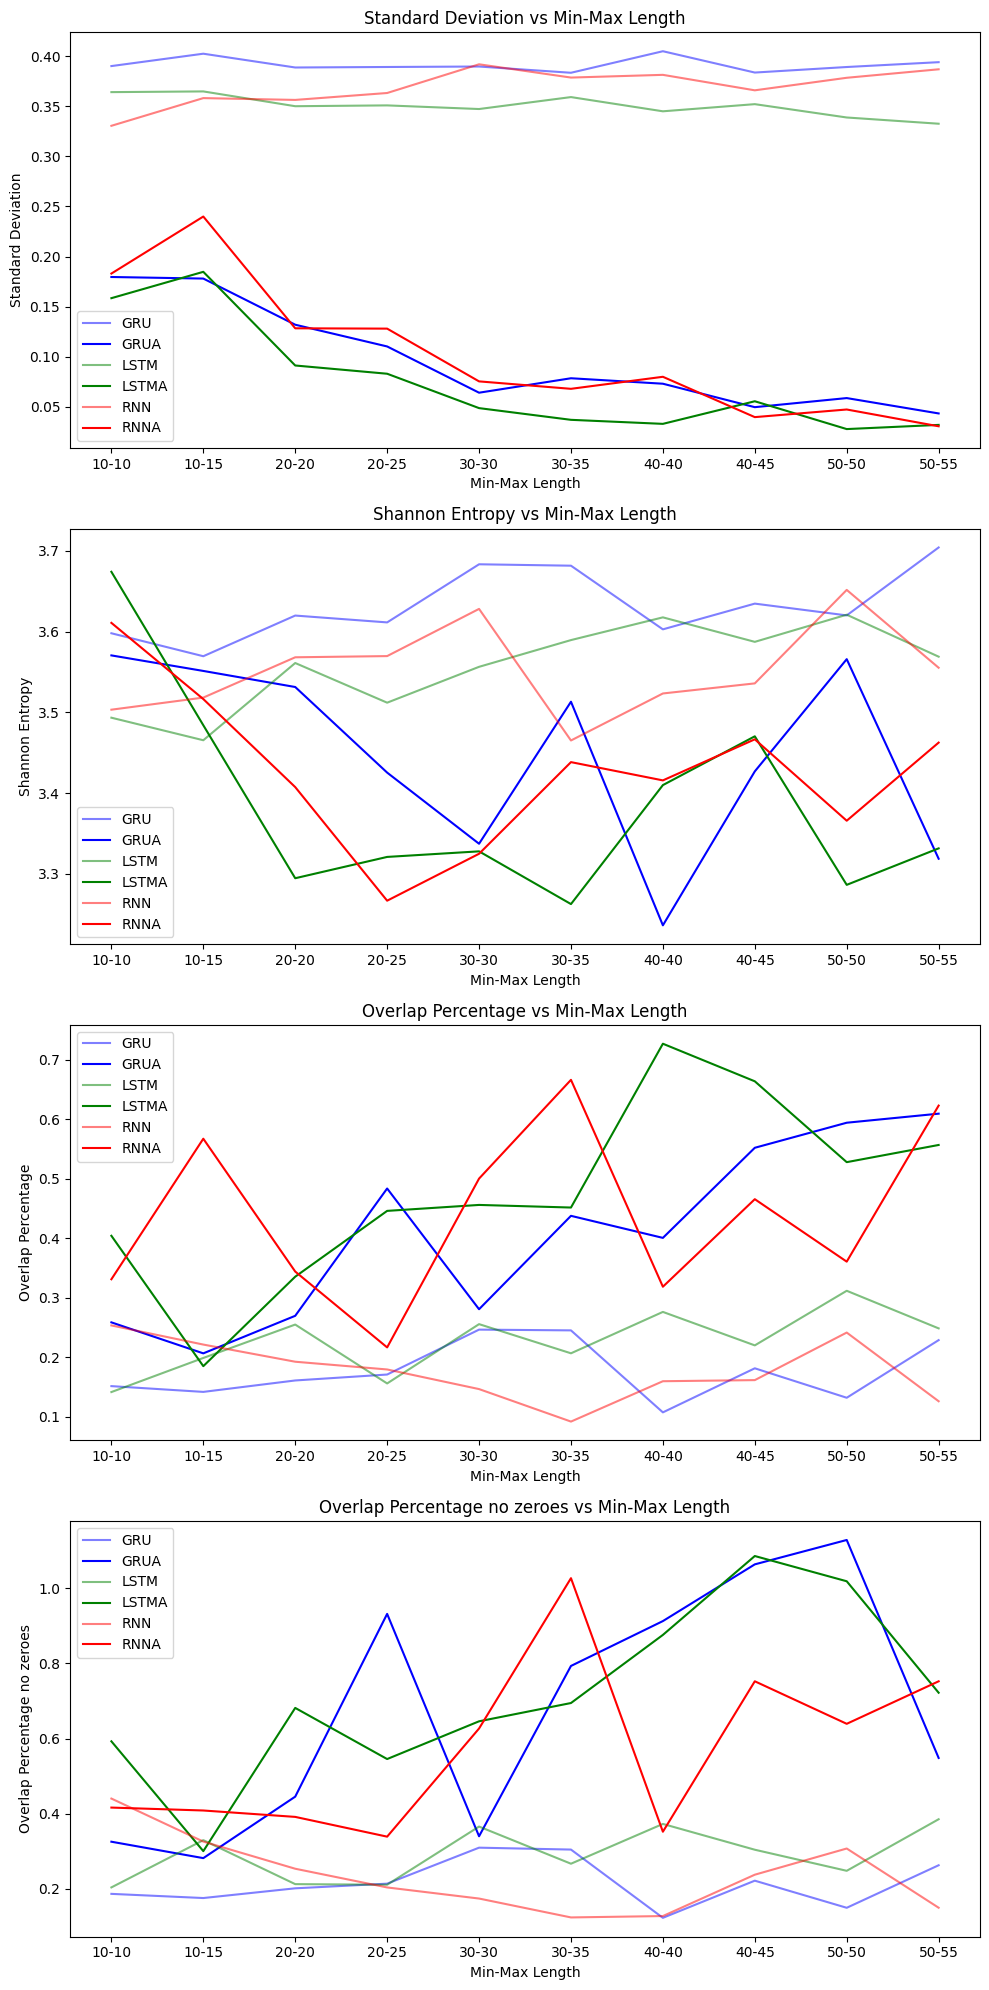

In [25]:

# Load the CSV file
file_path = './average_results_method1.csv'
data = pd.read_csv(file_path)

# Selecting relevant columns
plot_data = data[['Min_Length', 'Max_Length', 'Standard Deviation', 'Shannon Entropy', 'Overlap % with zeroes', 'Overlap % no zeroes']]
plot_data = plot_data.rename(columns={'Overlap % with zeroes': 'Overlap Percentage', 'Overlap % no zeroes': 'Overlap Percentage no zeroes'})

# Grouping the data by 'Kind' for plotting
grouped_data = plot_data.groupby(data['Kind'])

# Defining base colors for each pair of related models
base_colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Generating light and dark shades for each base color
color_shades = []
for base_color in base_colors:
    lighter = mcolors.to_rgba(base_color, alpha=0.5)  # lighter shade
    darker = mcolors.to_rgba(base_color, alpha=1.0)  # darker shade
    color_shades.extend([lighter, darker])

# Mapping models to their respective color shades
model_colors = dict(zip([model for model, _ in grouped_data], color_shades))

# Plotting with the new color scheme
fig, axs = plt.subplots(4, 1, figsize=(10, 20))

for name, group in grouped_data:
    min_max_label = group['Min_Length'].astype(str) + '-' + group['Max_Length'].astype(str)
    color = model_colors[name]
    
    # Standard Deviation
    axs[0].plot(min_max_label, group['Standard Deviation'], label=name, color=color)

    # Shannon Entropy
    axs[1].plot(min_max_label, group['Shannon Entropy'], label=name, color=color)

    # Overlap Percentage
    axs[2].plot(min_max_label, group['Overlap Percentage'], label=name, color=color)

    # Overlap Percentage no zeroes
    axs[3].plot(min_max_label, group['Overlap Percentage no zeroes'], label=name, color=color)

# Adding titles, labels, and legends
axs[0].set_title('Standard Deviation vs Min-Max Length')
axs[0].set_xlabel('Min-Max Length')
axs[0].set_ylabel('Standard Deviation')
axs[0].legend()

axs[1].set_title('Shannon Entropy vs Min-Max Length')
axs[1].set_xlabel('Min-Max Length')
axs[1].set_ylabel('Shannon Entropy')
axs[1].legend()

axs[2].set_title('Overlap Percentage vs Min-Max Length')
axs[2].set_xlabel('Min-Max Length')
axs[2].set_ylabel('Overlap Percentage')
axs[2].legend()

axs[3].set_title('Overlap Percentage no zeroes vs Min-Max Length')
axs[3].set_xlabel('Min-Max Length')
axs[3].set_ylabel('Overlap Percentage no zeroes')
axs[3].legend()

plt.tight_layout()
plt.show()

In [26]:
# Load the CSV file
new_file_path = './all_models_results.csv'
new_data = pd.read_csv(new_file_path)

# Define the pairs of models for comparison
model_pairs = [("RNN", "RNNA"), ("LSTM", "LSTMA"), ("GRU", "GRUA")]

# Metrics to test
metrics = ['Standard Deviation', 'Shannon Entropy', 'Overlap % with zeroes', 'Overlap % no zeroes']

# Function to perform KS test for a given pair of models and metric
def perform_ks_test(data, model1, model2, metric):
    data1 = data[data['Kind'] == model1][metric]
    data2 = data[data['Kind'] == model2][metric]
    return ks_2samp(data1, data2)

# Performing KS test for each pair of models and metric
ks_test_results = {}

for model1, model2 in model_pairs:
    ks_test_results[(model1, model2)] = {metric: perform_ks_test(new_data, model1, model2, metric) for metric in metrics}

# Printing the results
for models, results in ks_test_results.items():
    print(f"KS Test Results for {models[0]} vs {models[1]}:")
    for metric, result in results.items():
        print(f"  {metric}: KS statistic = {result.statistic}, p-value = {result.pvalue}")
    print()


KS Test Results for RNN vs RNNA:
  Standard Deviation: KS statistic = 0.867741935483871, p-value = 3.4132839857419724e-121
  Shannon Entropy: KS statistic = 0.2161290322580645, p-value = 9.389513736826495e-07
  Overlap % with zeroes: KS statistic = 0.14838709677419354, p-value = 0.0021402951878023574
  Overlap % no zeroes: KS statistic = 0.13548387096774195, p-value = 0.0067012591732433305

KS Test Results for LSTM vs LSTMA:
  Standard Deviation: KS statistic = 0.932258064516129, p-value = 8.709572109049778e-147
  Shannon Entropy: KS statistic = 0.25483870967741934, p-value = 2.985950395230642e-09
  Overlap % with zeroes: KS statistic = 0.14838709677419354, p-value = 0.0021402951878023574
  Overlap % no zeroes: KS statistic = 0.2161290322580645, p-value = 9.389513736826495e-07

KS Test Results for GRU vs GRUA:
  Standard Deviation: KS statistic = 0.9516129032258065, p-value = 7.113924973022208e-156
  Shannon Entropy: KS statistic = 0.2967741935483871, p-value = 1.9181788440395138e-12
 